*This data is located at D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\AllFEWeather.ipynb

Analysis of raw weather data from 11 weather stations in the Ferron-Emery area for the FE APEX watershed model.
Several years of weather data including temperature, wind, solar radiation, humidity, and precipitation.
Data was collected on an 10 min, 15 min, and hr interval. Periods range from 2004 to present or less
There are also times with up to 4 months of no data due to gaps. Available parameters for each location are
repeated in the raw data for a period from 1/1/04 through 12/31/16*

*This program does the following:
- Reads in the data from inidividual .csv or .xls weather files into a pandas dataframe. 
- Would be great to go to website and read in data in realtime. 
- Pick specific columns like date, time, temperature, precipitation, wind speed, relative humidity, dewpoint,  
     solar radiation, and other ancillary data. 
- Calculates correct units for PCP (mm), WND (m/s), and SLR (MJ/m2 hr) and assigns consistent name. 
- Reindex for continuous 1 hr timestep, for the missing periods fill with NAN's. 
- Copy missing parameters in each location from a similar location for full dataset (PCP1, RNMX1, PCPcum,      
     TMP1, TMP1, MAX1, MIN1, WND1, HMD1, DPT1, SLR1) at each location from 1/1/04 through 12/31/15. 
- Replace NaN's from re-index with linearly interpolated values for full dataset.
- Resample each location for hour, day, month, year intervals.
- Calculate hr/dy sum (PCP), min and max (TMP), and average (WND, SLR, HMD)
- Concatenate same parameters into new set for ave and range of each variable between all sites. 
- Make plots for data analysis, comparison, correction.
- Output results for WGN analysis
- Output results for APEXoutput.txt weather files.*

Updated by CLS 8/7/16

In [166]:
# Convert this or another notebook to PDF (or other)
# This is not working
# import IPython.nbconvert
# arg1 = 'D:/USGS/Shope_FE_Salt_Mobil/Data/Weather/Locations/AllFEWeather.ipynb' # enter 
# name of notebook to convert
# call ipython nbconvert --to latex --post pdf %arg1%

# I followed another procedure I found online
# 1) open cmd terminal
# 2) navigate to the directory of your notebook, <d:> and return, then 
#    <cd: D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations> and return
# 3) type <ipython nbconvert AllFEWeather.ipynb --to latex --post PDF>
# this works, just not inside the notebook

### DEPENDENCIES

In [167]:
import sys
import os
import pandas as pd
from pandas import *
import numpy as np
import datetime as dt
from datetime import datetime, date, time
# from datetime import date, timedelta
from itertools import tee, izip
import time
# from pyGDsandbox.dataIO import df2dbf, dbf2df # to make dbfs
# from pyGDsandbox import install_test # to make dbfs
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', figsize=(10, 8))
%matplotlib inline
print sys.version
print pd.__version__
print np.__version__
print mpl.__version__

2.7.12 |Anaconda 2.4.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]
0.17.0
1.10.1
1.4.3


### SET INPUT/OUTPUT PATHS

In [168]:
# basepath = os.path.abspath(os.path.join('..', '..'))
current = os.getcwd()
EPHR = os.path.join(current, 'Ephraim', 'Ephraim_Full_160807.csv')# SCAN
PRIC = os.path.join(current, 'Price', 'Price_Full_160807.csv')# SCAN
FERR = os.path.join(current, 'FerronCr', 'FerronCr_Full_160807.csv')# MesoWest
FREM = os.path.join(current, 'Fremont', 'Fremont_Full_160807.csv')# MesoWest
MUDY = os.path.join(current, 'MuddyCr', 'MuddyCr_Full_160807.csv')# MesoWest
BUCK = os.path.join(current, 'BuckFlat', 'BuckFlat_Full_160807.csv')# SNOTEL
DILL = os.path.join(current, 'DillsCamp', 'DillsCamp_Full_160807.csv')# SNOTEL
WRIG = os.path.join(current, 'WrigleyCr', 'WrigleyCr_Full_160807.csv')# SNOTEL
PIKL = os.path.join(current, 'PickleKeg', 'PickleKeg_Full_160807.csv')# SNOTEL
MUDL = os.path.join(current, 'MuddyCrLow', 'MuddyCrLow_Full_160807.csv')# USGS
MOSP = os.path.join(current, 'MolenSeep', 'MolenSeep_Full_160807.csv')# USGS
#inputs
print current
print EPHR
print PRIC
print FERR
print FREM
print MUDY
print BUCK
print DILL
print WRIG
print PIKL
print MUDL
print MOSP
# SWAT outputs - hardcoded
PCPdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\01_Precip_Data_1d'
TMPdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\02_Temp_Data_1d'
SLRdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\03_Sol_Rad_Data_1d'
WNDdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\04_Wind_Spd_Data_1d'
HMDdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\05_Rel_Hum_data_1d'
HalfPCPdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\07_Max_HalfHr_PCP_1d'
DPTdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\08_Dwpt_data_1d'
# WGN monthly states weather generator outputs - hardcoded
WGNdy = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\FEInputs\\06_Weather_Generator'
# APEX .dly outputs -hardcoded
ephr_apex = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\WeatherImport\FEdata'

D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\Ephraim\Ephraim_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\Price\Price_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\FerronCr\FerronCr_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\Fremont\Fremont_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\MuddyCr\MuddyCr_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\BuckFlat\BuckFlat_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\DillsCamp\DillsCamp_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\WrigleyCr\WrigleyCr_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\PickleKeg\PickleKeg_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\MuddyCrLow\MuddyCrLow_Full_160807.csv
D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\MolenSeep\MolenSeep_Full_160807.csv


### READ WEATHER DATA CSV FILES

*Raw data was collected from individual websites. To decrease statistical weather generator error, 
we did the following in the raw Excel file to estimate the entire meteorological record:

1) extended the existing data from 1/1/04 - 12/31/16 by copying from adjacent years (MUDL and MOSP 
     from PRIC PCP)
     
2) fix problem/error data, particularly with jumps in cumm pcp (additive-only higher, remove spikes)

This program will further add in other parameters (PCP,PCPcum,RNMX,TMIN,TMAX,TAVE,WND,HMD,DPT,SLR) 
from adjacent stations*

In [169]:
# EPHRAIM - PCP,TMP,WND,HMD,DPT,SLR (5/9/07-10/1/15)
eph01 = pd.read_csv(EPHR, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True, 
                 usecols=['Date','Time','PREC.I-2 (in) ','PRCP.H-1 (in) ','TMAX.H-1 (degC) ',
                          'TMIN.H-1 (degC) ','TAVG.H-1 (degC) ','WSPDX.H-1 (mph) ','RHUM.I-1 (pct) ',
                          'DPTP.H-1 (degC) ','SRADV.H-1 (watt) '], 
                 index_col=['datetime'], 
                 na_values='-99.9') # PREC.I-2 (in)=PCP cummulative,PRCP.H-1 (in)=PCP hourly step
print eph01.dtypes
print eph01.index

Date                  object
Time                  object
PREC.I-2 (in)        float64
TMAX.H-1 (degC)      float64
TMIN.H-1 (degC)      float64
TAVG.H-1 (degC)      float64
PRCP.H-1 (in)        float64
WSPDX.H-1 (mph)      float64
RHUM.I-1 (pct)       float64
DPTP.H-1 (degC)      float64
SRADV.H-1 (watt)     float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]',

In [170]:
# PRICE - PCP,TMP,WND,HMD,DPT,SLR (5/17/07-10/1/15)
pri01 = pd.read_csv(PRIC, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date','Time','PREC.I-2 (in) ','PRCP.H-1 (in) ','TMAX.H-1 (degC) ',
                          'TMIN.H-1 (degC) ','TAVG.H-1 (degC) ','WSPDX.H-1:124 (mph) ','RHUM.I-1 (pct) ',
                          'DPTP.H-1 (degC) ','SRADV.H-1 (watt) '], 
                 index_col=['datetime'],
                 na_values='-99.9') # PREC.I-2 (in)=PCP cummulative,PRCP.H-1 (in)=PCP hourly step
print pri01.dtypes
print pri01.index

Date                     object
Time                     object
PREC.I-2 (in)           float64
TMAX.H-1 (degC)         float64
TMIN.H-1 (degC)         float64
TAVG.H-1 (degC)         float64
PRCP.H-1 (in)           float64
WSPDX.H-1:124 (mph)     float64
RHUM.I-1 (pct)            int64
DPTP.H-1 (degC)         float64
SRADV.H-1 (watt)        float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
    

In [171]:
# FERRON - TMP Only (No PCP,WND,HMD,DPT,SLR) (2/25/13-10/1/15)
fer01 = pd.read_csv(FERR, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'TAVG.H-1 (degC) '],
                 index_col=['datetime'],
                 na_values='-99.9')
fer01['TMP MIN C'] = fer01['TAVG.H-1 (degC) '].astype(float).copy()
fer01['TMP MAX C'] = fer01['TAVG.H-1 (degC) '].astype(float).copy()
print fer01.dtypes
print fer01.index

Date                 object
Time                 object
TAVG.H-1 (degC)     float64
TMP MIN C           float64
TMP MAX C           float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 00:15:00',
               '2004-01-01 00:30:00', '2004-01-01 00:45:00',
               '2004-01-01 01:00:00', '2004-01-01 01:15:00',
               '2004-01-01 01:30:00', '2004-01-01 01:45:00',
               '2004-01-01 02:00:00', '2004-01-01 02:15:00',
               ...
               '2016-12-31 21:30:00', '2016-12-31 21:45:00',
               '2016-12-31 22:00:00', '2016-12-31 22:15:00',
               '2016-12-31 22:30:00', '2016-12-31 22:45:00',
               '2016-12-31 23:00:00', '2016-12-31 23:15:00',
               '2016-12-31 23:30:00', '2016-12-31 23:45:00'],
              dtype='datetime64[ns]', name=u'datetime', length=444078, freq=None)


In [172]:
# FREMONT - TMP,WND,HMD,DPT,SLR (No PCP) (12/26/08-10/1/15)
fre01 = pd.read_csv(FREM, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'TMP C', 'SKNT m/s', 'RELH %', 
                          'DWP C', 'SOLR W/m*m'],
                 index_col=['datetime'],
                 na_values='-99.9')
fre01['MIN1'] = fre01['TMP C'].astype(float)
fre01['MAX1'] = fre01['TMP C'].astype(float)
print fre01.dtypes
print fre01.index

Date           object
Time           object
TMP C         float64
RELH %        float64
SKNT m/s      float64
SOLR W/m*m    float64
DWP C         float64
MIN1          float64
MAX1          float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 00:10:00',
               '2004-01-01 00:20:00', '2004-01-01 00:30:00',
               '2004-01-01 00:40:00', '2004-01-01 00:50:00',
               '2004-01-01 01:00:00', '2004-01-01 01:10:00',
               '2004-01-01 01:20:00', '2004-01-01 01:30:00',
               ...
               '2016-12-31 22:20:00', '2016-12-31 22:30:00',
               '2016-12-31 22:40:00', '2016-12-31 22:50:00',
               '2016-12-31 23:00:00', '2016-12-31 23:10:00',
               '2016-12-31 23:20:00', '2016-12-31 23:30:00',
               '2016-12-31 23:40:00', '2016-12-31 23:50:00'],
              dtype='datetime64[ns]', name=u'datetime', length=778961, freq=None)


In [173]:
# MUDDY - PCP,TMP,WND,HMD,DPT (No SLR) (3/31/05-10/1/15)
mud01 = pd.read_csv(MUDY, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PREC cm','PCP cm','TMP C','RELH %','SKNT m/s',
                          'DWP C'],
                 index_col=['datetime'],
                 na_values='-99.9') # PREC cm=PCP cummulative,PCP cm=PCP 15 min step
mud01['MIN1'] = mud01['TMP C'].astype(float)
mud01['MAX1'] = mud01['TMP C'].astype(float)
print mud01.dtypes
print mud01.index

Date         object
Time         object
TMP C       float64
RELH %        int64
SKNT m/s    float64
PREC cm     float64
PCP cm      float64
DWP C       float64
MIN1        float64
MAX1        float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 00:15:00',
               '2004-01-01 00:30:00', '2004-01-01 00:45:00',
               '2004-01-01 01:00:00', '2004-01-01 01:15:00',
               '2004-01-01 01:30:00', '2004-01-01 01:45:00',
               '2004-01-01 02:00:00', '2004-01-01 02:15:00',
               ...
               '2016-12-31 21:30:00', '2016-12-31 21:45:00',
               '2016-12-31 22:00:00', '2016-12-31 22:15:00',
               '2016-12-31 22:30:00', '2016-12-31 22:45:00',
               '2016-12-31 23:00:00', '2016-12-31 23:15:00',
               '2016-12-31 23:30:00', '2016-12-31 23:45:00'],
              dtype='datetime64[ns]', name=u'datetime', length=415442, freq=None)


In [174]:
# BUCK - PCP,TMP (No SLR,WND,HMD,DPT) (1/1/04-10/1/15)
buc01 = pd.read_csv(BUCK, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PCP3 (in)','PCP4 (in)','PREC.I-1 (in) ','TOBS.I-1 (degC) '],
                 index_col=['datetime'],
                 na_values='-99.9') # PCP3 (in)=PCP cumm, PCP4 (in)=PCP hr step, PREC.I-1 (in)=raw cumm
buc01['MIN1'] = buc01['TOBS.I-1 (degC) '].astype(float)
buc01['MAX1'] = buc01['TOBS.I-1 (degC) '].astype(float)
print buc01.dtypes
print buc01.index

Date                 object
Time                 object
PREC.I-1 (in)       float64
PCP3 (in)           float64
PCP4 (in)           float64
TOBS.I-1 (degC)     float64
MIN1                float64
MAX1                float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=113977, freq=None)


In [175]:
# DILL - PCP,TMP (No SLR,WND,HMD,DPT) (1/1/04-10/1/15)
dil01 = pd.read_csv(DILL, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PCP3 (in)','PCP4 (in)','PREC.I-1 (in) ','TOBS.I-1 (degC) '],
                 index_col=['datetime'],
                 na_values='-99.9') # PCP3 (in)=PCP cumm, PCP4 (in)=PCP hr step, PREC.I-1 (in)=raw cumm
dil01['MIN1'] = dil01['TOBS.I-1 (degC) '].astype(float)
dil01['MAX1'] = dil01['TOBS.I-1 (degC) '].astype(float)
print dil01.dtypes
print dil01.index

Date                 object
Time                 object
PREC.I-1 (in)       float64
PCP3 (in)           float64
PCP4 (in)           float64
TOBS.I-1 (degC)     float64
MIN1                float64
MAX1                float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=113972, freq=None)


In [176]:
# WRIG - PCP,TMP (No SLR,WND,HMD,DPT) (7/19/12-10/1/15)
wri01 = pd.read_csv(WRIG, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PCP3 (in)','PCP4 (in)', 'PREC.I-1 (in) ','TOBS.I-1 (degC) '],
                 index_col=['datetime'],
                 na_values='-99.9') # PCP3 (in)=PCP cumm, PCP4 (in)=PCP hr step, PREC.I-1 (in)=raw cumm
wri01['MIN1'] = wri01['TOBS.I-1 (degC) '].astype(float)
wri01['MAX1'] = wri01['TOBS.I-1 (degC) '].astype(float)
print wri01.dtypes
print wri01.index

Date                 object
Time                 object
PREC.I-1 (in)       float64
PCP3 (in)           float64
PCP4 (in)           float64
TOBS.I-1 (degC)     float64
MIN1                float64
MAX1                float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=113888, freq=None)


In [177]:
# PIKL - PCP,TMP (No SLR,WND,HMD,DPT) (1/1/04-10/1/15)
pik01 = pd.read_csv(PIKL, skiprows=2, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PCP3 (in)','PCP4 (in)','PREC.I-1 (in) ','TOBS.I-1 (degC) '],
                 index_col=['datetime'],
                 na_values='-99.9') # PCP3 (in)=PCP cumm, PCP4 (in)=PCP hr step, PREC.I-1 (in)=raw cumm
pik01['MIN1'] = pik01['TOBS.I-1 (degC) '].astype(float)
pik01['MAX1'] = pik01['TOBS.I-1 (degC) '].astype(float)
print pik01.dtypes
print pik01.index

Date                 object
Time                 object
PREC.I-1 (in)       float64
PCP3 (in)           float64
PCP4 (in)           float64
TOBS.I-1 (degC)     float64
MIN1                float64
MAX1                float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=113965, freq=None)


In [178]:
# MUDL - PCP (No SLR,WND,HMD,DPT,TMP) (4/28/15-10/1/15)
mdl01 = pd.read_csv(MUDL, skiprows=30, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PCP3 (in)','PCP4 (in)','Q_CFS','SPC_uS'],
                 index_col=['datetime'],
                 na_values='-99.9') # PCP3 (in)=PCP cummulative,PCP4 (in)=PCP hourly step
mdl01['Q_CFS'].replace(regex=True,inplace=True,to_replace=r'Ice',value=np.NaN)
mdl01[['Q_CFS']]=mdl01[['Q_CFS']].astype(float)
print mdl01.dtypes
print mdl01.index

Date          object
Time          object
Q_CFS        float64
SPC_uS       float64
PCP3 (in)    float64
PCP4 (in)    float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=236912, freq=None)


In [179]:
# MOSP - PCP (No SLR,WND,HMD,DPT,TMP) (4/29/15-10/1/15)
msp01 = pd.read_csv(MOSP, skiprows=29, header=0,
                 parse_dates={'datetime':['Date', 'Time']},
                 keep_date_col=True, 
                 infer_datetime_format=True,
                 usecols=['Date', 'Time', 'PCP3 (in)','PCP4 (in)','SPC_uS'],
                 index_col=['datetime'],
                 na_values='-99.9') # PCP3 (in)=PCP cummulative,PCP4 (in)=PCP hourly step
msp01['SPC_uS'].replace(regex=True,inplace=True,to_replace=r'Dry',value=np.NaN)
msp01[['SPC_uS']]=msp01[['SPC_uS']].astype(float)
print msp01.dtypes
print msp01.index

Date          object
Time          object
SPC_uS       float64
PCP3 (in)    float64
PCP4 (in)    float64
dtype: object
DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'datetime', length=236074, freq=None)


### Plot PCP cummulative at each location (in or cm)

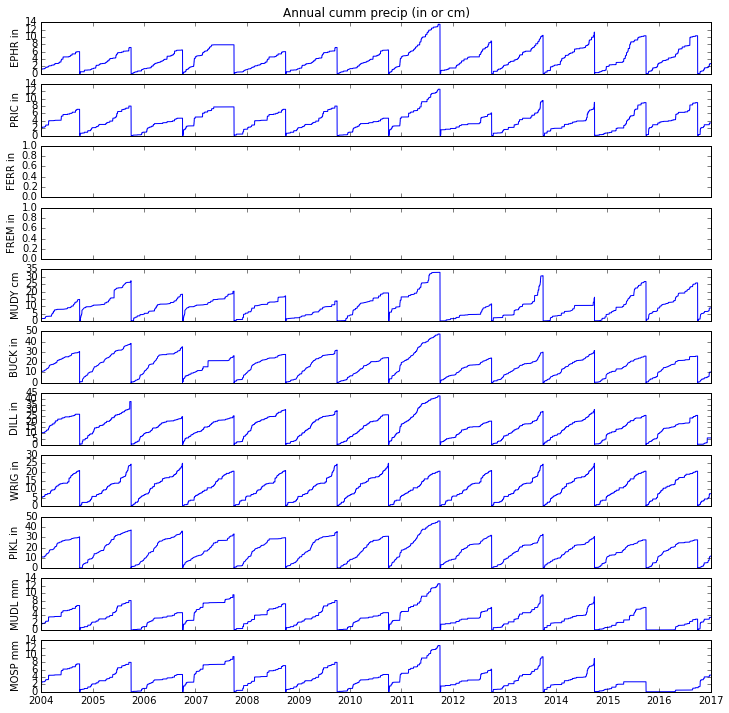

In [180]:
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
ax0 = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR in')
plt.title('Annual cumm precip (in or cm)')
plt.plot(eph01.index, eph01['PREC.I-2 (in) '], c='b', label="Hourly")
# plt.ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax1 = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC in')
plt.plot(pri01.index, pri01['PREC.I-2 (in) '], c='b', label="Hourly")
plt.xticks(visible=False)

ax2 = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR in')
# plt.plot(fer01.index, fer01.PCPcum, c='b', label="Hourly")
plt.xticks(visible=False)

ax3 = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM in')
# plt.plot(fre01.index, fre01.PCPcum, c='b', label="Hourly")
plt.xticks(visible=False)

ax4 = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY cm')
plt.plot(mud01.index, mud01['PREC cm'], c='b', label="Hourly")
plt.xticks(visible=False)

ax5 = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK in')
plt.plot(buc01.index, buc01['PCP3 (in)'], c='b', label="Hourly")
plt.xticks(visible=False)

ax6 = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL in')
plt.plot(dil01.index, dil01['PCP3 (in)'], c='b', label="Hourly")
plt.xticks(visible=False)

ax7 = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG in')
plt.plot(wri01.index, wri01['PCP3 (in)'], c='b', label="Hourly")
plt.xticks(visible=False)

ax8 = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL in')
plt.plot(pik01.index, pik01['PCP3 (in)'], c='b', label="Hourly")
plt.xticks(visible=False)

ax9 = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL mm')
plt.plot(mdl01.index, mdl01['PCP3 (in)'], c='b', label="Hourly")
plt.xticks(visible=False)

ax10 = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP mm')
plt.plot(msp01.index, msp01['PCP3 (in)'], c='b', label="Hourly")

fig01.savefig('07_AllSites_cumm_PCP_raw.png', bbox_inches='tight')

### Plot cumm SNOTEL raw and corrected

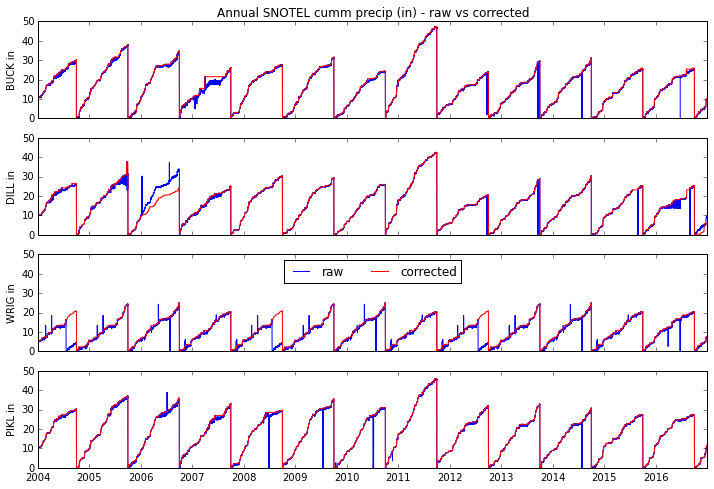

In [181]:
fig01 = plt.figure(figsize=(12, 8))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
ax0 = fig01.add_subplot(4,1,1)
plt.ylabel('BUCK in')
plt.title('Annual SNOTEL cumm precip (in) - raw vs corrected')
plt.plot(buc01.index, buc01['PREC.I-1 (in) '], c='b', label="raw")
plt.plot(buc01.index, buc01['PCP3 (in)'], c='r', label="corrected")
plt.ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016'), visible=False)

ax1 = fig01.add_subplot(4,1,2, sharex=ax0)
plt.ylabel('DILL in')
plt.plot(dil01.index, dil01['PREC.I-1 (in) '], c='b', label="raw")
plt.plot(dil01.index, dil01['PCP3 (in)'], c='r', label="corrected")
plt.ylim(0,50)
plt.xticks(visible=False)

ax2 = fig01.add_subplot(4,1,3, sharex=ax0)
plt.ylabel('WRIG in')
plt.plot(wri01.index, wri01['PREC.I-1 (in) '], c='b', label="raw")
plt.plot(wri01.index, wri01['PCP3 (in)'], c='r', label="corrected")
plt.ylim(0,50)
plt.xticks(visible=False)
ax2.legend(bbox_to_anchor=[0.5,1], loc='upper center', ncol=2)

ax3 = fig01.add_subplot(4,1,4, sharex=ax0)
plt.ylabel('PIKL in')
plt.plot(pik01.index, pik01['PREC.I-1 (in) '], c='b', label="raw")
plt.plot(pik01.index, pik01['PCP3 (in)'], c='r', label="corrected")
plt.ylim(0,50)

fig01.savefig('07_AllSNOTEL_cumm_PCP_raw_correct.png', bbox_inches='tight')

### RENAME COLUMNS AND CONVERT UNITS

Date                  object
Time                  object
PREC.I-2 (in)        float64
MAX1                 float64
MIN1                 float64
TMP1                 float64
PRCP.H-1 (in)        float64
WSPDX.H-1 (mph)      float64
HMD1                 float64
DPT1                 float64
SRADV.H-1 (watt)     float64
PCPcum               float64
PCP1                 float64
WND1                 float64
SLR1                 float64
RNMX1                float64
dtype: object


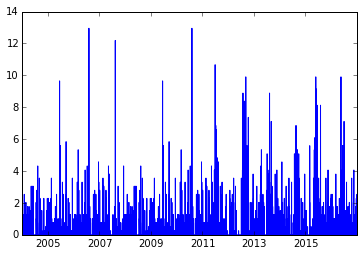

In [182]:
# EPHRAIM
eph01.rename(columns={'TMAX.H-1 (degC) ':'MAX1','TMIN.H-1 (degC) ':'MIN1','TAVG.H-1 (degC) ':'TMP1',
                      'RHUM.I-1 (pct) ':'HMD1','DPTP.H-1 (degC) ':'DPT1'},
             inplace=True)
pcpconv = 25.4
wndconv = 0.44704
slrconv = 0.0036 # 1W/m2-s * 1J/1W * 1MJ/10^6J * 3600s/hr = 0.0036 MJ/m2-hr
# **** NRCS SRADV is in W every hour of measurement (EPHR, PRIC, FREM)
# **** should be 1W/m2-hr * 1J/1W * 1MJ/10^6J  = 0.000001 MJ/m2-hr
eph01['PCPcum'] = eph01['PREC.I-2 (in) '] * pcpconv # convert PCP in to mm
eph01['PCP1'] = eph01['PRCP.H-1 (in) '] * pcpconv # convert PCP in to mm
eph01['WND1'] = eph01['WSPDX.H-1 (mph) '] * wndconv # convert WND mph to m/s
eph01['SLR1'] = eph01['SRADV.H-1 (watt) ']  * slrconv # column to calculate 1/2 hr PCP
eph01['RNMX1'] = eph01['PRCP.H-1 (in) '] # column to calculate 1/2 hr PCP ***this is in inches, not mm

eph01.rename(columns={'datetime':'DATE'},inplace=True)
print eph01.dtypes
plt.plot(eph01.index,eph01.PCP1)
# print eph01

In [183]:
# PRICE
pri01.rename(columns={'TMAX.H-1 (degC) ':'MAX1','TMIN.H-1 (degC) ':'MIN1','TAVG.H-1 (degC) ':'TMP1',
                      'RHUM.I-1 (pct) ':'HMD1','DPTP.H-1 (degC) ':'DPT1'},
             inplace=True)
pcpconv = 25.4
wndconv = 0.44704
slrconv = 0.0036 # 1W/m2-s * 1J/1W * 1MJ/10^6J * 3600s/hr = 0.0036 MJ/m2-hr
pri01['PCPcum'] = pri01['PREC.I-2 (in) '] * pcpconv # convert PCP in to mm
pri01['PCP1'] = pri01['PRCP.H-1 (in) '] * pcpconv # convert PCP in to mm
pri01['WND1'] = pri01['WSPDX.H-1:124 (mph) '] * wndconv # convert WND mph to m/s
pri01['SLR1'] = pri01['SRADV.H-1 (watt) ']  * slrconv # column to calculate 1/2 hr PCP
pri01['RNMX1'] = pri01['PRCP.H-1 (in) '] # column to calculate 1/2 hr PCP

pri01.rename(columns={'datetime':'DATE'},inplace=True)
print pri01.dtypes
# print pri01

Date                     object
Time                     object
PREC.I-2 (in)           float64
MAX1                    float64
MIN1                    float64
TMP1                    float64
PRCP.H-1 (in)           float64
WSPDX.H-1:124 (mph)     float64
HMD1                      int64
DPT1                    float64
SRADV.H-1 (watt)        float64
PCPcum                  float64
PCP1                    float64
WND1                    float64
SLR1                    float64
RNMX1                   float64
dtype: object


In [184]:
# FERRON
# not sure why changing datetime to DATE when others have datetime, DATE, and TIME but works
fer01.rename(columns={'datetime':'DATE','TAVG.H-1 (degC) ':'TMP1','TMP MAX C':'MAX1',
                      'TMP MIN C':'MIN1'}, inplace=True)
print fer01.dtypes
# print fer01

Date     object
Time     object
TMP1    float64
MIN1    float64
MAX1    float64
dtype: object


In [185]:
# FREMONT
fre01.rename(columns={'TMP C':'TMP1','SKNT m/s':'WND1','RELH %':'HMD1',
                      'DWP C':'DPT1'}, inplace=True)
slrconv = 0.0036 # 1W/m2-s * 1J/1W * 1MJ/10^6J * 3600s/hr = 0.0036 MJ/m2-hr
fre01['SLR1'] = fre01['SOLR W/m*m'] * slrconv # convert SLR W/m2 to MJ/m2

print fre01.dtypes
# print fre01

Date           object
Time           object
TMP1          float64
HMD1          float64
WND1          float64
SOLR W/m*m    float64
DPT1          float64
MIN1          float64
MAX1          float64
SLR1          float64
dtype: object


In [186]:
# MUDDY
mud01.rename(columns={'TMP C':'TMP1','SKNT m/s':'WND1',
                      'RELH %':'HMD1','DWP C':'DPT1'}, inplace=True)
pcpconv = 10
mud01['PCPcum'] = mud01['PREC cm'] * pcpconv # convert PCP in to mm
mud01['PCP1'] = mud01['PCP cm'] * pcpconv # convert PCP in to mm
mud01['RNMX1'] = mud01['PCP cm'] # column to calculate 1/2 hr PCP

print mud01.dtypes
# print mud01

Date        object
Time        object
TMP1       float64
HMD1         int64
WND1       float64
PREC cm    float64
PCP cm     float64
DPT1       float64
MIN1       float64
MAX1       float64
PCPcum     float64
PCP1       float64
RNMX1      float64
dtype: object


In [187]:
# BUCK
pcpconv = 25.4
buc01['PCPcum'] = buc01['PCP3 (in)'] * pcpconv # convert PCP in to mm
buc01['PCP1'] = buc01['PCP4 (in)'] * pcpconv # convert PCP in to mm
buc01['RNMX1'] = buc01['PCP4 (in)'] # column to calculate 1/2 hr PCP
buc01.rename(columns={'TOBS.I-1 (degC) ':'TMP1'}, inplace=True)
#[Date,Time,PCP2 (in),TMP1,MIN1,MAX1,PCP1,RNMX1]
print buc01.dtypes
# print buc01

Date               object
Time               object
PREC.I-1 (in)     float64
PCP3 (in)         float64
PCP4 (in)         float64
TMP1              float64
MIN1              float64
MAX1              float64
PCPcum            float64
PCP1              float64
RNMX1             float64
dtype: object


In [188]:
# DILL
pcpconv = 25.4
dil01['PCPcum'] = dil01['PCP3 (in)'] * pcpconv # convert PCP in to mm
dil01['PCP1'] = dil01['PCP4 (in)'] * pcpconv # convert PCP in to mm
dil01['RNMX1'] = dil01['PCP4 (in)'] # column to calculate 1/2 hr PCP
dil01.rename(columns={'TOBS.I-1 (degC) ':'TMP1'}, inplace=True)
#[Date,Time,PCP2 (in),TMP1,MIN1,MAX1,PCP1,RNMX1]
print dil01.dtypes
# print dil01

Date               object
Time               object
PREC.I-1 (in)     float64
PCP3 (in)         float64
PCP4 (in)         float64
TMP1              float64
MIN1              float64
MAX1              float64
PCPcum            float64
PCP1              float64
RNMX1             float64
dtype: object


In [189]:
# WRIG
pcpconv = 25.4
wri01['PCPcum'] = wri01['PCP3 (in)'] * pcpconv # convert PCP in to mm
wri01['PCP1'] = wri01['PCP4 (in)'] * pcpconv # convert PCP in to mm
wri01['RNMX1'] = wri01['PCP4 (in)'] # column to calculate 1/2 hr PCP
wri01.rename(columns={'TOBS.I-1 (degC) ':'TMP1'}, inplace=True)
#[Date,Time,PCP2 (in),TMP1,MIN1,MAX1,PCP1,RNMX1]
print wri01.dtypes
# print wri01

Date               object
Time               object
PREC.I-1 (in)     float64
PCP3 (in)         float64
PCP4 (in)         float64
TMP1              float64
MIN1              float64
MAX1              float64
PCPcum            float64
PCP1              float64
RNMX1             float64
dtype: object


In [190]:
# PIKL
pcpconv = 25.4
pik01['PCPcum'] = pik01['PCP3 (in)'] * pcpconv # convert PCP in to mm
pik01['PCP1'] = pik01['PCP4 (in)'] * pcpconv # convert PCP in to mm
pik01['RNMX1'] = pik01['PCP4 (in)'] # column to calculate 1/2 hr PCP
pik01.rename(columns={'TOBS.I-1 (degC) ':'TMP1'}, inplace=True)
#[Date,Time,PCP2 (in),TMP1,MIN1,MAX1,PCP1,RNMX1]
print pik01.dtypes
# print pik01

Date               object
Time               object
PREC.I-1 (in)     float64
PCP3 (in)         float64
PCP4 (in)         float64
TMP1              float64
MIN1              float64
MAX1              float64
PCPcum            float64
PCP1              float64
RNMX1             float64
dtype: object


In [191]:
# MUDL
pcpconv = 25.4
mdl01['PCPcum'] = mdl01['PCP3 (in)'] * pcpconv # convert PCP in to mm
mdl01['PCP1'] = mdl01['PCP4 (in)'] * pcpconv # convert PCP in to mm
mdl01['RNMX1'] = mdl01['PCP4 (in)'] # column to calculate 1/2 hr PCP
print mdl01.dtypes
# print mdl01

Date          object
Time          object
Q_CFS        float64
SPC_uS       float64
PCP3 (in)    float64
PCP4 (in)    float64
PCPcum       float64
PCP1         float64
RNMX1        float64
dtype: object


In [192]:
# MOSP
pcpconv = 25.4
msp01['PCPcum'] = msp01['PCP3 (in)'] * pcpconv # convert PCP in to mm
msp01['PCP1'] = msp01['PCP4 (in)'] * pcpconv # convert PCP in to mm
msp01['RNMX1'] = msp01['PCP4 (in)'] # column to calculate 1/2 hr PCP
print msp01.dtypes
# print msp01

Date          object
Time          object
SPC_uS       float64
PCP3 (in)    float64
PCP4 (in)    float64
PCPcum       float64
PCP1         float64
RNMX1        float64
dtype: object


### Plot PCP cummulative at each location (mm)

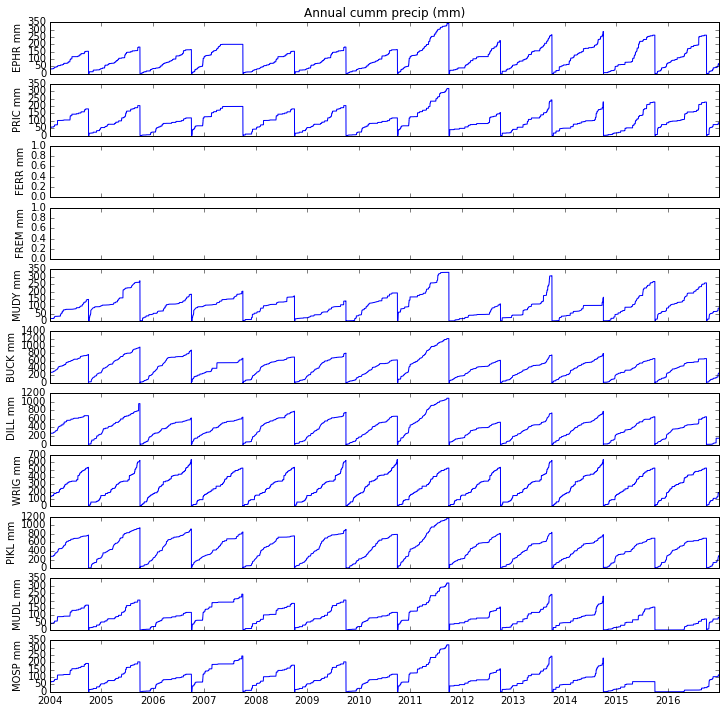

In [193]:
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR mm')
plt.title('Annual cumm precip (mm)')
plt.plot(eph01.index, eph01['PCPcum'], c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC mm')
plt.plot(pri01.index, pri01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR mm')
# plt.plot(fer01.index, fer01.PCPcum, c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM mm')
# plt.plot(fre01.index, fre01.PCPcum, c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY mm')
plt.plot(mud01.index, mud01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK mm')
plt.plot(buc01.index, buc01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL mm')
plt.plot(dil01.index, dil01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG mm')
plt.plot(wri01.index, wri01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL mm')
plt.plot(pik01.index, pik01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL mm')
plt.plot(mdl01.index, mdl01['PCPcum'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP mm')
plt.plot(msp01.index, msp01['PCPcum'], c='b', label="Hourly")

fig01.savefig('07_AllSites_cumm_PCP_mm.png', bbox_inches='tight')

### REINDEX FOR CONSTANT DT

(113941, 16)
(113976L,)
(113976, 12)


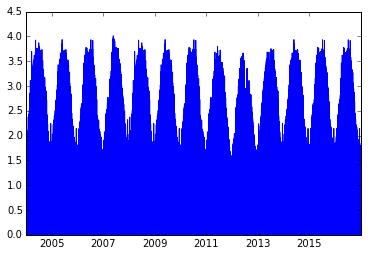

In [194]:
# EPHRAIM
ephts = pd.DatetimeIndex(start = eph01.index.min(),end = eph01.index.max(),freq = 'H') #H
print eph01.shape#, eph01.dtypes
print ephts.shape
eph02 = eph01.reindex(ephts, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1',
                                      'WND1','HMD1','DPT1','SLR1'])
print eph02.shape
plt.plot(eph02.index,eph02.SLR1)

(113851, 16)
(113976, 12)


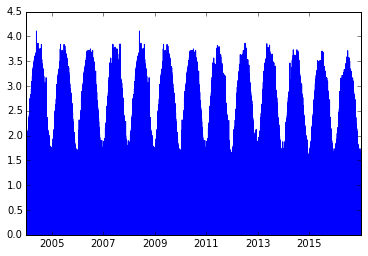

In [195]:
# PRICE
prits = pd.DatetimeIndex(start = pri01.index.min(),end = pri01.index.max(),freq = 'H') #H
print pri01.shape#, pri01.dtypes
pri02 = pri01.reindex(prits, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1',
                                      'WND1','HMD1','DPT1','SLR1'])
print pri02.shape
plt.plot(pri02.index,pri02.SLR1)

(444078, 5)
(113976L,)
(113976, 5)


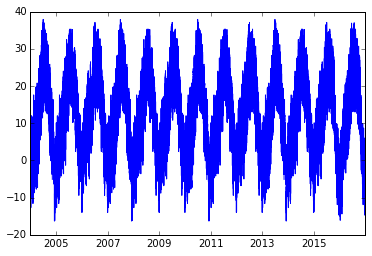

In [196]:
# FERRON
ferts = pd.DatetimeIndex(start=fer01.index.min(),end=fer01.index.max(),freq='H') #15Min
print fer01.shape
print ferts.shape
fer02 = fer01.reindex(ferts, columns=['Date','Time', 'MAX1','MIN1','TMP1'])
print fer02.shape
# print fer02.describe()
# print ferts
plt.plot(fer02.index,fer02.TMP1)

Date           object
Time           object
TMP1          float64
HMD1          float64
WND1          float64
SOLR W/m*m    float64
DPT1          float64
MIN1          float64
MAX1          float64
SLR1          float64
dtype: object
(778961, 10)
(113976, 9)


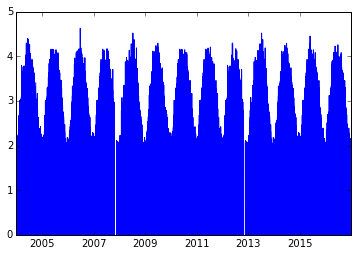

In [197]:
# FREMONT
print fre01.dtypes
frets = pd.DatetimeIndex(start=fre01.index.min(),end=fre01.index.max(),freq='H')#10Min
print fre01.shape
# print frets.shape
fre02 = fre01.reindex(frets, columns=['Date','Time','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1'])
print fre02.shape
plt.plot(fre02.index,fre02.SLR1)

(415442, 13)
(113976, 11)


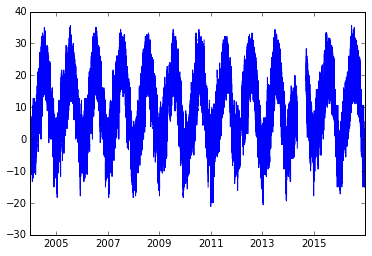

In [198]:
# MUDDY
mudts = pd.DatetimeIndex(start = mud01.index.min(),end = mud01.index.max(),freq = 'H')#30Min
print mud01.shape
mud02 = mud01.reindex(mudts, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1', 
                                      'WND1','HMD1','DPT1'])
print mud02.shape
plt.plot(mud02.index,mud02.TMP1)

(113977, 11)
(113976, 8)


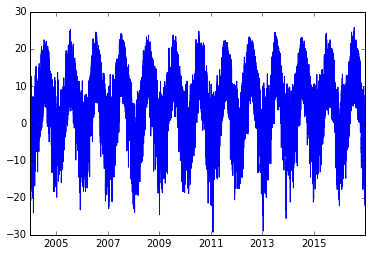

In [199]:
# BUCK
bucts = pd.DatetimeIndex(start = buc01.index.min(),end = buc01.index.max(),freq = 'H')#H
print buc01.shape
buc02 = buc01.reindex(bucts, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1'])
print buc02.shape
plt.plot(buc02.index,buc02.TMP1)

(113972, 11)
(113976, 8)


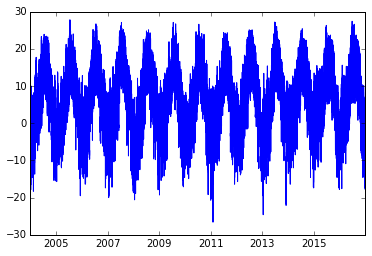

In [200]:
# DILL
dilts = pd.DatetimeIndex(start = dil01.index.min(),end = dil01.index.max(),freq = 'H')#H
print dil01.shape
dil02 = dil01.reindex(dilts, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1'])
print dil02.shape
plt.plot(dil02.index,dil02.TMP1)

(113888, 11)
(113976, 8)


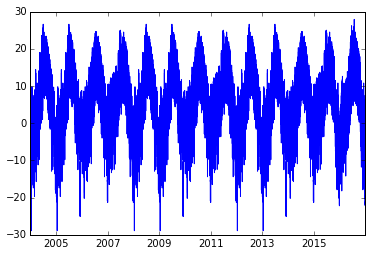

In [201]:
# WRIG
writs = pd.DatetimeIndex(start = wri01.index.min(),end = wri01.index.max(),freq = 'H')#H
print wri01.shape
wri02 = wri01.reindex(writs, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1'])
print wri02.shape
plt.plot(wri02.index,wri02.TMP1)

(113965, 11)
(113976, 8)


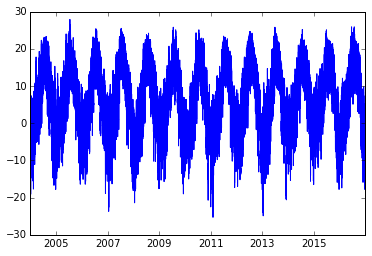

In [202]:
# PIKL
pklts = pd.DatetimeIndex(start = pik01.index.min(),end = pik01.index.max(),freq = 'H')#H
print pik01.shape
pik02 = pik01.reindex(pklts, columns=['Date','Time','PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1'])
print pik02.shape
plt.plot(pik02.index,pik02.TMP1)

(236912, 9)
(113976, 7)


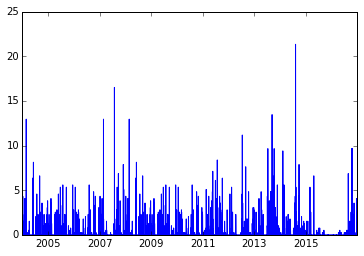

In [203]:
# MUDL
mdlts = pd.DatetimeIndex(start = mdl01.index.min(),end = mdl01.index.max(),freq = 'H')#H
print mdl01.shape
mdl02 = mdl01.reindex(mdlts, columns=['Date','Time','PCPcum','PCP1','RNMX1','Q_CFS','SPC_uS'])
print mdl02.shape
plt.plot(mdl02.index,mdl02.PCP1)

(236074, 8)
(113976, 6)


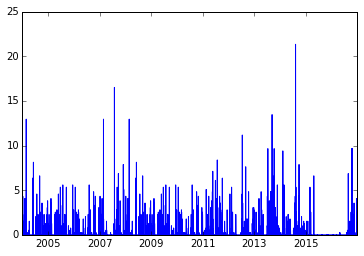

In [204]:
# MOSP
mspts = pd.DatetimeIndex(start = msp01.index.min(),end = msp01.index.max(),freq = 'H')#H
print msp01.shape
msp02 = msp01.reindex(mspts, columns=['Date','Time','PCPcum','PCP1','RNMX1','SPC_uS'])
print msp02.shape
plt.plot(msp02.index,msp02.PCP1)

### Plot hourly PPT at each location (mm)

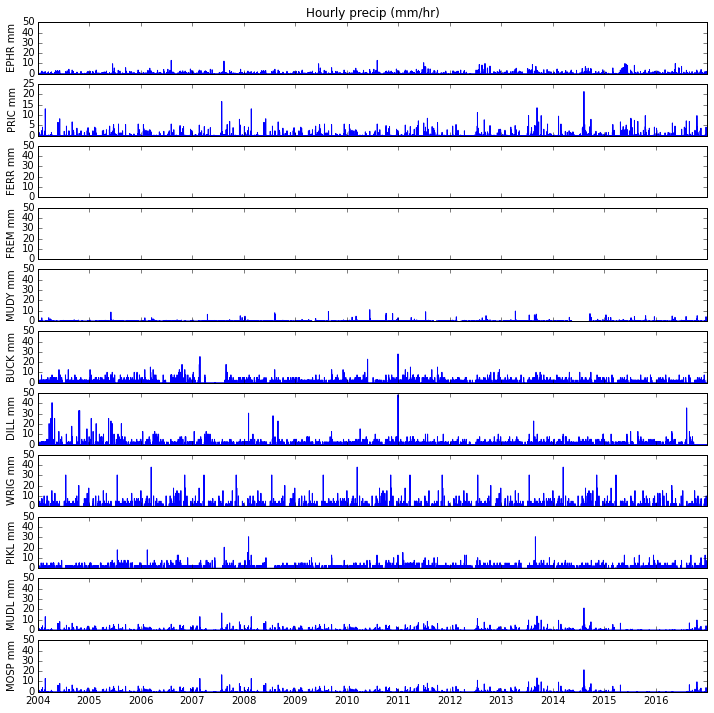

In [205]:
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR mm')
plt.title('Hourly precip (mm/hr)')
plt.plot(eph02.index, eph02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC mm')
plt.plot(pri02.index, pri02['PCP1'], c='b', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR mm')
# plt.plot(fer02.index, fer02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM mm')
# plt.plot(fre02.index, fre02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY mm')
plt.plot(mud02.index, mud02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK mm')
plt.plot(buc02.index, buc02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL mm')
plt.plot(dil02.index, dil02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG mm')
plt.plot(wri02.index, wri02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL mm')
plt.plot(pik02.index, pik02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL mm')
plt.plot(mdl02.index, mdl02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP mm')
plt.plot(msp02.index, msp02['PCP1'], c='b', label="Hourly")
plt.ylim(0,50)

fig01.savefig('07_AllSites_hr_PCP_mm.png', bbox_inches='tight')

### COPY DATA FROM OTHER STATIONS FOR FULL SET

In [206]:
# Need PCPcum,RNMX1,PCP1,TMP1,MAX1,MIN1,WND1,HMD1,DPT1,SLR1 for all
# EPHRAIM - PCP,TMP,WND,HMD,DPT,SLR (5/9/07-10/1/15)

# PRICE - PCP,TMP,WND,HMD,DPT,SLR (5/17/07-10/1/15)
# All 5 parameters over the entire period so no need to fill dataset
print 'EPHR',eph02.dtypes
print 'PRIC',pri02.dtypes

# FERRON - TMP Only (No PCP,WND,HMD,DPT,SLR) (2/25/13-10/1/15)
fer02['PCPcum'] = mud02['PCPcum'].astype(float)# FERR PCP from MUDY
fer02['RNMX1'] = mud02['RNMX1'].astype(float)# FERR PCP from MUDY
fer02['PCP1'] = mud02['PCP1'].astype(float)# FERR PCP from MUDY
fer02['WND1'] = mud02['WND1'].astype(float)# FERR WND from MUDY
fer02['HMD1'] = mud02['HMD1'].astype(float)# FERR HMD from MUDY
fer02['DPT1'] = mud02['DPT1'].astype(float)# FERR DPT from MUDY
fer02['SLR1'] = eph02['SLR1'].astype(float)# FERR SLR from EPHR
print 'FERR',fer02.dtypes

# FREMONT - TMP,WND,HMD,DPT,SLR (No PCP) (12/26/08-10/1/15)
fre02['PCPcum'] = mud02['PCPcum'].astype(float)# FREM PCP from MUDY
fre02['RNMX1'] = mud02['RNMX1'].astype(float)# FREM PCP from MUDY
fre02['PCP1'] = mud02['PCP1'].astype(float)# FREM PCP from MUDY
print 'FREM',fre02.dtypes

# MUDDY - PCP,TMP,WND,HMD,DPT (No SLR) (3/31/05-10/1/15)
mud02['SLR1'] = eph02['SLR1'].astype(float)# MUDY SLR from EPHR
print 'MUDY',mud02.dtypes

# BUCK - PCP,TMP (No SLR,WND,HMD,DPT) (1/1/04-10/1/15)
buc02['WND1'] = mud02['WND1'].astype(float)# BUCK WND from MUDY
buc02['HMD1'] = mud02['HMD1'].astype(float)# BUCK HMD from MUDY
buc02['DPT1'] = mud02['DPT1'].astype(float)# BUCK DPT from MUDY
buc02['SLR1'] = eph02['SLR1'].astype(float)# BUCK SLR from EPHR
print 'BUCK',buc02.dtypes

# DILL - PCP,TMP (No SLR,WND,HMD,DPT) (1/1/04-10/1/15)
# print fre01['WND1']
dil02['WND1'] = fre02['WND1'].astype(float)# DILL WND from FREM
dil02['HMD1'] = fre02['HMD1'].astype(float)# DILL HMD from FREM
dil02['DPT1'] = fre02['DPT1'].astype(float)# DILL DPT from FREM
dil02['SLR1'] = fre02['SLR1'].astype(float)# DILL SLR from FREM
print 'DILL',dil02.dtypes

# WRIG - PCP,TMP (No SLR,WND,HMD,DPT) (7/19/12-10/1/15)
wri02['WND1'] = mud02['WND1'].astype(float)# WRIG WND from MUDY
wri02['HMD1'] = mud02['HMD1'].astype(float)# WRIG HMD from MUDY
wri02['DPT1'] = mud02['DPT1'].astype(float)# WRIG DPT from MUDY
wri02['SLR1'] = eph02['SLR1'].astype(float)# WRIG SLR from EPHR
print 'WRIG',wri02.dtypes

# PIKL - PCP,TMP (No SLR,WND,HMD,DPT) (1/1/04-10/1/15)
pik02['WND1'] = fre02['WND1'].astype(float)# PIKL WND from FREM
pik02['HMD1'] = fre02['HMD1'].astype(float)# PIKL HMD from FREM
pik02['DPT1'] = fre02['DPT1'].astype(float)# PIKL DPT from FREM
pik02['SLR1'] = fre02['SLR1'].astype(float)# PIKL SLR from FREM
print 'PIKL',pik02.dtypes

# MUDL - PCP (No SLR,WND,HMD,DPT,TMP) (4/28/15-10/1/15)
mdl02['MIN1'] = mud02['MIN1'].astype(float)# MUDL TMPMIN from MUDY
mdl02['MAX1'] = mud02['MAX1'].astype(float)# MUDL TMPMAX from MUDY
mdl02['TMP1'] = mud02['TMP1'].astype(float)# MUDL TMPAVE from MUDY
mdl02['WND1'] = fre02['WND1'].astype(float)# MUDL WND from FREM
mdl02['HMD1'] = fre02['HMD1'].astype(float)# MUDL HMD from FREM
mdl02['DPT1'] = fre02['DPT1'].astype(float)# MUDL DPT from FREM
mdl02['SLR1'] = fre02['SLR1'].astype(float)# MUDL SLR from FREM
mdl02['Q_CFS'] = mdl02['Q_CFS'].astype(float)
print 'MUDL',mdl02.dtypes

# MOSP - PCP (No SLR,WND,HMD,DPT,TMP) (4/29/15-10/1/15)
msp02['MIN1'] = mud02['MIN1'].astype(float)# MOSP TMPMIN from MUDY
msp02['MAX1'] = mud02['MAX1'].astype(float)# MOSP TMPMAX from MUDY
msp02['TMP1'] = mud02['TMP1'].astype(float)# MOSP TMPAVE from MUDY
msp02['WND1'] = fre02['WND1'].astype(float)# MOSP WND from FREM
msp02['HMD1'] = fre02['HMD1'].astype(float)# MOSP HMD from FREM
msp02['DPT1'] = fre02['DPT1'].astype(float)# MOSP DPT from FREM
msp02['SLR1'] = fre02['SLR1'].astype(float)# MOSP SLR from FREM
msp02['SPC_uS'] = msp02['SPC_uS'].astype(float)
print 'MOSP',msp02.dtypes

EPHR Date       object
Time       object
PCPcum    float64
PCP1      float64
RNMX1     float64
MAX1      float64
MIN1      float64
TMP1      float64
WND1      float64
HMD1      float64
DPT1      float64
SLR1      float64
dtype: object
PRIC Date       object
Time       object
PCPcum    float64
PCP1      float64
RNMX1     float64
MAX1      float64
MIN1      float64
TMP1      float64
WND1      float64
HMD1      float64
DPT1      float64
SLR1      float64
dtype: object
FERR Date       object
Time       object
MAX1      float64
MIN1      float64
TMP1      float64
PCPcum    float64
RNMX1     float64
PCP1      float64
WND1      float64
HMD1      float64
DPT1      float64
SLR1      float64
dtype: object
FREM Date       object
Time       object
MAX1      float64
MIN1      float64
TMP1      float64
WND1      float64
HMD1      float64
DPT1      float64
SLR1      float64
PCPcum    float64
RNMX1     float64
PCP1      float64
dtype: object
MUDY Date       object
Time       object
PCPcum    float64
P

### List of names at each step for each location

In [207]:
# # original data that came in
# EPHR - ['datetime','Date','Time','PREC.I-1 (in) ','PRCP.H-1 (in) ','TMAX.H-1 (degC) ',
#         'TMIN.H-1 (degC) ','TAVG.H-1 (degC) ','WSPDX.H-1 (mph) ','RHUM.I-1 (pct) ',
#         'DPTP.H-1 (degC) ','SRADV.H-1 (watt) ']
# PRIC - ['datetime','Date','Time','PREC.I-1 (in) ','PRCP.H-1 (in) ','TMAX.H-1 (degC) ',
#         'TMIN.H-1 (degC) ','TAVG.H-1 (degC) ','WSPDX.H-1:124 (mph) ','RHUM.I-1 (pct) ',
#         'DPTP.H-1 (degC) ','SRADV.H-1 (watt) ']
# FERR - ['datetime','Date','Time','TAVG.H-1 (degC) ','TMP MIN C','TMP MAX C']
# FREM - ['datetime','Date','Time','TMP C','MIN1','MAX1','SKNT m/s','RELH %','DWP C',
#         'SOLR W/m*m']
# MUDY - ['datetime','Date','Time','PREC cm','PCP cm','TMP C','MIN1','MAX1','RELH %',
#         'SKNT m/s','DWP C']
# BUCK - ['datetime','Date', 'Time','PCP3 (in)','PCP4 (in)','TOBS.I-1 (degC) ','MIN1','MAX1']
# DILL - ['datetime','Date', 'Time','PCP3 (in)','PCP4 (in)','TOBS.I-1 (degC) ','MIN1','MAX1']
# PIKL - ['datetime','Date', 'Time','PCP3 (in)','PCP4 (in)','TOBS.I-1 (degC) ','MIN1','MAX1']
# WRIG - ['datetime','Date', 'Time','PCP3 (in)','PCP4 (in)','TOBS.I-1 (degC) ','MIN1','MAX1']
# MUDL - ['datetime','Date', 'Time', 'PCP_in','Q_CFS','SPC_uS']
# MOSP - ['datetime','Date', 'Time', 'PCP_in','SPC_uS']

# # data with rename and converted units
# EPHR - ['datetime','Date','Time','PREC.I-1 (in) ','PCPcum','PRCP.H-1 (in) ','RNMX1','PCP1','MAX1',
#         'MIN1','TMP1','WSPDX.H-1 (mph) ','WND1','HMD1','DPT1','SRADV.H-1 (watt) ','SLR1']
# PRIC - ['datetime','Date','Time','PREC.I-1 (in) ','PCPcum','PRCP.H-1 (in) ','RNMX1','PCP1','MAX1',
#         'MIN1','TMP1','WSPDX.H-1:124 (mph) ','WND1','HMD1','DPT1','SRADV.H-1 (watt) ','SLR1']
# FERR - ['datetime','Date','Time','TMP1','MIN1','MAX1']
# FREM - ['datetime','Date','Time','TMP1','MIN1','MAX1','WND1','HMD1','DPT1','SOLR W/m*m','SLR1']
# MUDY - ['datetime','Date','Time','PREC cm','PCPcum','PCP cm','PCP1','RNMX1','TMP1','MIN1','MAX1','WND1','HMD1','DPT1']
# BUCK - ['datetime','Date','Time','PCP3 (in)','PCPcum','PCP4 (in)','PCP1','RNMX1','TMP1','MIN1','MAX1']
# DILL - ['datetime','Date','Time','PCP3 (in)','PCPcum','PCP4 (in)','PCP1','RNMX1','TMP1','MIN1','MAX1']
# PIKL - ['datetime','Date','Time','PCP3 (in)','PCPcum','PCP4 (in)','PCP1','RNMX1','TMP1','MIN1','MAX1']
# WRIG - ['datetime','Date','Time','PCP3 (in)','PCPcum','PCP4 (in)','PCP1','RNMX1','TMP1','MIN1','MAX1']
# MUDL - ['datetime','Date','Time','PCP_in','PCP1','RNMX1','Q_CFS','SPC_uS']
# MOSP - ['datetime','Date','Time','PCP_in','PCP1','RNMX1','SPC_uS']

# # reindexed data to 5 min TS, the rest dropped off
# EPHR - ['datetime','Date','Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']
# PRIC - ['datetime','Date','Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']
# FERR - ['datetime','Date','Time','TMP1','MIN1','MAX1']
# FREM - ['datetime','Date','Time','TMP1','MIN1','MAX1','WND1','HMD1','DPT1','SLR1']
# MUDY - ['datetime','Date','Time','PCPcum','PCP1','RNMX1','TMP1','MIN1','MAX1','WND1','HMD1','DPT1']
# BUCK - ['datetime','Date', 'Time','PCPcum','PCP1','RNMX1','TMP1','MIN1','MAX1']
# DILL - ['datetime','Date', 'Time','PCPcum','PCP1','RNMX1','TMP1','MIN1','MAX1']
# PIKL - ['datetime','Date', 'Time','PCPcum','PCP1','RNMX1','TMP1','MIN1','MAX1']
# WRIG - ['datetime','Date', 'Time','PCPcum','PCP1','RNMX1','TMP1','MIN1','MAX1']
# MUDL - ['datetime','Date', 'Time','PCP1','RNMX1','Q_CFS','SPC_uS']
# MOSP - ['datetime','Date', 'Time','PCP1','RNMX1','SPC_uS']

# # data copied to missing for complete sets at each location
# EPHR - ['datetime','Date','Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']
# PRIC - ['datetime','Date','Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']
# FERR - ['datetime','Date','Time','PCPcum(MUDY)','RNMX1(MUDY)','PCP1(MUDY)','MAX1','MIN1','TMP1',
#         'WND1(MUDY)','HMD1(MUDY)','DPT1(MUDY)','SLR1(EPHR)']
# FREM - ['datetime','Date','Time','PCPcum(MUDY)','RNMX1(MUDY)','PCP1(MUDY)','MAX1','MIN1',
#         'TMP1','WND1','HMD1','DPT1','SLR1']
# MUDY - ['datetime','Date','Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1','HMD1',
#         'DPT1','SLR1(EPHR)']
# BUCK - ['datetime','Date', 'Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1(MUDY)',
#         'HMD1(MUDY)','DPT1(MUDY)','SLR1(EPHR)']
# DILL - ['datetime','Date', 'Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1(FREM)',
#         'HMD1(FREM)','DPT1(FREM)','SLR1(FREM)']
# PIKL - ['datetime','Date', 'Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1(FREM)',
#         'HMD1(FREM)','DPT1(FREM)','SLR1(FREM)']
# WRIG - ['datetime','Date', 'Time','PCPcum','RNMX1','PCP1','MAX1','MIN1','TMP1','WND1(MUDY)',
#         'HMD1(MUDY)','DPT1(MUDY)','SLR1(EPHR)']
# MUDL - ['datetime','Date', 'Time','RNMX1','PCP1','MAX1(MUDY)','MIN1(MUDY)','TMP1(MUDY)',
#         'WND1(FREM)','HMD1(FREM)','DPT1(FREM)','SLR1(FREM)','Q_CFS','SPC_uS']
# MOSP - ['datetime','Date', 'Time','RNMX1','PCP1','MAX1(MUDY)','MIN1(MUDY)','TMP1(MUDY)',
#         'WND1(FREM)','HMD1(FREM)','DPT1(FREM)','SLR1(FREM)','SPC_uS']

In [208]:
# # OK, now there are several new index points (and some old possibly) with no data (NaN).
# # Replace NaN with the closest available value and linearly interpolate across series of NaNs
# mudt1 = mud02
# print mudt1.TMP1[400:420]
# mask = np.isnan(mudt1.TMP1)
# mudt1.TMP1[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), mudt1.TMP1[~mask])
# print 'okay, fix it'
# print mudt1.TMP1[400:420]
# mudt1.to_csv('D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\Locations\MuddyCr\MUDtest.csv'.format(index))
# plt.plot(mudt1.index, mudt1['TMP1'], c='b')

# mudt2 = mud02
# print mudt2[400:420]
# for i,var in enumerate(['PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']):
#     mask = np.isnan(mudt2[var])
#     mudt2[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), mudt2[var][~mask])
# # mask = np.isnan(mudt2)
# # mudt2[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), mudt2[~mask])
# print 'okay, fix it'
# print mudt2[400:420]
# plt.plot(mudt2.index, mudt2['WND1'], c='k')

### Linearly interpolate over NaN values each site and parameter

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http:

                          Date   Time  PCPcum  PCP1  RNMX1  MAX1  MIN1  TMP1  \
2004-01-17 16:00:00  1/17/2004  16:00    16.3     0      0   2.8   2.8   2.8   
2004-01-17 17:00:00  1/17/2004  17:00    16.3     0      0   1.1   1.1   1.1   
2004-01-17 18:00:00  1/17/2004  18:00    16.3     0      0  -1.1  -1.1  -1.1   
2004-01-17 19:00:00  1/17/2004  19:00    16.3     0      0  -4.4  -4.4  -4.4   
2004-01-17 20:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-17 21:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-17 22:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-17 23:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-18 00:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-18 01:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-18 02:00:00        NaN    NaN     NaN   NaN    NaN   NaN   NaN   NaN   
2004-01-18 03:00:00        NaN    NaN   

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


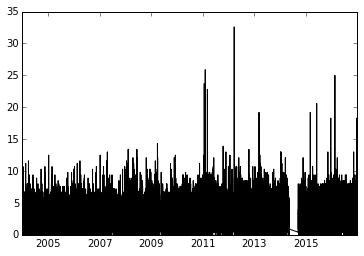

In [209]:
# OK, now there are several new index points (and some old possibly) with no data (NaN).
# Replace NaN with the closest available value and linearly interpolate across series of NaNs
print mud02[400:420]
print 'okay, fill and linearly interpolate between NaNs'
for i,var in enumerate(['PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']):
#     dfmi['one']['second']
#     dfmi.loc[:,('one','second')]
    mask = np.isnan(eph02[var])
    eph02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), eph02[var][~mask])
    mask = np.isnan(pri02[var])
    pri02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), pri02[var][~mask])
    mask = np.isnan(fer02[var])
    fer02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), fer02[var][~mask])
    mask = np.isnan(fre02[var])
    fre02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), fre02[var][~mask])
    mask = np.isnan(mud02[var])
    mud02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), mud02[var][~mask])
    mask = np.isnan(buc02[var])
    buc02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), buc02[var][~mask])
    mask = np.isnan(dil02[var])
    dil02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), dil02[var][~mask])
    mask = np.isnan(wri02[var])
    wri02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), wri02[var][~mask])
    mask = np.isnan(pik02[var])
    pik02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), pik02[var][~mask])
    mask = np.isnan(mdl02[var])
    mdl02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), mdl02[var][~mask])
    mask = np.isnan(msp02[var])
    msp02[var][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), msp02[var][~mask])
print mud02[400:420]
plt.plot(mud02.index, mud02['WND1'], c='k')

### Plot hourly interpol PPT, RNMX at each location (mm)

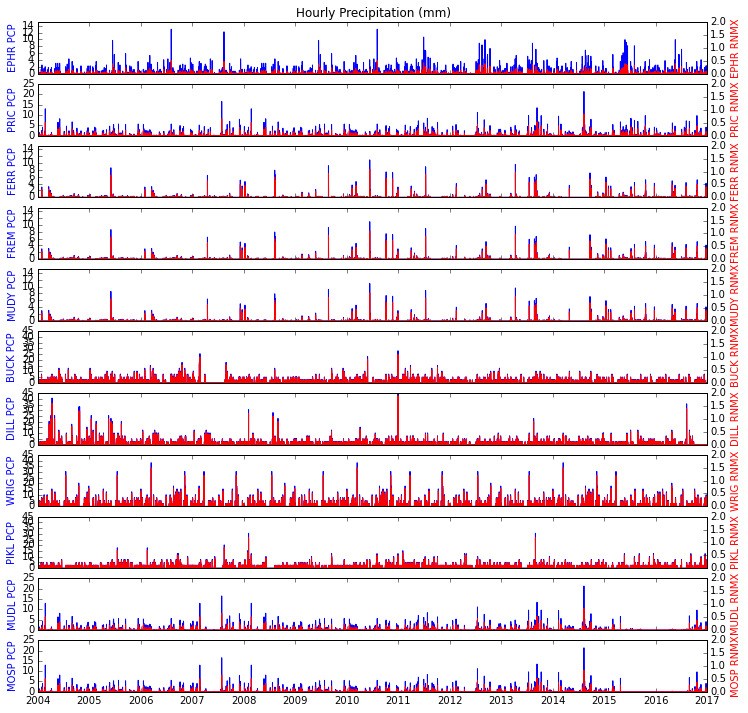

In [210]:
# Precipitation and Max Rain
fig01 = plt.figure(figsize=(12, 12))
ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax1 = fig01.add_subplot(11,1,1)
ax2 = ax1.twinx()
plt.title('Hourly Precipitation (mm)')
ax1.plot(eph02.index, eph02['PCP1'], c='b', label="Hourly")
ax2.plot(eph02.index, eph02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('EPHR PCP', color='b')
ax2.set_ylabel('EPHR RNMX', color='r')
ax1.set_ylim(0,15), ax2.set_ylim(0,2)
ax1.set_xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
                '2012','2013','2014','2015','2016','2017'))
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,2, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(pri02.index, pri02['PCP1'], c='b', label="Hourly")
ax2.plot(pri02.index, pri02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('PRIC PCP', color='b')
ax2.set_ylabel('PRIC RNMX', color='r')
ax1.set_ylim(0,25), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,3, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(fer02.index, fer02['PCP1'], c='b', label="Hourly")
ax2.plot(fer02.index, fer02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('FERR PCP', color='b')
ax2.set_ylabel('FERR RNMX', color='r')
ax1.set_ylim(0,15), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,4, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(fre02.index, fre02['PCP1'], c='b', label="Hourly")
ax2.plot(fre02.index, fre02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('FREM PCP', color='b')
ax2.set_ylabel('FREM RNMX', color='r')
ax1.set_ylim(0,15), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,5, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(mud02.index, mud02['PCP1'], c='b', label="Hourly")
ax2.plot(mud02.index, mud02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('MUDY PCP', color='b')
ax2.set_ylabel('MUDY RNMX', color='r')
ax1.set_ylim(0,15), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,6, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(buc02.index, buc02['PCP1'], c='b', label="Hourly")
ax2.plot(buc02.index, buc02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('BUCK PCP', color='b')
ax2.set_ylabel('BUCK RNMX', color='r')
ax1.set_ylim(0,45), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,7, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(dil02.index, dil02['PCP1'], c='b', label="Hourly")
ax2.plot(dil02.index, dil02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('DILL PCP', color='b')
ax2.set_ylabel('DILL RNMX', color='r')
ax1.set_ylim(0,45), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,8, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(wri02.index, wri02['PCP1'], c='b', label="Hourly")
ax2.plot(wri02.index, wri02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('WRIG PCP', color='b')
ax2.set_ylabel('WRIG RNMX', color='r')
ax1.set_ylim(0,45), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,9, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(pik02.index, pik02['PCP1'], c='b', label="Hourly")
ax2.plot(pik02.index, pik02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('PIKL PCP', color='b')
ax2.set_ylabel('PIKL RNMX', color='r')
ax1.set_ylim(0,45), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,10, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(mdl02.index, mdl02['PCP1'], c='b', label="Hourly")
ax2.plot(mdl02.index, mdl02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('MUDL PCP', color='b')
ax2.set_ylabel('MUDL RNMX', color='r')
ax1.set_ylim(0,25), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,11, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(msp02.index, msp02['PCP1'], c='b', label="Hourly")
ax2.plot(msp02.index, msp02['RNMX1'], c='r', label="Hourly")
ax1.set_ylabel('MOSP PCP', color='b')
ax2.set_ylabel('MOSP RNMX', color='r')
ax1.set_ylim(0,25), ax2.set_ylim(0,2)
plt.setp(ax1.get_xticklabels(), visible=True)

fig01.savefig('07_AllSites_hr_PCP_RNMX.png', bbox_inches='tight')

### Plot hourly interpol PPT and PPT cumm at each location (mm)

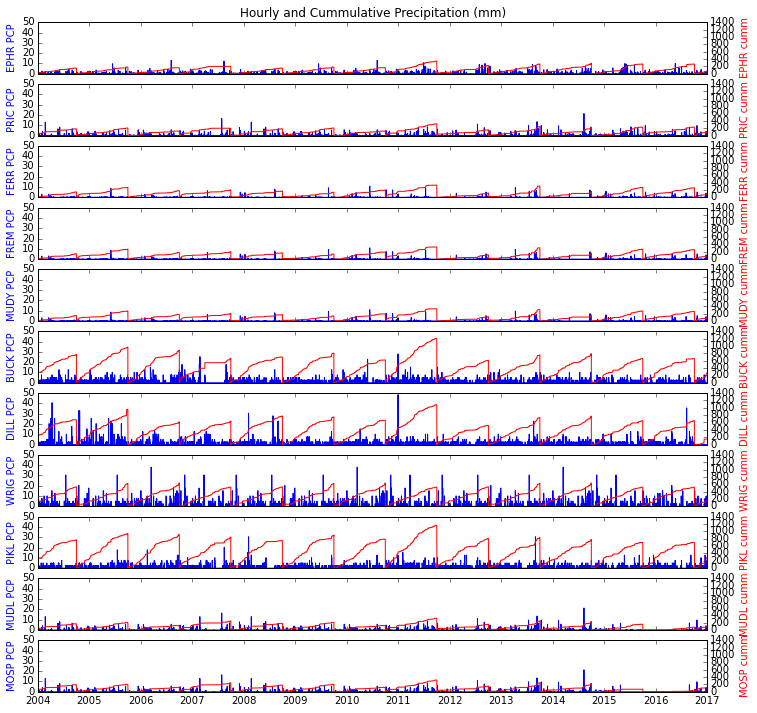

In [211]:
# Precipitation and Max Rain
fig01 = plt.figure(figsize=(12, 12))
ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax1 = fig01.add_subplot(11,1,1)
ax2 = ax1.twinx()
plt.title('Hourly and Cummulative Precipitation (mm)')
ax1.plot(eph02.index, eph02['PCP1'], c='b', label="Hourly")
ax2.plot(eph02.index, eph02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('EPHR PCP', color='b')
ax2.set_ylabel('EPHR cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
ax1.set_xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
                '2012','2013','2014','2015','2016','2017'))
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,2, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(pri02.index, pri02['PCP1'], c='b', label="Hourly")
ax2.plot(pri02.index, pri02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('PRIC PCP', color='b')
ax2.set_ylabel('PRIC cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,3, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(fer02.index, fer02['PCP1'], c='b', label="Hourly")
ax2.plot(fer02.index, fer02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('FERR PCP', color='b')
ax2.set_ylabel('FERR cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,4, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(fre02.index, fre02['PCP1'], c='b', label="Hourly")
ax2.plot(fre02.index, fre02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('FREM PCP', color='b')
ax2.set_ylabel('FREM cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,5, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(mud02.index, mud02['PCP1'], c='b', label="Hourly")
ax2.plot(mud02.index, mud02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('MUDY PCP', color='b')
ax2.set_ylabel('MUDY cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,6, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(buc02.index, buc02['PCP1'], c='b', label="Hourly")
ax2.plot(buc02.index, buc02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('BUCK PCP', color='b')
ax2.set_ylabel('BUCK cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,7, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(dil02.index, dil02['PCP1'], c='b', label="Hourly")
ax2.plot(dil02.index, dil02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('DILL PCP', color='b')
ax2.set_ylabel('DILL cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,8, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(wri02.index, wri02['PCP1'], c='b', label="Hourly")
ax2.plot(wri02.index, wri02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('WRIG PCP', color='b')
ax2.set_ylabel('WRIG cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,9, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(pik02.index, pik02['PCP1'], c='b', label="Hourly")
ax2.plot(pik02.index, pik02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('PIKL PCP', color='b')
ax2.set_ylabel('PIKL cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,10, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(mdl02.index, mdl02['PCP1'], c='b', label="Hourly")
ax2.plot(mdl02.index, mdl02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('MUDL PCP', color='b')
ax2.set_ylabel('MUDL cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,11, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(msp02.index, msp02['PCP1'], c='b', label="Hourly")
ax2.plot(msp02.index, msp02['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('MOSP PCP', color='b')
ax2.set_ylabel('MOSP cumm', color='r')
ax1.set_ylim(0,50), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=True)

fig01.savefig('07_AllSites_hr_PCP_and_cumm.png', bbox_inches='tight')

### Plot hourly interpol TMP at each location (C)

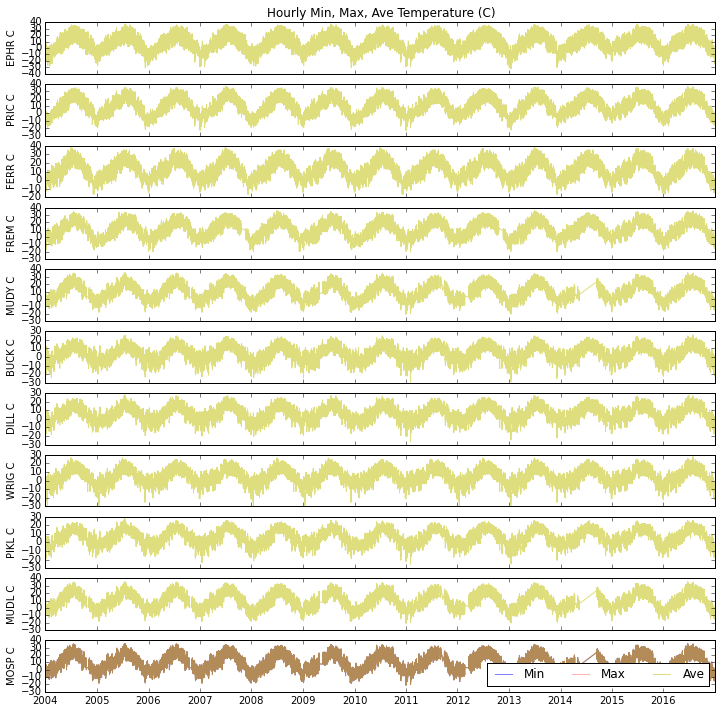

In [212]:
# Temperature
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR C')
plt.title('Hourly Min, Max, Ave Temperature (C)')
# plt.plot(eph02.index, eph02['MIN1'], c='b', label="Min", alpha=0.2)
# plt.plot(eph02.index, eph02['MAX1'], c='r', label="Max", alpha=0.2)
plt.plot(eph02.index, eph02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC C')
# plt.plot(pri02.index, pri02['MIN1'], c='b', label="Min", alpha=0.1)
# plt.plot(pri02.index, pri02['MAX1'], c='r', label="Max", alpha=0.1)
plt.plot(pri02.index, pri02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR C')
# plt.plot(fer02.index, fer02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(fer02.index, fer02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(fer02.index, fer02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM C')
# plt.plot(fre02.index, fre02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(fre02.index, fre02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(fre02.index, fre02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY C')
# plt.plot(mud02.index, mud02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(mud02.index, mud02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(mud02.index, mud02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK C')
# plt.plot(buc02.index, buc02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(buc02.index, buc02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(buc02.index, buc02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL C')
# plt.plot(dil02.index, dil02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(dil02.index, dil02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(dil02.index, dil02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG C')
# plt.plot(wri02.index, wri02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(wri02.index, wri02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(wri02.index, wri02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL C')
# plt.plot(pik02.index, pik02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(pik02.index, pik02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(pik02.index, pik02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL C')
# plt.plot(mdl02.index, mdl02['MIN1'], c='b', label="Min", alpha=0.5)
# plt.plot(mdl02.index, mdl02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(mdl02.index, mdl02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP C')
plt.plot(msp02.index, msp02['MIN1'], c='b', label="Min", alpha=0.5)
plt.plot(msp02.index, msp02['MAX1'], c='r', label="Max", alpha=0.3)
plt.plot(msp02.index, msp02['TMP1'], c='y', label="Ave", alpha=0.5)
plt.legend(loc='best', ncol=3)

fig01.savefig('07_AllSites_TMP_C.png', bbox_inches='tight')

### Plot hourly interpol WND at each location (m/s)

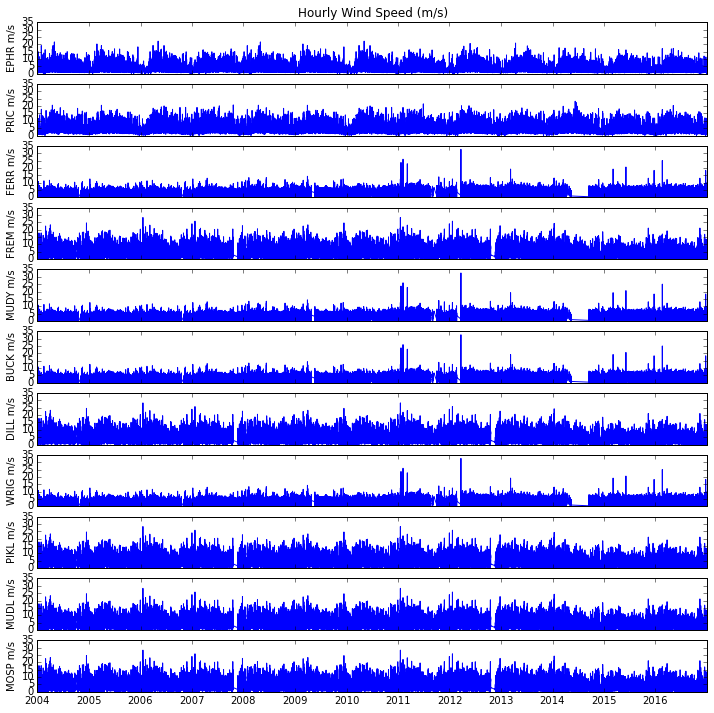

In [213]:
# Wind Speed
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR m/s')
plt.title('Hourly Wind Speed (m/s)')
plt.plot(eph02.index, eph02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC m/s')
plt.plot(pri02.index, pri02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR m/s')
plt.plot(fer02.index, fer02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM m/s')
plt.plot(fre02.index, fre02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY m/s')
plt.plot(mud02.index, mud02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK m/s')
plt.plot(buc02.index, buc02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL m/s')
plt.plot(dil02.index, dil02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG m/s')
plt.plot(wri02.index, wri02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL m/s')
plt.plot(pik02.index, pik02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL m/s')
plt.plot(mdl02.index, mdl02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP m/s')
plt.plot(msp02.index, msp02['WND1'], c='b', label="Hourly")
ax.set_ylim(0,35)

fig01.savefig('07_AllSites_WND_m_s.png', bbox_inches='tight')

### Plot hourly interpol HMD at each location (%)

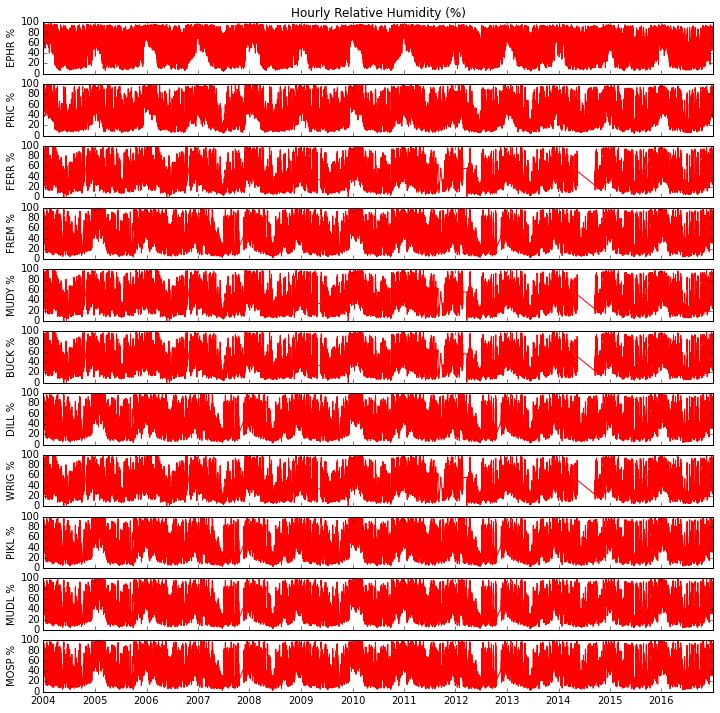

In [214]:
# Relative Humidity
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR %')
plt.title('Hourly Relative Humidity (%)')
plt.plot(eph02.index, eph02['HMD1'], c='r', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC %')
plt.plot(pri02.index, pri02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR %')
plt.plot(fer02.index, fer02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM %')
plt.plot(fre02.index, fre02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY %')
plt.plot(mud02.index, mud02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK %')
plt.plot(buc02.index, buc02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL %')
plt.plot(dil02.index, dil02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG %')
plt.plot(wri02.index, wri02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL %')
plt.plot(pik02.index, pik02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL %')
plt.plot(mdl02.index, mdl02['HMD1'], c='r', label="Hourly")
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP %')
plt.plot(msp02.index, msp02['HMD1'], c='r', label="Hourly")

fig01.savefig('07_AllSites_HMD_%.png', bbox_inches='tight')

### Plot hourly interpol DPT at each location (C)

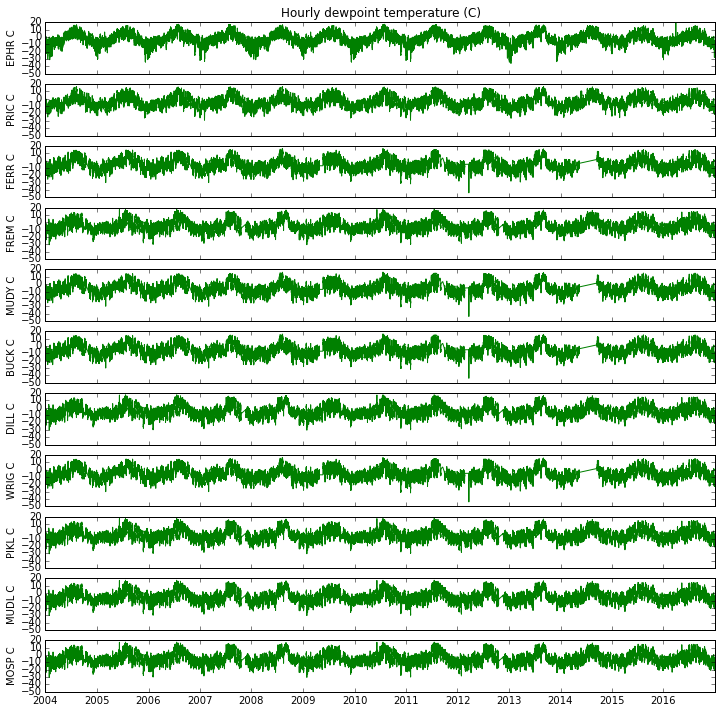

In [215]:
# Dewpoint
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR C')
plt.title('Hourly dewpoint temperature (C)')
plt.plot(eph02.index, eph02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC C')
plt.plot(pri02.index, pri02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR C')
plt.plot(fer02.index, fer02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM C')
plt.plot(fre02.index, fre02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY C')
plt.plot(mud02.index, mud02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK C')
plt.plot(buc02.index, buc02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL C')
plt.plot(dil02.index, dil02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG C')
plt.plot(wri02.index, wri02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL C')
plt.plot(pik02.index, pik02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL C')
plt.plot(mdl02.index, mdl02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP C')
plt.plot(msp02.index, msp02['DPT1'], c='g', label="Hourly")
ax.set_ylim(-50,20)

fig01.savefig('07_AllSites_DPT_C.png', bbox_inches='tight')

### Plot hourly interpol SLR at each location (MJ/m2-hr)

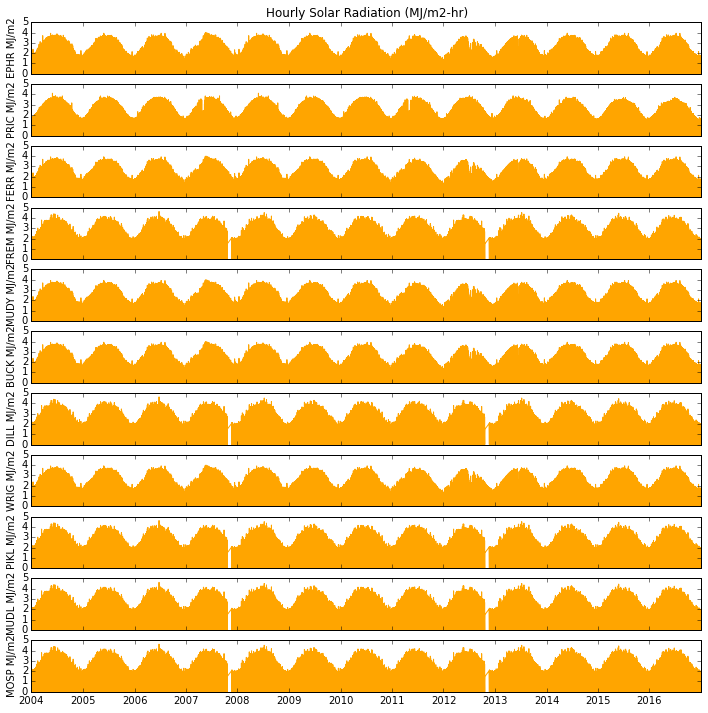

In [216]:
# Solar Radiation
fig01 = plt.figure(figsize=(12, 12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax = fig01.add_subplot(11,1,1)
plt.ylabel('EPHR MJ/m2')
plt.title('Hourly Solar Radiation (MJ/m2-hr)')
plt.plot(eph02.index, eph02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(11,1,2, sharex=ax0)
plt.ylabel('PRIC MJ/m2')
plt.plot(pri02.index, pri02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,3, sharex=ax0)
plt.ylabel('FERR MJ/m2')
plt.plot(fer02.index, fer02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,4, sharex=ax0)
plt.ylabel('FREM MJ/m2')
plt.plot(fre02.index, fre02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,5, sharex=ax0)
plt.ylabel('MUDY MJ/m2')
plt.plot(mud02.index, mud02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,6, sharex=ax0)
plt.ylabel('BUCK MJ/m2')
plt.plot(buc02.index, buc02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,7, sharex=ax0)
plt.ylabel('DILL MJ/m2')
plt.plot(dil02.index, dil02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,8, sharex=ax0)
plt.ylabel('WRIG MJ/m2')
plt.plot(wri02.index, wri02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,9, sharex=ax0)
plt.ylabel('PIKL MJ/m2')
plt.plot(pik02.index, pik02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,10, sharex=ax0)
plt.ylabel('MUDL MJ/m2')
plt.plot(mdl02.index, mdl02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)
plt.xticks(visible=False)

ax = fig01.add_subplot(11,1,11, sharex=ax0)
plt.ylabel('MOSP MJ/m2')
plt.plot(msp02.index, msp02['SLR1'], c='orange', label="Hourly")
ax.set_ylim(0,5)

fig01.savefig('07_AllSites_SLR_MJ_m2-hr.png', bbox_inches='tight')

### RESAMPLE DF FOR DIFFERENT INTERVALS

In [217]:
# EPHRAIM
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
eph03 = eph02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
eph04 = eph03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
eph05 = eph04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
eph06 = eph05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
# eph04.to_csv(os.path.join(current, 'Ephraim', 'Ephraim_dy.csv')) # daily summaries
print eph04.dtypes
eph03.to_excel(os.path.join(current, 'Ephraim', 'EPHRhr.xlsx'))
eph04.to_excel(os.path.join(current, 'Ephraim', 'EPHRdy.xlsx'))
eph05.to_excel(os.path.join(current, 'Ephraim', 'EPHRmo.xlsx'))
eph06.to_excel(os.path.join(current, 'Ephraim', 'EPHRyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [218]:
# PRICE
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
pri03 = pri02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
pri04 = pri03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
pri05 = pri04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
pri06 = pri05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print pri05.dtypes
pri03.to_excel(os.path.join(current, 'Price', 'PRIChr.xlsx'))
pri04.to_excel(os.path.join(current, 'Price', 'PRICdy.xlsx'))
pri05.to_excel(os.path.join(current, 'Price', 'PRICmo.xlsx'))
pri06.to_excel(os.path.join(current, 'Price', 'PRICyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [219]:
# FERRON
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
fer03 = fer02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
fer04 = fer03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
fer05 = fer04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
fer06 = fer05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print fer04.dtypes
fer03.to_excel(os.path.join(current, 'FerronCr', 'FERRhr.xlsx'))
fer04.to_excel(os.path.join(current, 'FerronCr', 'FERRdy.xlsx'))
fer05.to_excel(os.path.join(current, 'FerronCr', 'FERRmo.xlsx'))
fer06.to_excel(os.path.join(current, 'FerronCr', 'FERRyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [220]:
# FREMONT
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
fre03 = fre02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
fre04 = fre03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
fre05 = fre04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
fre06 = fre05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print fre04.dtypes
fre03.to_excel(os.path.join(current, 'Fremont', 'FREMhr.xlsx'))
fre04.to_excel(os.path.join(current, 'Fremont', 'FREMdy.xlsx'))
fre05.to_excel(os.path.join(current, 'Fremont', 'FREMmo.xlsx'))
fre06.to_excel(os.path.join(current, 'Fremont', 'FREMyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [221]:
# MUDDY
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
mud03 = mud02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
mud04 = mud03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum}) 
mud05 = mud04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
mud06 = mud05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print mud04.dtypes
mud03.to_excel(os.path.join(current, 'MuddyCr', 'MUDYhr.xlsx'))
mud04.to_excel(os.path.join(current, 'MuddyCr', 'MUDYdy.xlsx'))
mud05.to_excel(os.path.join(current, 'MuddyCr', 'MUDYmo.xlsx'))
mud06.to_excel(os.path.join(current, 'MuddyCr', 'MUDYyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [222]:
# BUCK
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
buc03 = buc02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
buc04 = buc03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
buc05 = buc04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
buc06 = buc05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print buc04.dtypes
buc03.to_excel(os.path.join(current, 'BuckFlat', 'BUCKhr.xlsx'))
buc04.to_excel(os.path.join(current, 'BuckFlat', 'BUCKdy.xlsx'))
buc05.to_excel(os.path.join(current, 'BuckFlat', 'BUCKmo.xlsx'))
buc06.to_excel(os.path.join(current, 'BuckFlat', 'BUCKyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [223]:
# DILL
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
dil03 = dil02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
dil04 = dil03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
dil05 = dil04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
dil06 = dil05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print dil04.dtypes
dil03.to_excel(os.path.join(current, 'DillsCamp', 'DILLhr.xlsx'))
dil04.to_excel(os.path.join(current, 'DillsCamp', 'DILLdy.xlsx'))
dil05.to_excel(os.path.join(current, 'DillsCamp', 'DILLmo.xlsx'))
dil06.to_excel(os.path.join(current, 'DillsCamp', 'DILLyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [224]:
# WRIG
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
wri03 = wri02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
wri04 = wri03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
wri05 = wri04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
wri06 = wri05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print wri04.dtypes
wri03.to_excel(os.path.join(current, 'WrigleyCr', 'WRIGhr.xlsx'))
wri04.to_excel(os.path.join(current, 'WrigleyCr', 'WRIGdy.xlsx'))
wri05.to_excel(os.path.join(current, 'WrigleyCr', 'WRIGmo.xlsx'))
wri06.to_excel(os.path.join(current, 'WrigleyCr', 'WRIGyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [225]:
# PIKL
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
pik03 = pik02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
pik04 = pik03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum})
pik05 = pik04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
pik06 = pik05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean})
print pik05.dtypes
pik03.to_excel(os.path.join(current, 'PickleKeg', 'PIKLhr.xlsx'))
pik04.to_excel(os.path.join(current, 'PickleKeg', 'PIKLdy.xlsx'))
pik05.to_excel(os.path.join(current, 'PickleKeg', 'PIKLmo.xlsx'))
pik06.to_excel(os.path.join(current, 'PickleKeg', 'PIKLyr.xlsx'))

RNMX1     float64
SLR1      float64
HMD1      float64
DPT1      float64
MIN1      float64
WND1      float64
MAX1      float64
PCPcum    float64
TMP1      float64
PCP1      float64
dtype: object


In [226]:
mdl02.describe()

PCPcum           PCP1          RNMX1        Q_CFS        SPC_uS  \
count  113976.000000  113976.000000  113976.000000  8833.000000  10473.000000   
mean       90.821874       0.020509       0.000807     4.353836   2325.033228   
std        65.441648       0.256959       0.010116    10.114865   1306.576885   
min         0.000000       0.000000       0.000000     0.010000      1.000000   
25%        43.434000       0.000000       0.000000     0.630000   1370.000000   
50%        81.280000       0.000000       0.000000     1.000000   2310.000000   
75%       132.842000       0.000000       0.000000     3.000000   3360.000000   
max       319.278000      21.336000       0.840000   270.000000   5830.000000   

                MIN1           MAX1           TMP1           WND1  \
count  113976.000000  113976.000000  113976.000000  113976.000000   
mean        8.980944       8.980944       8.980944       4.957351   
std        10.583669      10.583669      10.583669       3.217962   
min       -21.100000     -21.100000     -21.100000       0.000000   
25%         0.600000       0.600000       0.600000       2.500000   
50%         8.300000       8.300000       8.300000       4.400000   
75%        17.200000      17.200000      17.200000       6.700000   
max        35.600000      35.600000      35.600000      28.300000   

                HMD1           DPT1           SLR1  
count  113976.000000  113976.000000  113976.000000  
mean       44.168614      -4.642271       0.773070  
std        23.658167       7.112501       1.076166  
min         3.000000     -30.390000       0.000000  
25%        24.000000      -9.390000       0.000000  
50%        41.000000      -5.500000       0.035280  
75%        63.000000      -0.390000       1.452600  
max       100.000000      17.560000       4.626000

In [227]:
# MUDL
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
mdl03 = mdl02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean,
                                 'Q_CFS':np.mean,'SPC_uS':np.mean})
mdl04 = mdl03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum,
                                 'Q_CFS':np.mean,'SPC_uS':np.mean})
mdl05 = mdl04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean,
                                 'Q_CFS':np.mean,'SPC_uS':np.mean})
mdl06 = mdl05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean,
                                 'Q_CFS':np.mean,'SPC_uS':np.mean})
print mdl04.dtypes
mdl03.to_excel(os.path.join(current, 'MuddyCrLow', 'MUDLhr.xlsx'))
mdl04.to_excel(os.path.join(current, 'MuddyCrLow', 'MUDLdy.xlsx'))
mdl05.to_excel(os.path.join(current, 'MuddyCrLow', 'MUDLmo.xlsx'))
mdl06.to_excel(os.path.join(current, 'MuddyCrLow', 'MUDLyr.xlsx'))

HMD1      float64
MAX1      float64
RNMX1     float64
SLR1      float64
WND1      float64
SPC_uS    float64
TMP1      float64
PCP1      float64
Q_CFS     float64
DPT1      float64
MIN1      float64
PCPcum    float64
dtype: object


In [228]:
# MOSP
# Resample daily 'D', weekly 'W', month-end 'M', and year-end 'A' frequency for output
msp03 = msp02.resample('H', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean,
                                 'SPC_uS':np.mean})
msp04 = msp03.resample('D', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.max,'MIN1':np.min,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.sum,
                                 'SPC_uS':np.mean})
msp05 = msp04.resample('M', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean,
                                 'SPC_uS':np.mean})
msp06 = msp05.resample('A', how={'PCPcum':np.max,'RNMX1':np.max,'PCP1':np.sum,'MAX1':np.mean,'MIN1':np.mean,
                                 'TMP1':np.mean,'WND1':np.mean,'HMD1':np.mean,'DPT1':np.mean,'SLR1':np.mean,
                                 'SPC_uS':np.mean})
print msp04.dtypes
msp03.to_excel(os.path.join(current, 'MolenSeep', 'MOSPhr.xlsx'))
msp04.to_excel(os.path.join(current, 'MolenSeep', 'MOSPdy.xlsx'))
msp05.to_excel(os.path.join(current, 'MolenSeep', 'MOSPmo.xlsx'))
msp06.to_excel(os.path.join(current, 'MolenSeep', 'MOSPyr.xlsx'))

HMD1      float64
MAX1      float64
RNMX1     float64
SLR1      float64
WND1      float64
SPC_uS    float64
TMP1      float64
PCP1      float64
DPT1      float64
MIN1      float64
PCPcum    float64
dtype: object


In [229]:
# print eph03.index[0:10]

In [230]:
# print mdl03.dtypes

### Group same parameter between all locations

In [231]:
# Combine each parameter individually to get range and average over time
# vars = ['PCPcum','PCP1','RNMX1','MAX1','MIN1','TMP1','WND1','HMD1','DPT1','SLR1']
sites = ['eph03','pri03','fer03','fre03','mud03','mdl03','msp03','buc03','dil03','wri03','pik03']

pcpcumgrp = pd.concat([eph03.PCPcum, pri03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, fer03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, fre03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, mud03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, mdl03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, msp03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, buc03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, dil03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, wri03.PCPcum], axis=1)
pcpcumgrp = pd.concat([pcpcumgrp, pik03.PCPcum], axis=1)
pcpcumgrp.columns = sites

pcp1grp = pd.concat([eph03.PCP1, pri03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, fer03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, fre03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, mud03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, mdl03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, msp03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, buc03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, dil03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, wri03.PCP1], axis=1)
pcp1grp = pd.concat([pcp1grp, pik03.PCP1], axis=1)
pcp1grp.columns = sites

rnmx1grp = pd.concat([eph03.RNMX1, pri03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, fer03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, fre03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, mud03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, mdl03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, msp03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, buc03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, dil03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, wri03.RNMX1], axis=1)
rnmx1grp = pd.concat([rnmx1grp, pik03.RNMX1], axis=1)
rnmx1grp.columns = sites

max1grp = pd.concat([eph03.MAX1, pri03.MAX1], axis=1)
max1grp = pd.concat([max1grp, fer03.MAX1], axis=1)
max1grp = pd.concat([max1grp, fre03.MAX1], axis=1)
max1grp = pd.concat([max1grp, mud03.MAX1], axis=1)
max1grp = pd.concat([max1grp, mdl03.MAX1], axis=1)
max1grp = pd.concat([max1grp, msp03.MAX1], axis=1)
max1grp = pd.concat([max1grp, buc03.MAX1], axis=1)
max1grp = pd.concat([max1grp, dil03.MAX1], axis=1)
max1grp = pd.concat([max1grp, wri03.MAX1], axis=1)
max1grp = pd.concat([max1grp, pik03.MAX1], axis=1)
max1grp.columns = sites

min1grp = pd.concat([eph03.MIN1, pri03.MIN1], axis=1)
min1grp = pd.concat([min1grp, fer03.MIN1], axis=1)
min1grp = pd.concat([min1grp, fre03.MIN1], axis=1)
min1grp = pd.concat([min1grp, mud03.MIN1], axis=1)
min1grp = pd.concat([min1grp, mdl03.MIN1], axis=1)
min1grp = pd.concat([min1grp, msp03.MIN1], axis=1)
min1grp = pd.concat([min1grp, buc03.MIN1], axis=1)
min1grp = pd.concat([min1grp, dil03.MIN1], axis=1)
min1grp = pd.concat([min1grp, wri03.MIN1], axis=1)
min1grp = pd.concat([min1grp, pik03.MIN1], axis=1)
min1grp.columns = sites

tmp1grp = pd.concat([eph03.TMP1, pri03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, fer03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, fre03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, mud03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, mdl03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, msp03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, buc03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, dil03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, wri03.TMP1], axis=1)
tmp1grp = pd.concat([tmp1grp, pik03.TMP1], axis=1)
tmp1grp.columns = sites

wnd1grp = pd.concat([eph03.WND1, pri03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, fer03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, fre03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, mud03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, mdl03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, msp03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, buc03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, dil03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, wri03.WND1], axis=1)
wnd1grp = pd.concat([wnd1grp, pik03.WND1], axis=1)
wnd1grp.columns = sites

hmd1grp = pd.concat([eph03.HMD1, pri03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, fer03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, fre03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, mud03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, mdl03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, msp03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, buc03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, dil03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, wri03.HMD1], axis=1)
hmd1grp = pd.concat([hmd1grp, pik03.HMD1], axis=1)
hmd1grp.columns = sites

dpt1grp = pd.concat([eph03.DPT1, pri03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, fer03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, fre03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, mud03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, mdl03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, msp03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, buc03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, dil03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, wri03.DPT1], axis=1)
dpt1grp = pd.concat([dpt1grp, pik03.DPT1], axis=1)
dpt1grp.columns = sites

slr1grp = pd.concat([eph03.SLR1, pri03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, fer03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, fre03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, mud03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, mdl03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, msp03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, buc03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, dil03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, wri03.SLR1], axis=1)
slr1grp = pd.concat([slr1grp, pik03.SLR1], axis=1)
slr1grp.columns = sites
# print max1grp

### Create range boundaries for each parameter over groups

In [232]:
# Okay, now plot max to min of each param with fill between, then plot the ave
# print pcp1grp.describe(), pcp1grp.eph03.min()
snot = ['buc03','dil03','wri03','pik03']
lows = ['eph03','pri03','fer03','fre03','mud03','mdl03','msp03']

pcpcumgrp['TOTmin'] = pcpcumgrp.min(axis=1)
pcpcumgrp['TOTmax'] = pcpcumgrp.max(axis=1)
pcpcumgrp['TOTave'] = pcpcumgrp.mean(axis=1)
pcpcumgrp['SNOmin'] = pcpcumgrp[snot].min(axis=1)
pcpcumgrp['SNOmax'] = pcpcumgrp[snot].max(axis=1)
pcpcumgrp['SNOave'] = pcpcumgrp[snot].mean(axis=1)
pcpcumgrp['LOWmin'] = pcpcumgrp[lows].min(axis=1)
pcpcumgrp['LOWmax'] = pcpcumgrp[lows].max(axis=1)
pcpcumgrp['LOWave'] = pcpcumgrp[lows].mean(axis=1)

pcp1grp['TOTmin'] = pcp1grp.min(axis=1)
pcp1grp['TOTmax'] = pcp1grp.max(axis=1)
pcp1grp['TOTave'] = pcp1grp.mean(axis=1)
pcp1grp['SNOmin'] = pcp1grp[snot].min(axis=1)
pcp1grp['SNOmax'] = pcp1grp[snot].max(axis=1)
pcp1grp['SNOave'] = pcp1grp[snot].mean(axis=1)
pcp1grp['LOWmin'] = pcp1grp[lows].min(axis=1)
pcp1grp['LOWmax'] = pcp1grp[lows].max(axis=1)
pcp1grp['LOWave'] = pcp1grp[lows].mean(axis=1)

rnmx1grp['TOTmin'] = rnmx1grp.min(axis=1)
rnmx1grp['TOTmax'] = rnmx1grp.max(axis=1)
rnmx1grp['TOTave'] = rnmx1grp.mean(axis=1)
rnmx1grp['SNOmin'] = rnmx1grp[snot].min(axis=1)
rnmx1grp['SNOmax'] = rnmx1grp[snot].max(axis=1)
rnmx1grp['SNOave'] = rnmx1grp[snot].mean(axis=1)
rnmx1grp['LOWmin'] = rnmx1grp[lows].min(axis=1)
rnmx1grp['LOWmax'] = rnmx1grp[lows].max(axis=1)
rnmx1grp['LOWave'] = rnmx1grp[lows].mean(axis=1)

min1grp['TOTmin'] = min1grp.min(axis=1)
min1grp['TOTmax'] = min1grp.max(axis=1)
min1grp['TOTave'] = min1grp.mean(axis=1)
min1grp['SNOmin'] = min1grp[snot].min(axis=1)
min1grp['SNOmax'] = min1grp[snot].max(axis=1)
min1grp['SNOave'] = min1grp[snot].mean(axis=1)
min1grp['LOWmin'] = min1grp[lows].min(axis=1)
min1grp['LOWmax'] = min1grp[lows].max(axis=1)
min1grp['LOWave'] = min1grp[lows].mean(axis=1)

max1grp['TOTmin'] = max1grp.min(axis=1)
max1grp['TOTmax'] = max1grp.max(axis=1)
max1grp['TOTave'] = max1grp.mean(axis=1)
max1grp['SNOmin'] = max1grp[snot].min(axis=1)
max1grp['SNOmax'] = max1grp[snot].max(axis=1)
max1grp['SNOave'] = max1grp[snot].mean(axis=1)
max1grp['LOWmin'] = max1grp[lows].min(axis=1)
max1grp['LOWmax'] = max1grp[lows].max(axis=1)
max1grp['LOWave'] = max1grp[lows].mean(axis=1)

tmp1grp['TOTmin'] = tmp1grp.min(axis=1)
tmp1grp['TOTmax'] = tmp1grp.max(axis=1)
tmp1grp['TOTave'] = tmp1grp.mean(axis=1)
tmp1grp['SNOmin'] = tmp1grp[snot].min(axis=1)
tmp1grp['SNOmax'] = tmp1grp[snot].max(axis=1)
tmp1grp['SNOave'] = tmp1grp[snot].mean(axis=1)
tmp1grp['LOWmin'] = tmp1grp[lows].min(axis=1)
tmp1grp['LOWmax'] = tmp1grp[lows].max(axis=1)
tmp1grp['LOWave'] = tmp1grp[lows].mean(axis=1)

wnd1grp['TOTmin'] = wnd1grp.min(axis=1)
wnd1grp['TOTmax'] = wnd1grp.max(axis=1)
wnd1grp['TOTave'] = wnd1grp.mean(axis=1)
wnd1grp['SNOmin'] = wnd1grp[snot].min(axis=1)
wnd1grp['SNOmax'] = wnd1grp[snot].max(axis=1)
wnd1grp['SNOave'] = wnd1grp[snot].mean(axis=1)
wnd1grp['LOWmin'] = wnd1grp[lows].min(axis=1)
wnd1grp['LOWmax'] = wnd1grp[lows].max(axis=1)
wnd1grp['LOWave'] = wnd1grp[lows].mean(axis=1)

hmd1grp['TOTmin'] = hmd1grp.min(axis=1)
hmd1grp['TOTmax'] = hmd1grp.max(axis=1)
hmd1grp['TOTave'] = hmd1grp.mean(axis=1)
hmd1grp['SNOmin'] = hmd1grp[snot].min(axis=1)
hmd1grp['SNOmax'] = hmd1grp[snot].max(axis=1)
hmd1grp['SNOave'] = hmd1grp[snot].mean(axis=1)
hmd1grp['LOWmin'] = hmd1grp[lows].min(axis=1)
hmd1grp['LOWmax'] = hmd1grp[lows].max(axis=1)
hmd1grp['LOWave'] = hmd1grp[lows].mean(axis=1)

dpt1grp['TOTmin'] = dpt1grp.min(axis=1)
dpt1grp['TOTmax'] = dpt1grp.max(axis=1)
dpt1grp['TOTave'] = dpt1grp.mean(axis=1)
dpt1grp['SNOmin'] = dpt1grp[snot].min(axis=1)
dpt1grp['SNOmax'] = dpt1grp[snot].max(axis=1)
dpt1grp['SNOave'] = dpt1grp[snot].mean(axis=1)
dpt1grp['LOWmin'] = dpt1grp[lows].min(axis=1)
dpt1grp['LOWmax'] = dpt1grp[lows].max(axis=1)
dpt1grp['LOWave'] = dpt1grp[lows].mean(axis=1)

slr1grp['TOTmin'] = slr1grp.min(axis=1)
slr1grp['TOTmax'] = slr1grp.max(axis=1)
slr1grp['TOTave'] = slr1grp.mean(axis=1)
slr1grp['SNOmin'] = slr1grp[snot].min(axis=1)
slr1grp['SNOmax'] = slr1grp[snot].max(axis=1)
slr1grp['SNOave'] = slr1grp[snot].mean(axis=1)
slr1grp['LOWmin'] = slr1grp[lows].min(axis=1)
slr1grp['LOWmax'] = slr1grp[lows].max(axis=1)
slr1grp['LOWave'] = slr1grp[lows].mean(axis=1)
print slr1grp[0:11]

                        eph03     pri03     fer03    fre03     mud03    mdl03  \
2004-01-01 00:00:00  0.000000  0.000000  0.000000  0.00036  0.000000  0.00036   
2004-01-01 01:00:00  0.000000  0.000000  0.000000  0.00036  0.000000  0.00036   
2004-01-01 02:00:00  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2004-01-01 03:00:00  0.000000  0.000000  0.000000  0.00036  0.000000  0.00036   
2004-01-01 04:00:00  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2004-01-01 05:00:00  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2004-01-01 06:00:00  0.000000  0.000000  0.000000  0.00036  0.000000  0.00036   
2004-01-01 07:00:00  0.000000  0.000000  0.000000  0.00000  0.000000  0.00000   
2004-01-01 08:00:00  0.009324  0.017712  0.009324  0.02052  0.009324  0.02052   
2004-01-01 09:00:00  0.289800  0.361080  0.289800  0.20340  0.289800  0.20340   
2004-01-01 10:00:00  0.872280  0.875520  0.872280  0.62568  0.872280  0.62568   

                       msp0

### Plot the range and ave of each hr variable between groups

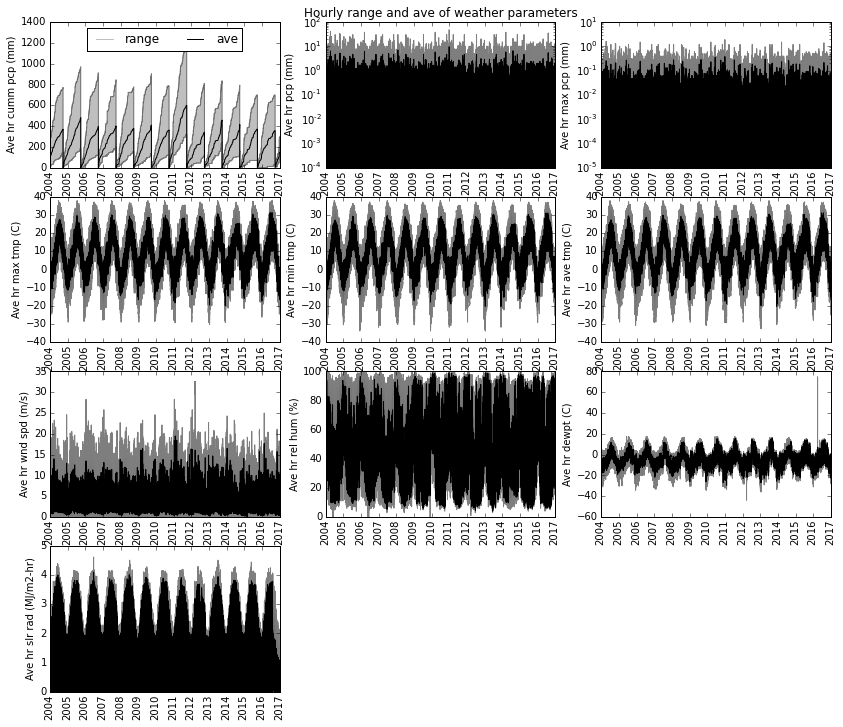

In [233]:
fig01 = plt.figure(figsize=(14,12))
ax = fig01.add_subplot(4,3,1)
plt.ylabel('Ave hr cumm pcp (mm)')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.TOTmin, pcpcumgrp.TOTmax, facecolor='gray', alpha = 0.5, label='range')
ax.plot(pcpcumgrp.index, pcpcumgrp.TOTmin, c='gray', alpha = 0.5, label='range')
ax.plot(pcpcumgrp.index, pcpcumgrp.TOTave, c='k', label='ave')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax.legend(bbox_to_anchor=[0.5, 1], loc='upper center', ncol=2)

ax = fig01.add_subplot(4,3,2)
plt.ylabel('Ave hr pcp (mm)')
plt.title('Hourly range and ave of weather parameters')
plt.fill_between(pcp1grp.eph03.index, pcp1grp.TOTmin, pcp1grp.TOTmax, facecolor='gray', alpha = 0.5, label='range')
plt.plot(pcp1grp.index, pcp1grp.TOTave, c='k', label='ave')
plt.yscale('log')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,3)
plt.ylabel('Ave hr max pcp (mm)')
plt.fill_between(rnmx1grp.eph03.index, rnmx1grp.TOTmin, rnmx1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(rnmx1grp.index, rnmx1grp.TOTave, c='k', label='ave')
plt.yscale('log')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,4)
plt.ylabel('Ave hr max tmp (C)')
plt.fill_between(max1grp.eph03.index, max1grp.TOTmin, max1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(max1grp.index, max1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,5)
plt.ylabel('Ave hr min tmp (C)')
plt.fill_between(min1grp.eph03.index, min1grp.TOTmin, min1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(min1grp.index, min1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,6)
plt.ylabel('Ave hr ave tmp (C)')
plt.fill_between(tmp1grp.eph03.index, tmp1grp.TOTmin, tmp1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(tmp1grp.index, tmp1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,7)
plt.ylabel('Ave hr wnd spd (m/s)')
plt.fill_between(wnd1grp.eph03.index, wnd1grp.TOTmin, wnd1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(wnd1grp.index, wnd1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,8)
plt.ylabel('Ave hr rel hum (%)')
plt.fill_between(hmd1grp.eph03.index, hmd1grp.TOTmin, hmd1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(hmd1grp.index, hmd1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,9)
plt.ylabel('Ave hr dewpt (C)')
plt.fill_between(dpt1grp.eph03.index, dpt1grp.TOTmin, dpt1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(dpt1grp.index, dpt1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,10)
plt.ylabel('Ave hr slr rad (MJ/m2-hr)')
plt.fill_between(slr1grp.eph03.index, slr1grp.TOTmin, slr1grp.TOTmax, 
                 facecolor='gray', alpha = 0.5, label='range')
plt.plot(slr1grp.index, slr1grp.TOTave, c='k', label='ave')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

fig01.savefig('07_Range_ave_all_sites_ea_param.png', bbox_inches='tight')

### Plot the range in hr variables for SNOTEL and Other groups

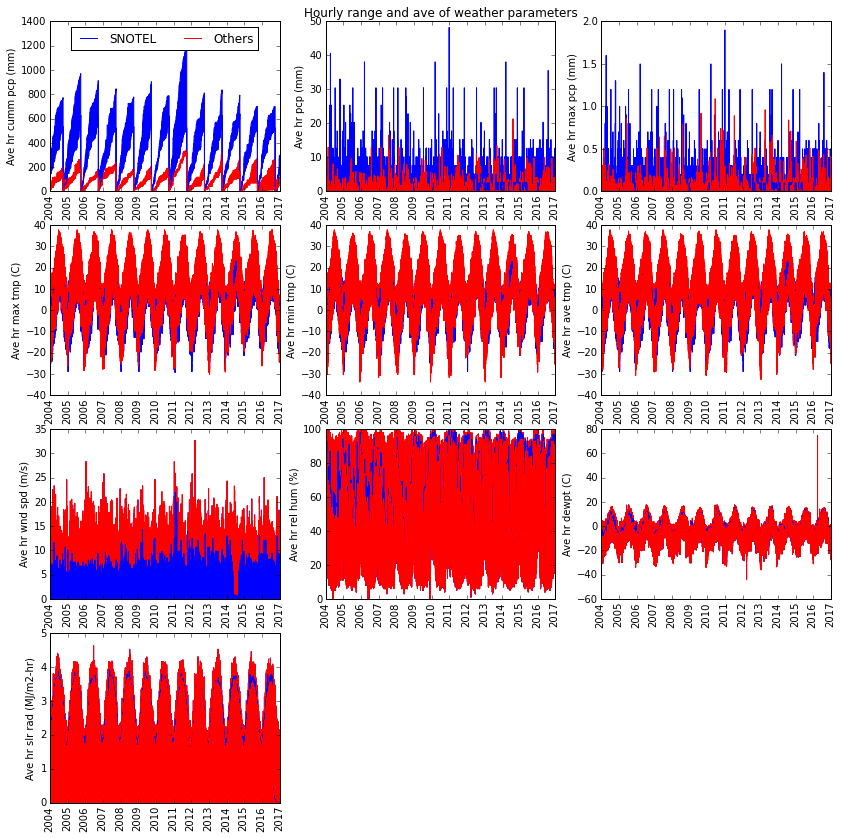

In [234]:
fig01 = plt.figure(figsize=(14,14))
ax = fig01.add_subplot(4,3,1)
plt.ylabel('Ave hr cumm pcp (mm)')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.SNOmin, pcpcumgrp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.LOWmin, pcpcumgrp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(pcpcumgrp.index, pcpcumgrp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(pcpcumgrp.index, pcpcumgrp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax.legend(bbox_to_anchor=[0.5, 1], loc='upper center', ncol=2)

ax = fig01.add_subplot(4,3,2)
plt.ylabel('Ave hr pcp (mm)')
plt.title('Hourly range and ave of weather parameters')
plt.fill_between(pcp1grp.eph03.index, pcp1grp.SNOmin, pcp1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(pcp1grp.eph03.index, pcp1grp.LOWmin, pcp1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(pcp1grp.index, pcp1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(pcp1grp.index, pcp1grp.LOWmin, c='r', alpha = 1, label='Others')
# plt.yscale('log')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,3)
plt.ylabel('Ave hr max pcp (mm)')
plt.fill_between(rnmx1grp.eph03.index, rnmx1grp.SNOmin, rnmx1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(rnmx1grp.eph03.index, rnmx1grp.LOWmin, rnmx1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(rnmx1grp.index, rnmx1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(rnmx1grp.index, rnmx1grp.LOWmin, c='r', alpha = 1, label='Others')
# plt.yscale('log')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,4)
plt.ylabel('Ave hr max tmp (C)')
plt.fill_between(max1grp.eph03.index, max1grp.SNOmin, max1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(max1grp.eph03.index, max1grp.LOWmin, max1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(max1grp.index, max1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(max1grp.index, max1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
            '2012','2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,5)
plt.ylabel('Ave hr min tmp (C)')
plt.fill_between(min1grp.eph03.index, min1grp.SNOmin, min1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(min1grp.eph03.index, min1grp.LOWmin, min1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(min1grp.index, min1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(min1grp.index, min1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,6)
plt.ylabel('Ave hr ave tmp (C)')
plt.fill_between(tmp1grp.eph03.index, tmp1grp.SNOmin, tmp1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(tmp1grp.eph03.index, tmp1grp.LOWmin, tmp1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(tmp1grp.index, tmp1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(tmp1grp.index, tmp1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,7)
plt.ylabel('Ave hr wnd spd (m/s)')
plt.fill_between(wnd1grp.eph03.index, wnd1grp.SNOmin, wnd1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(wnd1grp.eph03.index, wnd1grp.LOWmin, wnd1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(wnd1grp.index, wnd1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(wnd1grp.index, wnd1grp.LOWmin, c='b', alpha = 1, label='SNOTEL')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,8)
plt.ylabel('Ave hr rel hum (%)')
plt.fill_between(hmd1grp.eph03.index, hmd1grp.SNOmin, hmd1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(hmd1grp.eph03.index, hmd1grp.LOWmin, hmd1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(hmd1grp.index, hmd1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(hmd1grp.index, hmd1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,9)
plt.ylabel('Ave hr dewpt (C)')
plt.fill_between(dpt1grp.eph03.index, dpt1grp.SNOmin, dpt1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(dpt1grp.eph03.index, dpt1grp.LOWmin, dpt1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(dpt1grp.index, dpt1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(dpt1grp.index, dpt1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

ax = fig01.add_subplot(4,3,10)
plt.ylabel('Ave hr slr rad (MJ/m2-hr)')
plt.fill_between(slr1grp.eph03.index, slr1grp.SNOmin, slr1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(slr1grp.eph03.index, slr1grp.LOWmin, slr1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(slr1grp.index, slr1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(slr1grp.index, slr1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

fig01.savefig('07_Range_SNOTEL_other_sites_ea_param2.png', bbox_inches='tight')

### Plot the range in hr variables for SNOTEL and Other groups 1 column

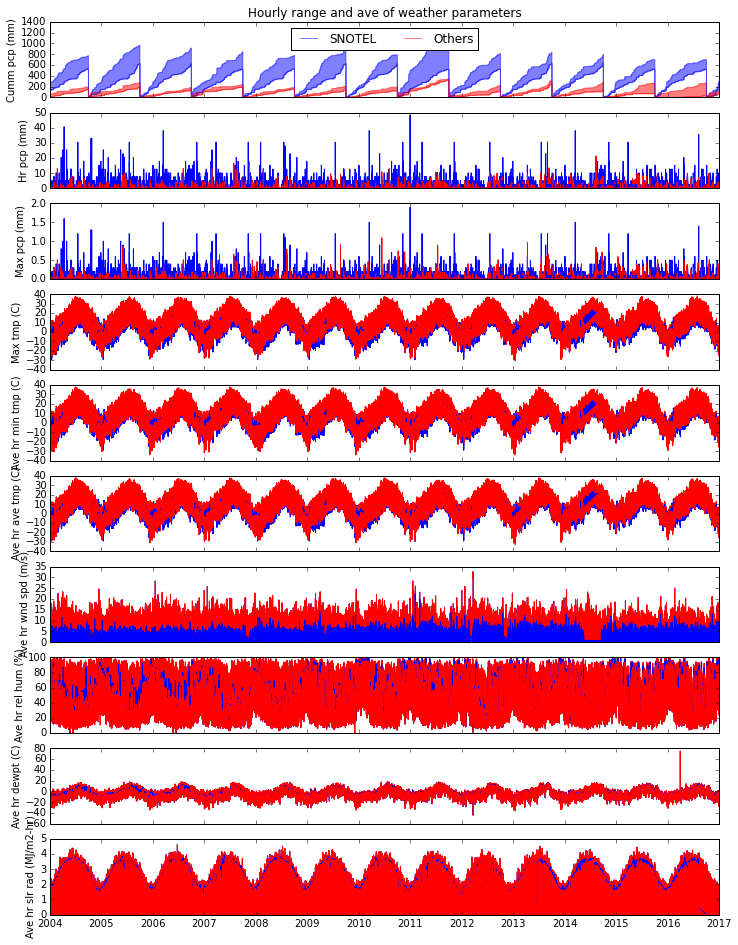

In [235]:
fig01 = plt.figure(figsize=(12,16))
ax = fig01.add_subplot(10,1,1)
plt.title('Hourly range and ave of weather parameters')
plt.ylabel('Cumm pcp (mm)')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.SNOmin, pcpcumgrp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 0.5, label='SNOTEL')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.LOWmin, pcpcumgrp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 0.5, label='Others')
ax.plot(pcpcumgrp.index, pcpcumgrp.SNOmin, c='b', alpha = 0.5, label='SNOTEL')
ax.plot(pcpcumgrp.index, pcpcumgrp.LOWmin, c='r', alpha = 0.5, label='Others')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
ax.legend(bbox_to_anchor=[0.5, 1], loc='upper center', ncol=2)

ax = fig01.add_subplot(10,1,2)
plt.ylabel('Hr pcp (mm)')
plt.fill_between(pcp1grp.eph03.index, pcp1grp.SNOmin, pcp1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(pcp1grp.eph03.index, pcp1grp.LOWmin, pcp1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(pcp1grp.index, pcp1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(pcp1grp.index, pcp1grp.LOWmin, c='r', alpha = 1, label='Others')
# plt.yscale('log')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,3)
plt.ylabel('Max pcp (mm)')
plt.fill_between(rnmx1grp.eph03.index, rnmx1grp.SNOmin, rnmx1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(rnmx1grp.eph03.index, rnmx1grp.LOWmin, rnmx1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(rnmx1grp.index, rnmx1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(rnmx1grp.index, rnmx1grp.LOWmin, c='r', alpha = 1, label='Others')
# plt.yscale('log')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,4)
plt.ylabel('Max tmp (C)')
plt.fill_between(max1grp.eph03.index, max1grp.SNOmin, max1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(max1grp.eph03.index, max1grp.LOWmin, max1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(max1grp.index, max1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(max1grp.index, max1grp.LOWmin, c='r', alpha = 1, label='Others')
# plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,5)
plt.ylabel('Ave hr min tmp (C)')
plt.fill_between(min1grp.eph03.index, min1grp.SNOmin, min1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(min1grp.eph03.index, min1grp.LOWmin, min1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(min1grp.index, min1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(min1grp.index, min1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,6)
plt.ylabel('Ave hr ave tmp (C)')
plt.fill_between(tmp1grp.eph03.index, tmp1grp.SNOmin, tmp1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(tmp1grp.eph03.index, tmp1grp.LOWmin, tmp1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(tmp1grp.index, tmp1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(tmp1grp.index, tmp1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,7)
plt.ylabel('Ave hr wnd spd (m/s)')
plt.fill_between(wnd1grp.eph03.index, wnd1grp.SNOmin, wnd1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(wnd1grp.eph03.index, wnd1grp.LOWmin, wnd1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(wnd1grp.index, wnd1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(wnd1grp.index, wnd1grp.LOWmin, c='b', alpha = 1, label='SNOTEL')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,8)
plt.ylabel('Ave hr rel hum (%)')
plt.fill_between(hmd1grp.eph03.index, hmd1grp.SNOmin, hmd1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(hmd1grp.eph03.index, hmd1grp.LOWmin, hmd1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(hmd1grp.index, hmd1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(hmd1grp.index, hmd1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,9)
plt.ylabel('Ave hr dewpt (C)')
plt.fill_between(dpt1grp.eph03.index, dpt1grp.SNOmin, dpt1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(dpt1grp.eph03.index, dpt1grp.LOWmin, dpt1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(dpt1grp.index, dpt1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(dpt1grp.index, dpt1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

ax = fig01.add_subplot(10,1,10)
plt.ylabel('Ave hr slr rad (MJ/m2-hr)')
plt.fill_between(slr1grp.eph03.index, slr1grp.SNOmin, slr1grp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 1, label='SNOTEL')
plt.fill_between(slr1grp.eph03.index, slr1grp.LOWmin, slr1grp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 1, label='Others')
ax.plot(slr1grp.index, slr1grp.SNOmin, c='b', alpha = 1, label='SNOTEL')
ax.plot(slr1grp.index, slr1grp.LOWmin, c='r', alpha = 1, label='Others')
plt.xticks(visible=False)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)

fig01.savefig('07_Range_SNOTEL_other_sites_ea_param_1col.png', bbox_inches='tight')

### Plot the range in hr PCPcum for SNOTEL and Other groups

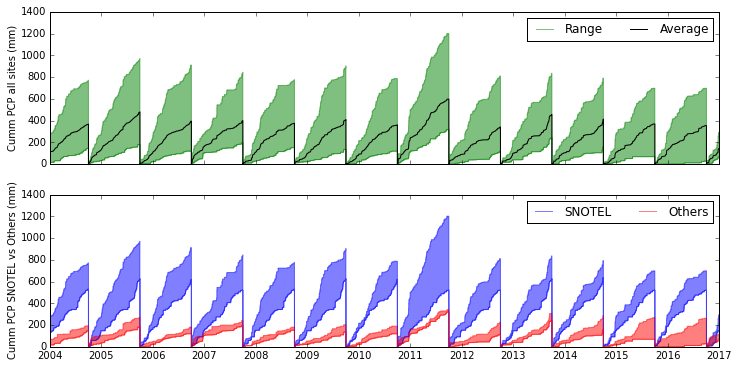

In [236]:
fig01 = plt.figure(figsize=(12, 6))
ax = fig01.add_subplot(2,1,1)
plt.ylabel('Cumm PCP all sites (mm)')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.TOTmin, pcpcumgrp.TOTmax, 
                 facecolor='g', edgecolor='g', alpha = 0.5, label='Range')
ax.plot(pcpcumgrp.index, pcpcumgrp.TOTmin, c='g', alpha = 0.5, label='Range')
ax.plot(pcpcumgrp.index, pcpcumgrp.TOTave, c='k', label='Average')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
ax.legend(loc='upper right', ncol=2)

ax = fig01.add_subplot(2,1,2)
# plt.title('Hourly range and ave of weather parameters')
plt.ylabel('Cumm PCP SNOTEL vs Others (mm)')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.SNOmin, pcpcumgrp.SNOmax, 
                 facecolor='b', edgecolor='b', alpha = 0.5, label='SNOTEL')
plt.fill_between(pcpcumgrp.eph03.index, pcpcumgrp.LOWmin, pcpcumgrp.LOWmax, 
                 facecolor='r', edgecolor='r', alpha = 0.5, label='Others')
ax.plot(pcpcumgrp.index, pcpcumgrp.SNOmin, c='b', alpha = 0.5, label='SNOTEL')
ax.plot(pcpcumgrp.index, pcpcumgrp.LOWmin, c='r', alpha = 0.5, label='Others')
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
ax.legend(loc='upper right', ncol=2)

fig01.savefig('07_Cumm_PCP_Range_Ave_SNOTEL_other_sites.png', bbox_inches='tight')

### Calculate Statistics each network, each resample

In [237]:
# Get hourly statistics
ephhrstats = eph03.describe()
prihrstats = pri03.describe()
ferhrstats = fer03.describe()
frehrstats = fre03.describe()
mudhrstats = mud03.describe()
buchrstats = buc03.describe()
dilhrstats = dil03.describe()
wrihrstats = wri03.describe()
pikhrstats = pik03.describe()
mdlhrstats = mdl03.describe()
msphrstats = msp03.describe()

# Append hourly to single dataframe
hr1 = ephhrstats.append(prihrstats)#, ignore_index=False, verify_integrity=False)
hr2 = hr1.append(ferhrstats)#, ignore_index=False, verify_integrity=False)
hr3 = hr2.append(frehrstats)#, ignore_index=False, verify_integrity=False)
hr4 = hr3.append(mudhrstats)#, ignore_index=False, verify_integrity=False)
hr5 = hr4.append(buchrstats)#, ignore_index=False, verify_integrity=False)
hr6 = hr5.append(dilhrstats)#, ignore_index=False, verify_integrity=False)
hr7 = hr6.append(wrihrstats)#, ignore_index=False, verify_integrity=False)
hr8 = hr7.append(pikhrstats)#, ignore_index=False, verify_integrity=False)
hr9 = hr8.append(mdlhrstats)#, ignore_index=False, verify_integrity=False)
hr10 = hr9.append(msphrstats)#, ignore_index=False, verify_integrity=False)

# Get daily statistics
ephdystats = eph04.describe()
pridystats = pri04.describe()
ferdystats = fer04.describe()
fredystats = fre04.describe()
muddystats = mud04.describe()
bucdystats = buc04.describe()
dildystats = dil04.describe()
wridystats = wri04.describe()
pikdystats = pik04.describe()
mdldystats = mdl04.describe()
mspdystats = msp04.describe()

# Append daily to single dataframe
dy1 = ephdystats.append(pridystats, ignore_index=False, verify_integrity=False)
dy2 = dy1.append(ferdystats, ignore_index=False, verify_integrity=False)
dy3 = dy2.append(fredystats, ignore_index=False, verify_integrity=False)
dy4 = dy3.append(muddystats, ignore_index=False, verify_integrity=False)
dy5 = dy4.append(bucdystats, ignore_index=False, verify_integrity=False)
dy6 = dy5.append(dildystats, ignore_index=False, verify_integrity=False)
dy7 = dy6.append(wridystats, ignore_index=False, verify_integrity=False)
dy8 = dy7.append(pikdystats, ignore_index=False, verify_integrity=False)
dy9 = dy8.append(mdldystats, ignore_index=False, verify_integrity=False)
dy10 = dy9.append(mspdystats, ignore_index=False, verify_integrity=False)

# Get monthly statistics
ephmostats = eph05.describe()
primostats = pri05.describe()
fermostats = fer05.describe()
fremostats = fre05.describe()
mudmostats = mud05.describe()
bucmostats = buc05.describe()
dilmostats = dil05.describe()
wrimostats = wri05.describe()
pikmostats = pik05.describe()
mdlmostats = mdl05.describe()
mspmostats = msp05.describe()

# Append monthly to single dataframe
mo1 = ephmostats.append(primostats, ignore_index=False, verify_integrity=False)
mo2 = mo1.append(fermostats, ignore_index=False, verify_integrity=False)
mo3 = mo2.append(fremostats, ignore_index=False, verify_integrity=False)
mo4 = mo3.append(mudmostats, ignore_index=False, verify_integrity=False)
mo5 = mo4.append(bucmostats, ignore_index=False, verify_integrity=False)
mo6 = mo5.append(dilmostats, ignore_index=False, verify_integrity=False)
mo7 = mo6.append(wrimostats, ignore_index=False, verify_integrity=False)
mo8 = mo7.append(pikmostats, ignore_index=False, verify_integrity=False)
mo9 = mo8.append(mdlmostats, ignore_index=False, verify_integrity=False)
mo10 = mo9.append(mspmostats, ignore_index=False, verify_integrity=False)

# Write appended dataframes to Excel files
#ephr_apex = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\WeatherImport\FEdata'
hr10.to_excel((os.path.join(ephr_apex,'HrStats.xlsx')))
dy10.to_excel((os.path.join(ephr_apex,'DyStats.xlsx')))
mo10.to_excel((os.path.join(ephr_apex,'MoStats.xlsx')))

### Plot PCP at all sites on hourly and daily interval

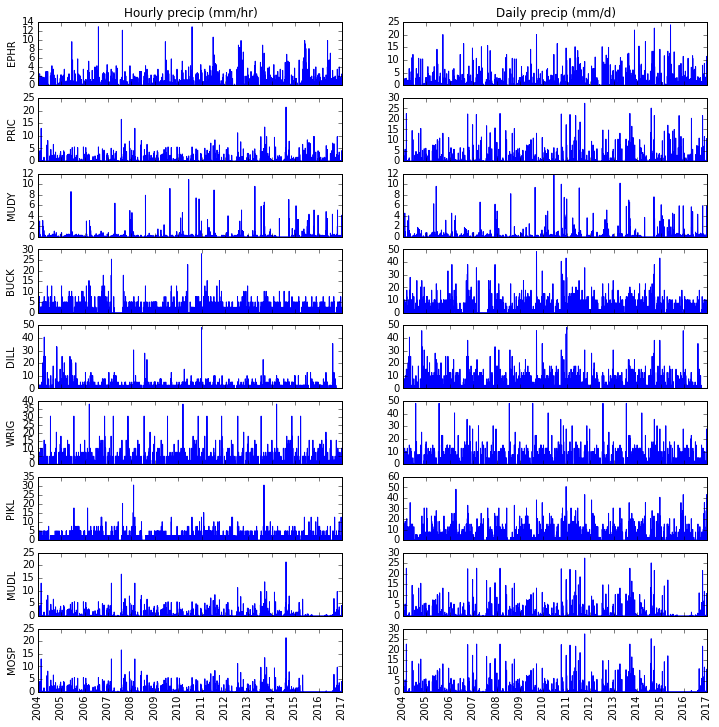

In [238]:
fig01 = plt.figure(figsize=(12, 12))
ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
ax = fig01.add_subplot(9,2,1)
plt.ylabel('EPHR')
plt.title('Hourly precip (mm/hr)')
plt.plot(eph03.index, eph03.PCP1, c='b', label="Hourly")
# ax.set_ylim(0,5)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,2)
# plt.ylabel('EPHR mm/d')
plt.title('Daily precip (mm/d)')
plt.plot(eph04.index, eph04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,3)
plt.ylabel('PRIC')
plt.plot(pri03.index, pri03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,4)
# plt.ylabel('PRIC mm/d')
plt.plot(pri04.index, pri04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,5)
plt.ylabel('MUDY')
plt.plot(mud03.index, mud03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,6)
# plt.ylabel('MUDY mm/d')
plt.plot(mud04.index, mud04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,7)
plt.ylabel('BUCK')
plt.plot(buc03.index, buc03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,8)
# plt.ylabel('BUCK mm/d')
plt.plot(buc04.index, buc04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,9)
plt.ylabel('DILL')
plt.plot(dil03.index, dil03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,10)
# plt.ylabel('DILL mm/d')
plt.plot(dil04.index, dil04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,11)
plt.ylabel('WRIG')
plt.plot(wri03.index, wri03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,12)
# plt.ylabel('WRIG mm/d')
plt.plot(wri04.index, wri04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,13)
plt.ylabel('PIKL')
plt.plot(pik03.index, pik03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,14)
# plt.ylabel('PIKL mm/d')
plt.plot(pik04.index, pik04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,15)
plt.ylabel('MUDL')
plt.plot(mdl03.index, mdl03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,16)
# plt.ylabel('MUDL mm/d')
plt.plot(mdl04.index, mdl04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,17)
plt.ylabel('MOSP')
plt.plot(msp03.index, msp03.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = fig01.add_subplot(9,2,18)
# plt.ylabel('MOSP mm/d')
plt.plot(msp04.index, msp04.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

fig01.savefig('07_AllSites_hr_Dy_PCP.png', bbox_inches='tight')

### Plot PCP at all sites for mo, yr

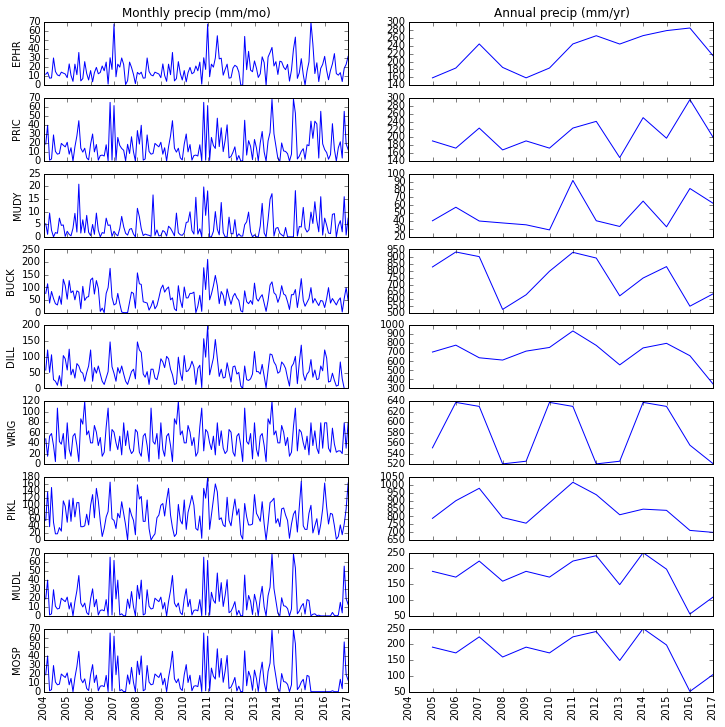

In [239]:
fig01 = plt.figure(figsize=(12, 12))
ax = fig01.add_subplot(9,2,1)
plt.ylabel('EPHR')
plt.title('Monthly precip (mm/mo)')
plt.plot(eph05.index, eph05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,2)
# plt.ylabel('EPHR mm/yr')
plt.title('Annual precip (mm/yr)')
plt.plot(eph06.index, eph06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,3)
plt.ylabel('PRIC')
plt.plot(pri05.index, pri05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,4)
# plt.ylabel('PRIC mm/yr')
plt.plot(pri06.index, pri06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,5)
plt.ylabel('MUDY')
plt.plot(mud05.index, mud05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,6)
# plt.ylabel('MUDY mm/yr')
plt.plot(mud06.index, mud06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,7)
plt.ylabel('BUCK')
plt.plot(buc05.index, buc05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,8)
# plt.ylabel('BUCK mm/yr')
plt.plot(buc06.index, buc06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,9)
plt.ylabel('DILL')
plt.plot(dil05.index, dil05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,10)
# plt.ylabel('DILL mm/yr')
plt.plot(dil06.index, dil06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,11)
plt.ylabel('WRIG')
plt.plot(wri05.index, wri05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,12)
# plt.ylabel('WRIG mm/yr')
plt.plot(wri06.index, wri06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,13)
plt.ylabel('PIKL')
plt.plot(pik05.index, pik05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,14)
# plt.ylabel('PIKL mm/yr')
plt.plot(pik06.index, pik06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,15)
plt.ylabel('MUDL')
plt.plot(mdl05.index, mdl05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,2,16)
# plt.ylabel('MUDL mm/yr')
plt.plot(mdl06.index, mdl06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,2,17)
plt.ylabel('MOSP')
plt.plot(msp05.index, msp05.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = fig01.add_subplot(9,2,18)
# plt.ylabel('MOSP mm/yr')
plt.plot(msp06.index, msp06.PCP1, c='b', label="Hourly")
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

fig01.savefig('07_AllSites_mo_yr_PCP.png', bbox_inches='tight')

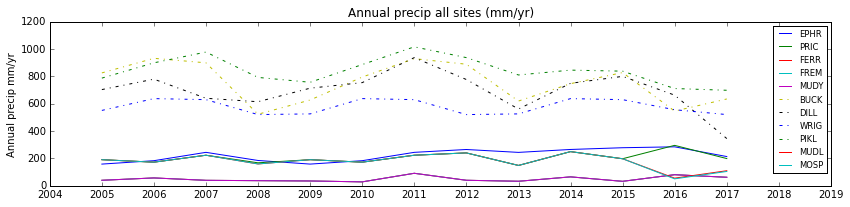

In [240]:
fig01 = plt.figure(figsize=(14,10))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
xticks = ('2004','2005','2006','2007','2008','2009','2010','2011','2012',
          '2013','2014','2015','2016','2017','2018','2019')
ax = fig01.add_subplot(3,1,1)
plt.ylabel('Annual precip mm/yr')
plt.title('Annual precip all sites (mm/yr)')
plt.plot(eph06.index, eph06.PCP1, label="EPHR")
plt.plot(pri06.index, pri06.PCP1, label="PRIC")
plt.plot(fer06.index, fer06.PCP1, label="FERR")
plt.plot(fre06.index, fre06.PCP1, label="FREM")
plt.plot(mud06.index, mud06.PCP1, label="MUDY")
plt.plot(buc06.index, buc06.PCP1, label="BUCK",ls='-.')
plt.plot(dil06.index, dil06.PCP1, label="DILL",ls='-.')
plt.plot(wri06.index, wri06.PCP1, label="WRIG",ls='-.')
plt.plot(pik06.index, pik06.PCP1, label="PIKL",ls='-.')
plt.plot(mdl06.index, mdl06.PCP1, label="MUDL")
plt.plot(msp06.index, msp06.PCP1, label="MOSP")
# plt.xscale(2004,2019)
plt.xticks(xticks)
plt.legend(loc = 'best',fontsize='small');

fig01.savefig('07_AllSites_annual_PCP.png', bbox_inches='tight')

### Plot PCP at all sites for hr, dy, mo, yr

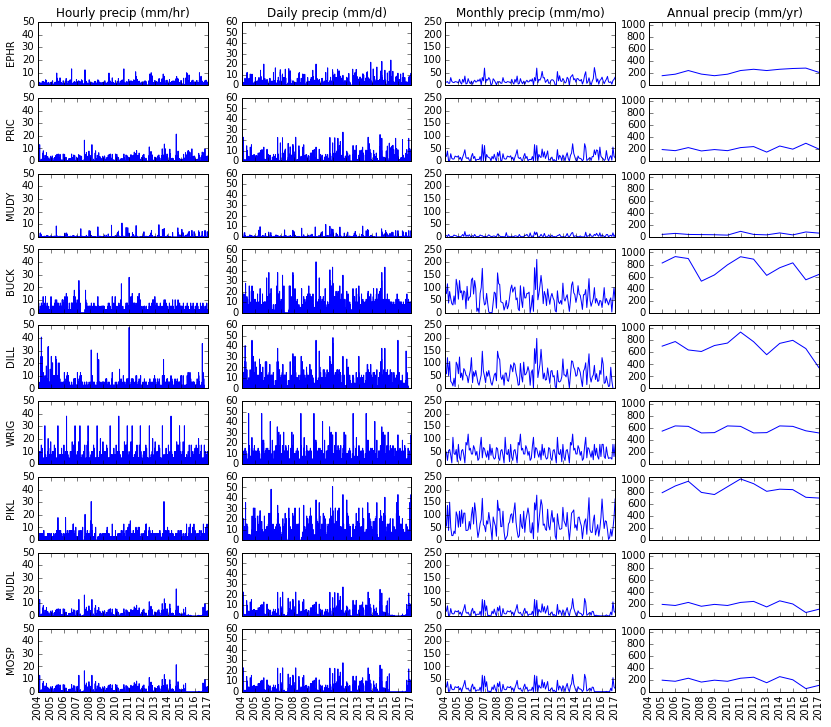

In [241]:
fig01 = plt.figure(figsize=(14, 12))
ax = fig01.add_subplot(9,4,1)
plt.title('Hourly precip (mm/hr)')
plt.ylabel('EPHR')
plt.plot(eph03.index, eph03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,2)
plt.title('Daily precip (mm/d)')
plt.plot(eph04.index, eph04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,3)
plt.title('Monthly precip (mm/mo)')
plt.plot(eph05.index, eph05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,4)
plt.title('Annual precip (mm/yr)')
plt.plot(eph06.index, eph06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,5)
plt.ylabel('PRIC')
plt.plot(pri03.index, pri03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,6)
plt.plot(pri04.index, pri04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,7)
plt.plot(pri05.index, pri05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,8)
plt.plot(pri06.index, pri06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,9)
plt.ylabel('MUDY')
plt.plot(mud03.index, mud03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,10)
plt.plot(mud04.index, mud04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,11)
plt.plot(mud05.index, mud05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,12)
plt.plot(mud06.index, mud06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,13)
plt.ylabel('BUCK')
plt.plot(buc03.index, buc03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,14)
plt.plot(buc04.index, buc04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,15)
plt.plot(buc05.index, buc05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,16)
plt.plot(buc06.index, buc06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,17)
plt.ylabel('DILL')
plt.plot(dil03.index, dil03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,18)
plt.plot(dil04.index, dil04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,19)
plt.plot(dil05.index, dil05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,20)
plt.plot(dil06.index, dil06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,21)
plt.ylabel('WRIG')
plt.plot(wri03.index, wri03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,22)
plt.plot(wri04.index, wri04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,23)
plt.plot(wri05.index, wri05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,24)
plt.plot(wri06.index, wri06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,25)
plt.ylabel('PIKL')
plt.plot(pik03.index, pik03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,26)
plt.plot(pik04.index, pik04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,27)
plt.plot(pik05.index, pik05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,28)
plt.plot(pik06.index, pik06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,29)
plt.ylabel('MUDL')
plt.plot(mdl03.index, mdl03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,30)
plt.plot(mdl04.index, mdl04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,31)
plt.plot(mdl05.index, mdl05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)
ax = fig01.add_subplot(9,4,32)
plt.plot(mdl06.index, mdl06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=False)

ax = fig01.add_subplot(9,4,33)
plt.ylabel('MOSP')
plt.plot(msp03.index, msp03.PCP1, c='b', label="Hourly")
ax.set_ylim(0,50)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = fig01.add_subplot(9,4,34)
plt.plot(msp04.index, msp04.PCP1, c='b', label="Hourly")
ax.set_ylim(0,60)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = fig01.add_subplot(9,4,35)
plt.plot(msp05.index, msp05.PCP1, c='b', label="Hourly")
ax.set_ylim(0,250)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = fig01.add_subplot(9,4,36)
plt.plot(msp06.index, msp06.PCP1, c='b', label="Hourly")
ax.set_ylim(0,1050)
plt.xticks(('2004','2005','2006','2007','2008','2009','2010','2011','2012',
            '2013','2014','2015','2016','2017'), visible=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

fig01.savefig('07_AllSites_hr_dy_mo_yr_PCP.png', bbox_inches='tight')

### Plot daily interpol PPT and PPT cumm at each location (mm)

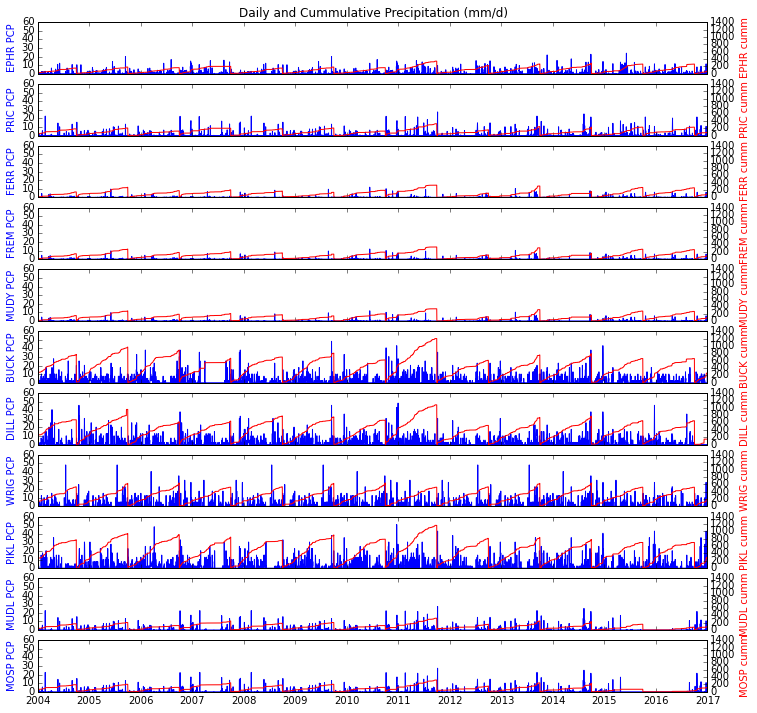

In [242]:
# Precipitation and Max Rain
fig01 = plt.figure(figsize=(12, 12))
ax1 = fig01.add_subplot(11,1,1)
ax2 = ax1.twinx()
plt.title('Daily and Cummulative Precipitation (mm/d)')
ax1.plot(eph04.index, eph04['PCP1'], c='b', label="Daily")
ax2.plot(eph04.index, eph04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('EPHR PCP', color='b')
ax2.set_ylabel('EPHR cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
ax1.set_xticks(('2004','2005','2006','2007','2008','2009','2010','2011',
                '2012','2013','2014','2015','2016','2017'))
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,2, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(pri04.index, pri04['PCP1'], c='b', label="Daily")
ax2.plot(pri04.index, pri04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('PRIC PCP', color='b')
ax2.set_ylabel('PRIC cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,3, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(fer04.index, fer04['PCP1'], c='b', label="Daily")
ax2.plot(fer04.index, fer04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('FERR PCP', color='b')
ax2.set_ylabel('FERR cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,4, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(fre04.index, fre04['PCP1'], c='b', label="Daily")
ax2.plot(fre04.index, fre04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('FREM PCP', color='b')
ax2.set_ylabel('FREM cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,5, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(mud04.index, mud04['PCP1'], c='b', label="Daily")
ax2.plot(mud04.index, mud04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('MUDY PCP', color='b')
ax2.set_ylabel('MUDY cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,6, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(buc04.index, buc04['PCP1'], c='b', label="Daily")
ax2.plot(buc04.index, buc04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('BUCK PCP', color='b')
ax2.set_ylabel('BUCK cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,7, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(dil04.index, dil04['PCP1'], c='b', label="Daily")
ax2.plot(dil04.index, dil04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('DILL PCP', color='b')
ax2.set_ylabel('DILL cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,8, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(wri04.index, wri04['PCP1'], c='b', label="Daily")
ax2.plot(wri04.index, wri04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('WRIG PCP', color='b')
ax2.set_ylabel('WRIG cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,9, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(pik04.index, pik04['PCP1'], c='b', label="Daily")
ax2.plot(pik04.index, pik04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('PIKL PCP', color='b')
ax2.set_ylabel('PIKL cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,10, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(mdl04.index, mdl04['PCP1'], c='b', label="Daily")
ax2.plot(mdl04.index, mdl04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('MUDL PCP', color='b')
ax2.set_ylabel('MUDL cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=False)

ax1 = fig01.add_subplot(11,1,11, sharex=ax1)
ax2 = ax1.twinx()
ax1.plot(msp04.index, msp04['PCP1'], c='b', label="Daily")
ax2.plot(msp04.index, msp04['PCPcum'], c='r', label="Cummul")
ax1.set_ylabel('MOSP PCP', color='b')
ax2.set_ylabel('MOSP cumm', color='r')
ax1.set_ylim(0,60), ax2.set_ylim(0,1400)
plt.setp(ax1.get_xticklabels(), visible=True)

fig01.savefig('07_AllSites_dy_PCP_and_cumm.png', bbox_inches='tight')

### Plot daily cumm PCP, PCP, RNMX for all sites

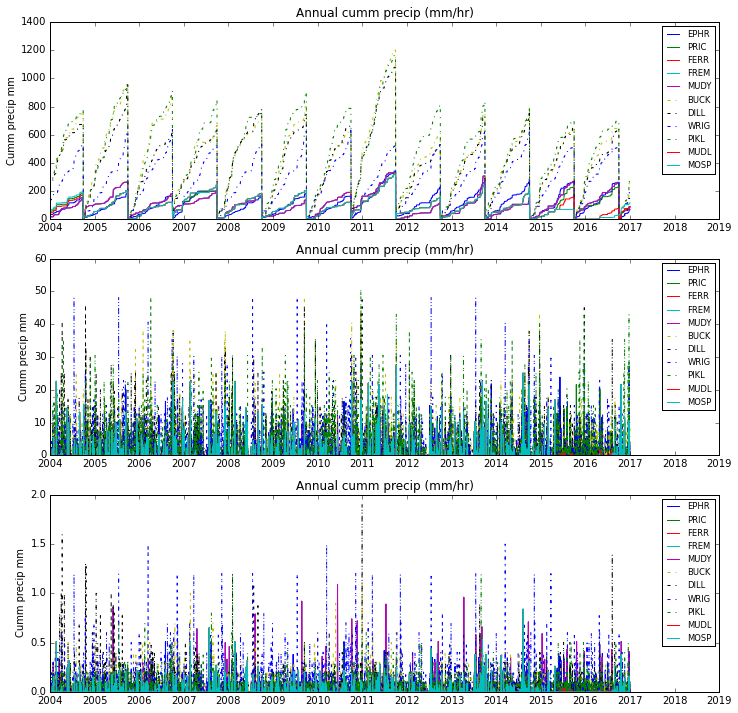

In [243]:
fig01 = plt.figure(figsize=(12,12))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
xticks = ('2004','2005','2006','2007','2008','2009','2010','2011','2012',
          '2013','2014','2015','2016','2017','2018','2019')
ax = fig01.add_subplot(3,1,1)
plt.ylabel('Cumm precip mm')
plt.title('Annual cumm precip (mm/hr)')
plt.plot(eph04.index, eph04.PCPcum, label="EPHR")
plt.plot(pri04.index, pri04.PCPcum, label="PRIC")
plt.plot(fer04.index, fer04.PCPcum, label="FERR")
plt.plot(fre04.index, fre04.PCPcum, label="FREM")
plt.plot(mud04.index, mud04.PCPcum, label="MUDY")
plt.plot(buc04.index, buc04.PCPcum, label="BUCK",ls='-.')
plt.plot(dil04.index, dil04.PCPcum, label="DILL",ls='-.')
plt.plot(wri04.index, wri04.PCPcum, label="WRIG",ls='-.')
plt.plot(pik04.index, pik04.PCPcum, label="PIKL",ls='-.')
plt.plot(mdl04.index, mdl04.PCPcum, label="MUDL")
plt.plot(msp04.index, msp04.PCPcum, label="MOSP")
# plt.xscale(2004,2018)
plt.xticks(xticks)
plt.legend(loc = 'best',fontsize='small');

ax = fig01.add_subplot(3,1,2)
plt.ylabel('Cumm precip mm')
plt.title('Annual cumm precip (mm/hr)')
plt.plot(eph04.index, eph04.PCP1, label="EPHR")
plt.plot(pri04.index, pri04.PCP1, label="PRIC")
plt.plot(fer04.index, fer04.PCP1, label="FERR")
plt.plot(fre04.index, fre04.PCP1, label="FREM")
plt.plot(mud04.index, mud04.PCP1, label="MUDY")
plt.plot(buc04.index, buc04.PCP1, label="BUCK",ls='-.')
plt.plot(dil04.index, dil04.PCP1, label="DILL",ls='-.')
plt.plot(wri04.index, wri04.PCP1, label="WRIG",ls='-.')
plt.plot(pik04.index, pik04.PCP1, label="PIKL",ls='-.')
plt.plot(mdl04.index, mdl04.PCP1, label="MUDL")
plt.plot(msp04.index, msp04.PCP1, label="MOSP")
plt.xticks(xticks)
plt.legend(loc = 'best',fontsize='small');

ax = fig01.add_subplot(3,1,3)
plt.ylabel('Cumm precip mm')
plt.title('Annual cumm precip (mm/hr)')
plt.plot(eph04.index, eph04.RNMX1, label="EPHR")
plt.plot(pri04.index, pri04.RNMX1, label="PRIC")
plt.plot(fer04.index, fer04.RNMX1, label="FERR")
plt.plot(fre04.index, fre04.RNMX1, label="FREM")
plt.plot(mud04.index, mud04.RNMX1, label="MUDY")
plt.plot(buc04.index, buc04.RNMX1, label="BUCK",ls='-.')
plt.plot(dil04.index, dil04.RNMX1, label="DILL",ls='-.')
plt.plot(wri04.index, wri04.RNMX1, label="WRIG",ls='-.')
plt.plot(pik04.index, pik04.RNMX1, label="PIKL",ls='-.')
plt.plot(mdl04.index, mdl04.RNMX1, label="MUDL")
plt.plot(msp04.index, msp04.RNMX1, label="MOSP")
plt.xticks(xticks)
plt.legend(loc = 'best',fontsize='small');

fig01.savefig('07_AllSites_dy_PCPcum_PCP_RNMX.png', bbox_inches='tight')

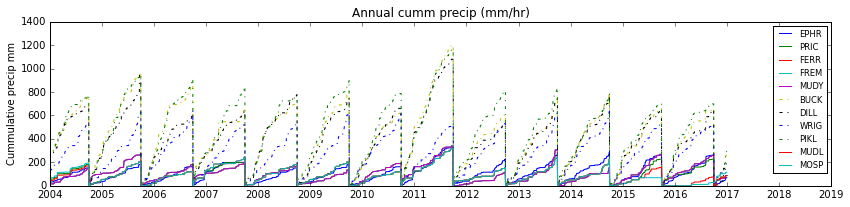

In [244]:
fig01 = plt.figure(figsize=(14,10))
# ticks = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
xticks = ('2004','2005','2006','2007','2008','2009','2010','2011','2012',
          '2013','2014','2015','2016','2017','2018','2019')
ax = fig01.add_subplot(3,1,1)
plt.ylabel('Cummulative precip mm')
plt.title('Annual cumm precip (mm/hr)')
plt.plot(eph04.index, eph04.PCPcum, label="EPHR")
plt.plot(pri04.index, pri04.PCPcum, label="PRIC")
plt.plot(fer04.index, fer04.PCPcum, label="FERR")
plt.plot(fre04.index, fre04.PCPcum, label="FREM")
plt.plot(mud04.index, mud04.PCPcum, label="MUDY")
plt.plot(buc04.index, buc04.PCPcum, label="BUCK",ls='-.')
plt.plot(dil04.index, dil04.PCPcum, label="DILL",ls='-.')
plt.plot(wri04.index, wri04.PCPcum, label="WRIG",ls='-.')
plt.plot(pik04.index, pik04.PCPcum, label="PIKL",ls='-.')
plt.plot(mdl04.index, mdl04.PCPcum, label="MUDL")
plt.plot(msp04.index, msp04.PCPcum, label="MOSP")
# plt.xscale(2004,2018)
plt.xticks(xticks)
plt.legend(loc = 'best',fontsize='small');

fig01.savefig('07_AllSites_hr_PCPcum.png', bbox_inches='tight')

In [245]:
# print buc06

### Time series loop of all EPHR data for hr, dy, mo

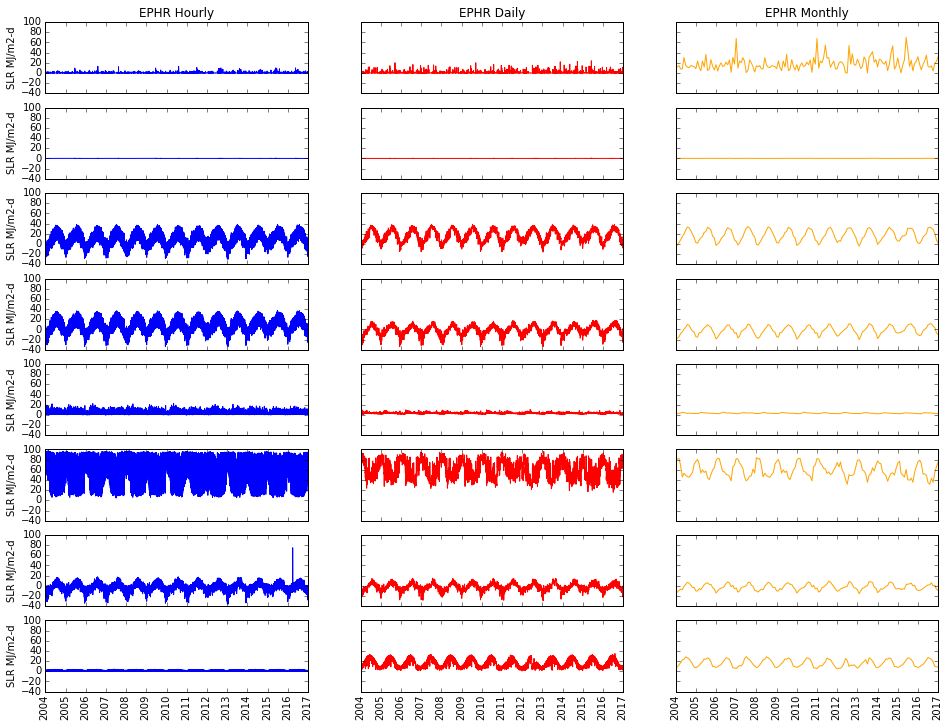

In [246]:
# Not working great. Puts every axis in same range. Labels all same (SLR)
# Time series of all data for each resample discretization
xticks = ('2004','2005','2006','2007','2008','2009','2010','2011','2012',
          '2013','2014','2015','2016','2017')
fig, ax = plt.subplots(nrows=8, ncols=3, sharex=True, sharey=True,figsize=(16, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    ord0 = ax[i,0]
    if i == 0:
        ord0.set_title('EPHR Hourly')
    ord0.plot(eph03.index,eph03[var], c='b')
    ord0.set_xticks(xticks)#, ord0.set_ylim(0,20)
    ord0.set_xticklabels(xticks,rotation=90 )
    for j,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        ord0.set_ylabel(lab)

    ord1 = ax[i,1]
    if i == 0:
        ord1.set_title('EPHR Daily')
    ord1.plot(eph04.index,eph04[var], c='r')
    ord1.set_xticks(xticks)
    ord1.set_xticklabels(xticks,rotation=90 )

    ord2 = ax[i,2]
    if i == 0:
        ord2.set_title('EPHR Monthly')
#     for j,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
#                             'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
#         plt.legend(loc = 'upper left');
#         ord0.set_ylabel(lab)
    ord2.plot(eph05.index,eph05[var], c='orange')
    ord2.set_xticks(xticks)
    ord2.set_xticklabels(xticks,rotation=90 )

fig.savefig('01_Ephraim_weather_vars_all_dts.png', bbox_inches='tight')

### Time series loop of each location all variables with overlain hr, dy, mo

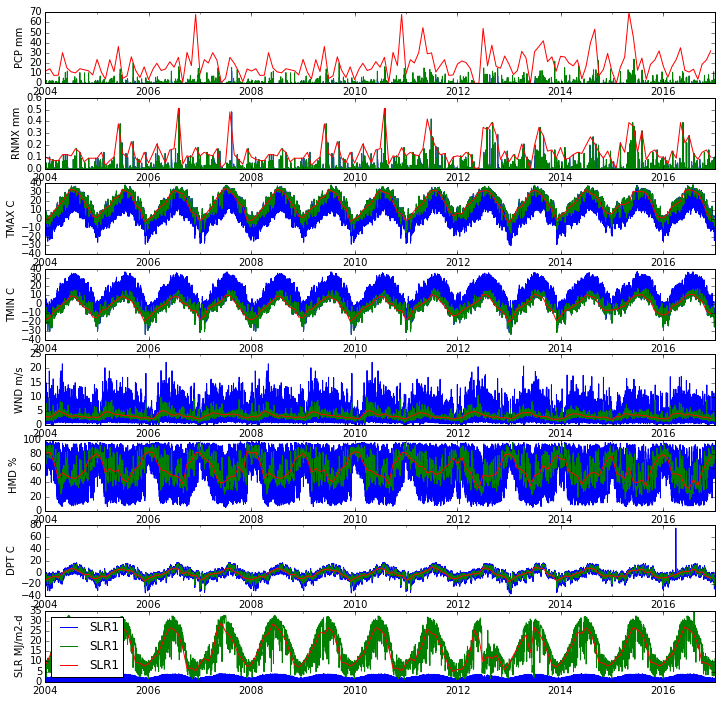

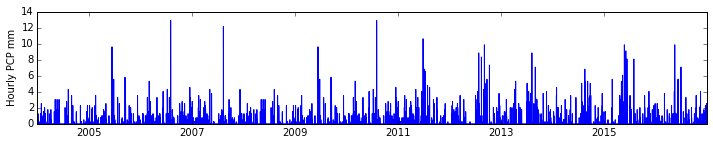

In [247]:
# EPHRAIM
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    eph03[var].plot(ax=axes1[i])
    eph04[var].plot(ax=axes1[i])
    eph05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('01_Ephraim_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(eph03.index, eph03.PCP1, c='b', label="Hourly")
fig.savefig('01_Ephraim_hourly_PCP.png', bbox_inches='tight')

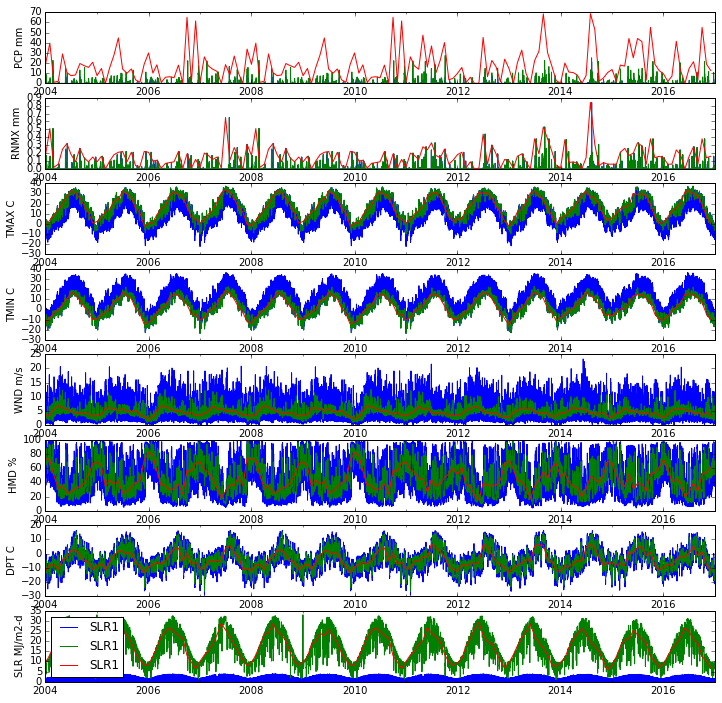

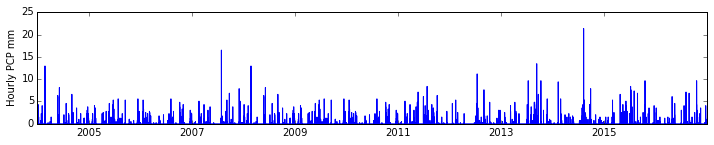

In [248]:
# PRICE
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    pri03[var].plot(ax=axes1[i])
    pri04[var].plot(ax=axes1[i])
    pri05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('02_Price_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(pri03.index, pri03.PCP1, c='b', label="Hourly")
fig.savefig('02_Price_hourly_PCP.png', bbox_inches='tight')

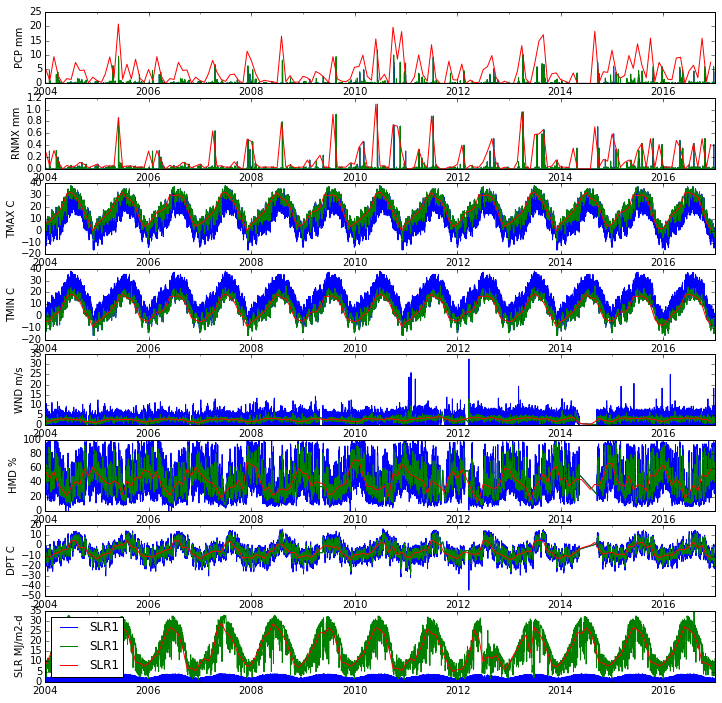

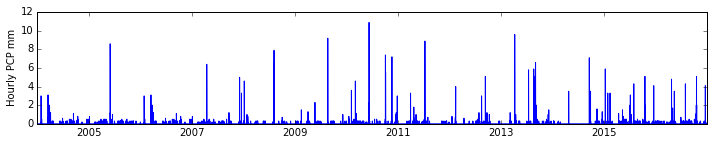

In [249]:
# FERRON
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    fer03[var].plot(ax=axes1[i])
    fer04[var].plot(ax=axes1[i])
    fer05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('03_Ferron_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(fer03.index, fer03.PCP1, c='b', label="Hourly")
fig.savefig('11_Ferron_hourly_PCP.png', bbox_inches='tight')

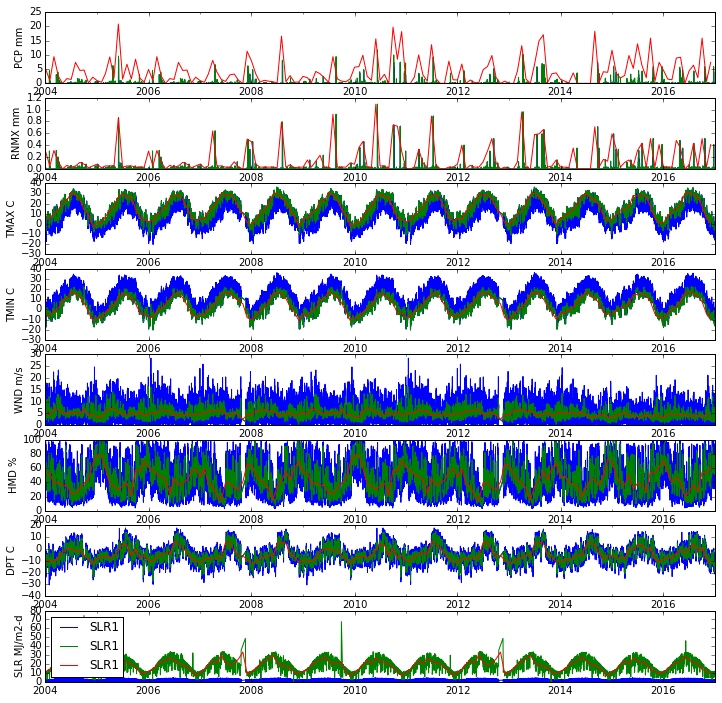

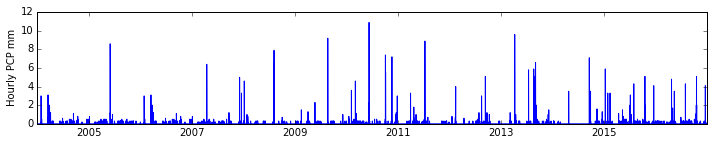

In [250]:
# FREMONT
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    fre03[var].plot(ax=axes1[i])
    fre04[var].plot(ax=axes1[i])
    fre05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('04_Fremont_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(fre03.index, fre03.PCP1, c='b', label="Hourly")
fig.savefig('11_Fremont_hourly_PCP.png', bbox_inches='tight')

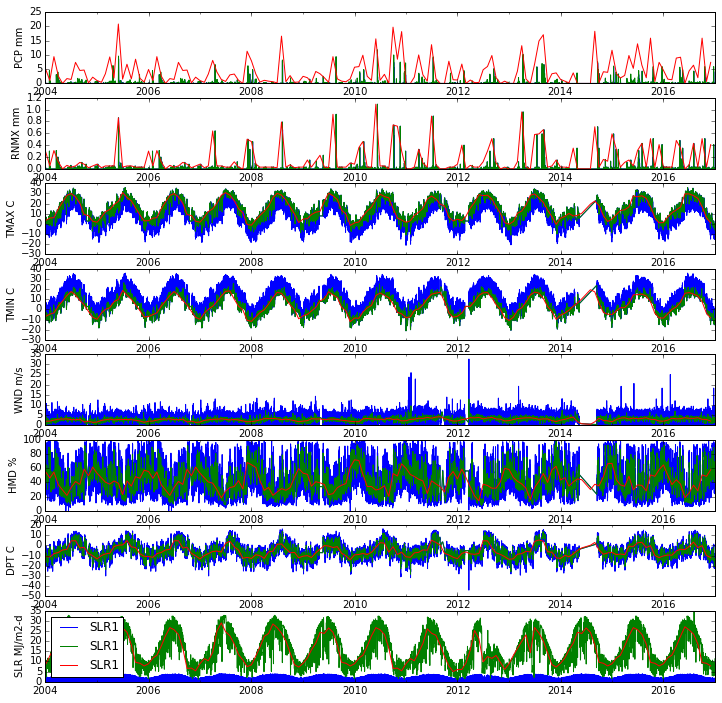

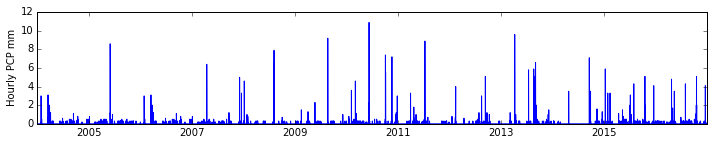

In [251]:
# MUDDY
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    mud03[var].plot(ax=axes1[i])
    mud04[var].plot(ax=axes1[i])
    mud05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('05_Muddy_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(mud03.index, mud03.PCP1, c='b', label="Hourly")
fig.savefig('05_Muddy_hourly_PCP.png', bbox_inches='tight')

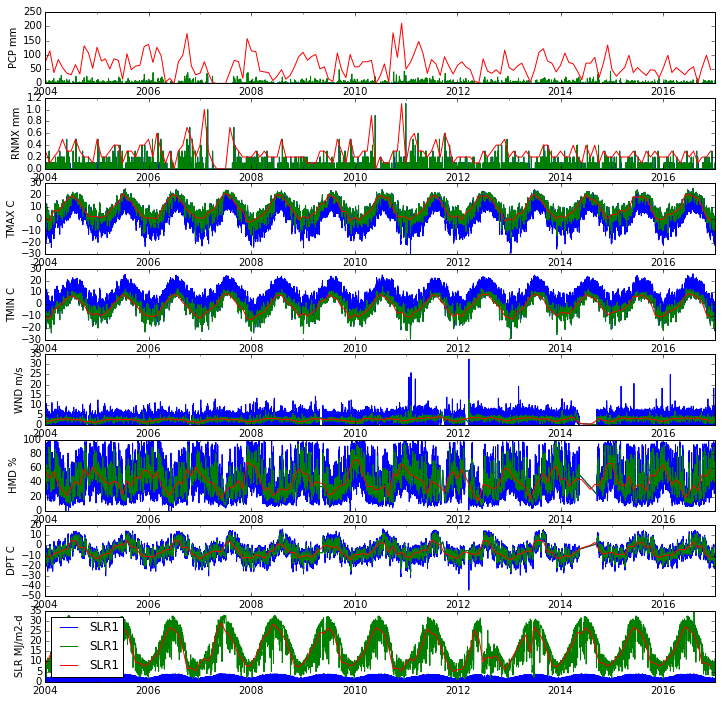

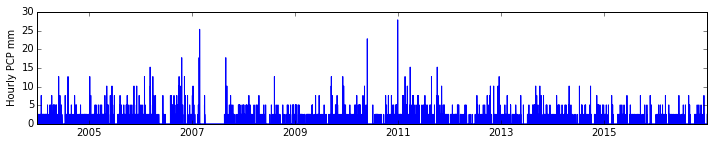

In [252]:
# BUCK
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    buc03[var].plot(ax=axes1[i])
    buc04[var].plot(ax=axes1[i])
    buc05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('06_BuckFlat_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(buc03.index, buc03.PCP1, c='b', label="Hourly")
fig.savefig('06_BuckFlat_hourly_PCP.png', bbox_inches='tight')

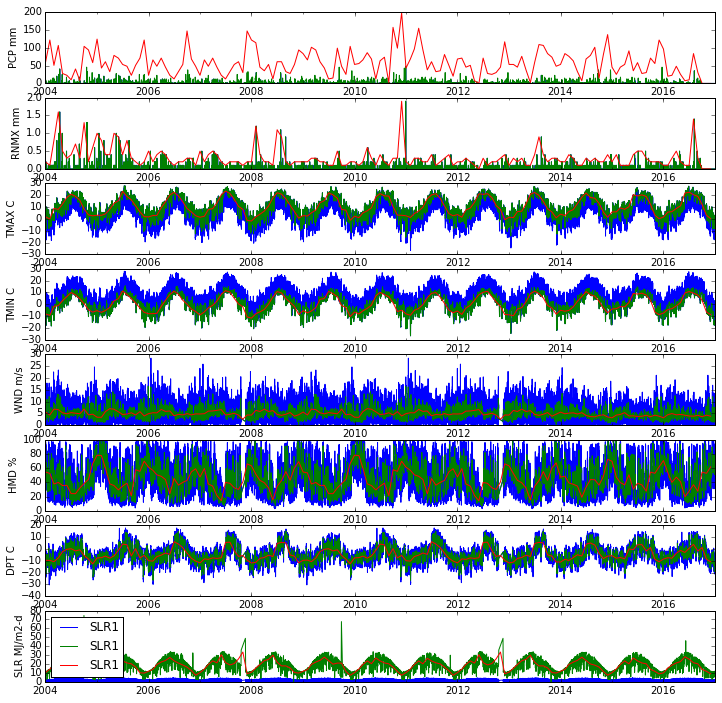

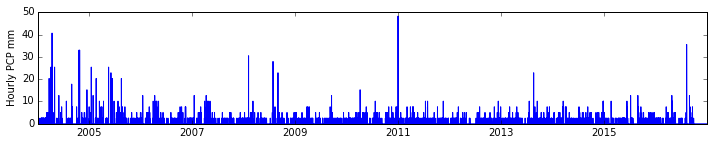

In [253]:
# DILL
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    dil03[var].plot(ax=axes1[i])
    dil04[var].plot(ax=axes1[i])
    dil05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('07_DillsCamp_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(dil03.index, dil03.PCP1, c='b', label="Hourly")
fig.savefig('07_DillsCamp_hourly_PCP.png', bbox_inches='tight')

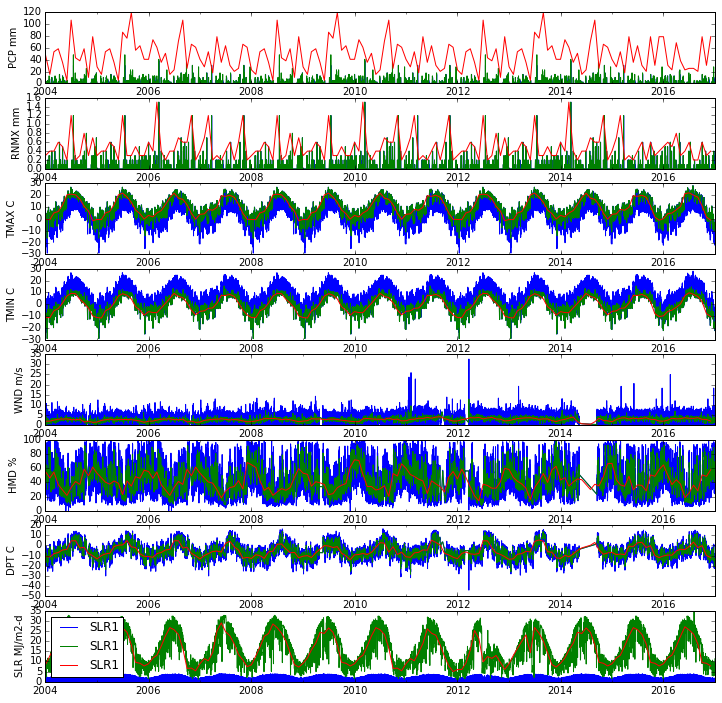

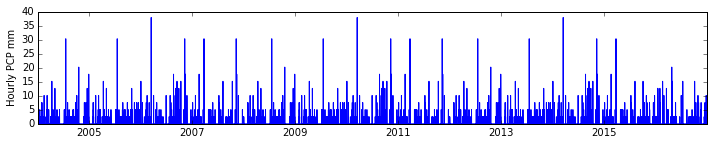

In [254]:
# WRIG
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    wri03[var].plot(ax=axes1[i])
    wri04[var].plot(ax=axes1[i])
    wri05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('08_WrigleyCr_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(wri03.index, wri03.PCP1, c='b', label="Hourly")
fig.savefig('08_WrigleyCr_hourly_PCP.png', bbox_inches='tight')

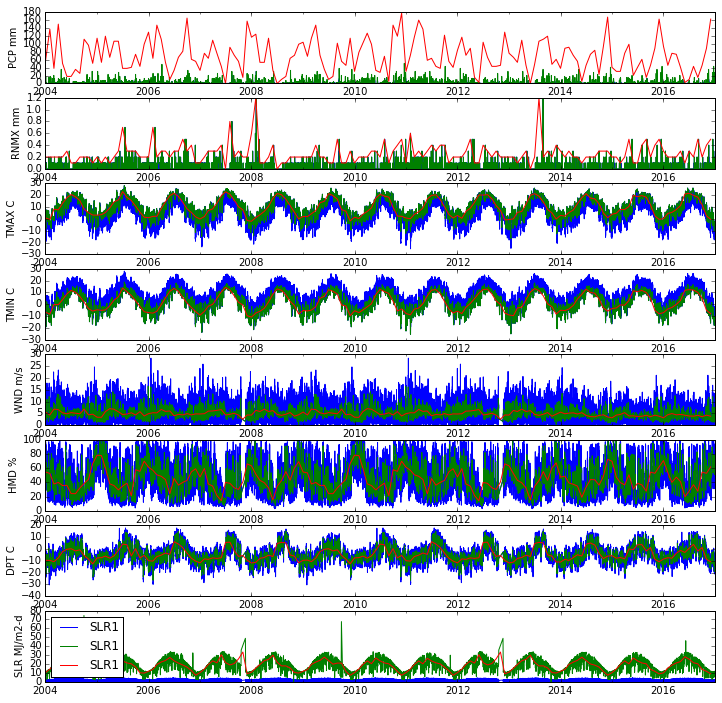

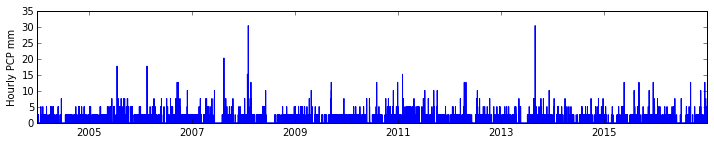

In [255]:
# PIKL
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    pik03[var].plot(ax=axes1[i])
    pik04[var].plot(ax=axes1[i])
    pik05[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('09_PickleKeg_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(pik03.index, pik03.PCP1, c='b', label="Hourly")
fig.savefig('09_PickleKeg_hourly_PCP.png', bbox_inches='tight')

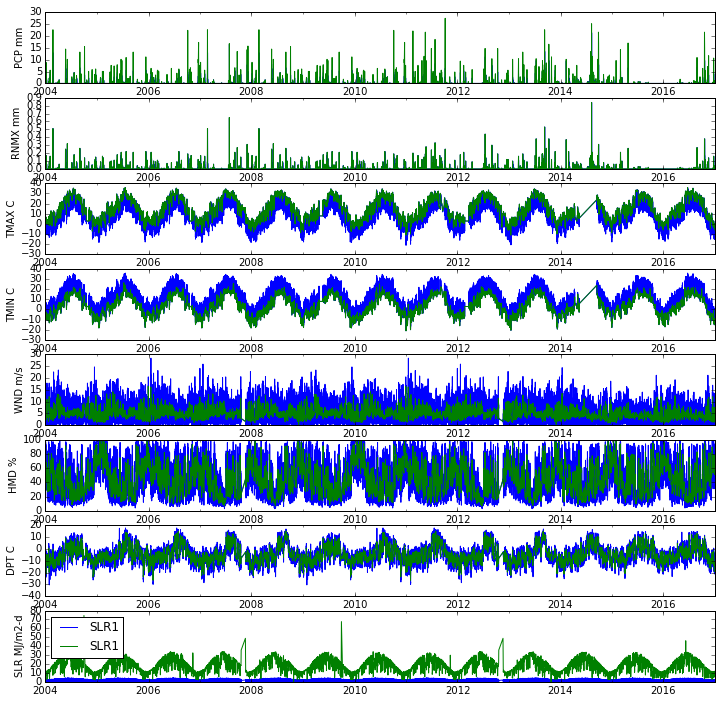

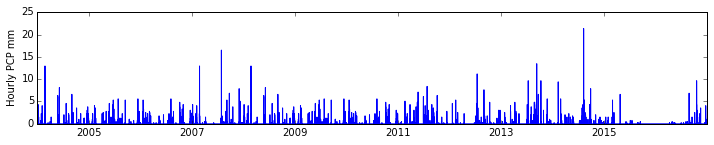

In [256]:
# MUDL
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    mdl03[var].plot(ax=axes1[i])
    mdl04[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        plt.legend(loc = 'upper left');
        axes1[i].set_ylabel(lab)
fig.savefig('10_MuddyCrLow_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(mdl03.index, mdl03.PCP1, c='b', label="Hourly")
fig.savefig('10_MuddyCrLow_hourly_PCP.png', bbox_inches='tight')

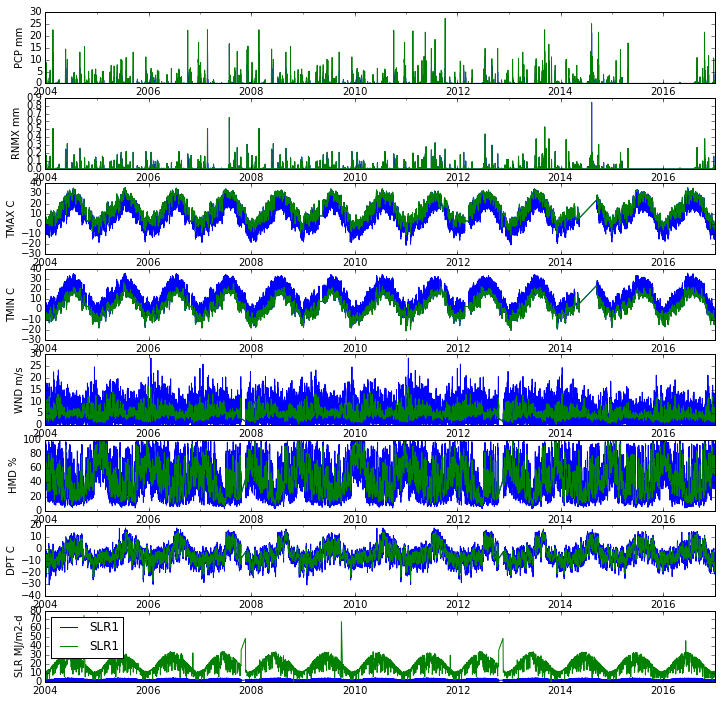

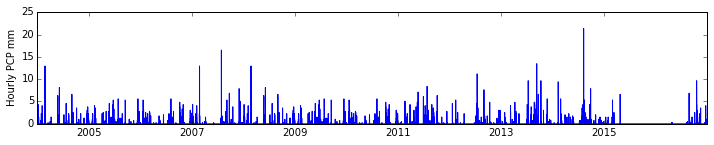

In [257]:
# MOSP
# Time series of all data for each resample discretization
fig, axes1 = plt.subplots(nrows=8, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1','MAX1','MIN1','WND1','HMD1','DPT1','SLR1']):
    msp03[var].plot(ax=axes1[i])
    msp04[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm','TMAX C','TMIN C',
                            'WND m/s','HMD %','DPT C','SLR MJ/m2-d']):
        axes1[i].set_ylabel(lab)
        plt.legend(loc = 'upper left');
fig.savefig('11_MolenSeep_weather_vars_all_dts.png', bbox_inches='tight')

fig = plt.figure(figsize=(12, 2))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Hourly PCP mm')
plt.plot(msp03.index, msp03.PCP1, c='b', label="Hourly")
fig.savefig('11_MolenSeep_hourly_PCP.png', bbox_inches='tight')

### Plot each site time series for each parameter

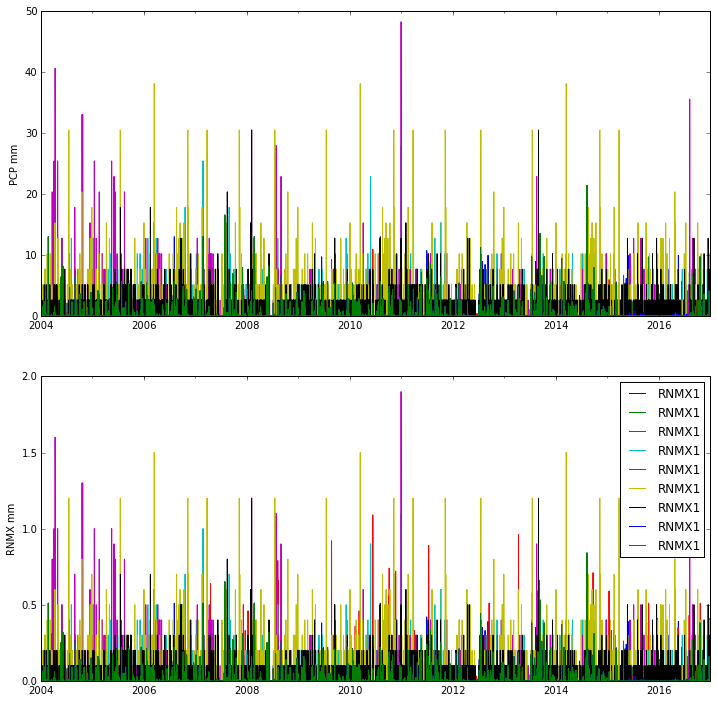

In [258]:
# Time series of PCP data for each resample discretization
# try to plot in log space, also try to add labels for lines
# try to add corellations between sites
fig, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
for i,var in enumerate(['PCP1','RNMX1']):
    eph03[var].plot(ax=axes1[i])
    pri03[var].plot(ax=axes1[i])
#     fer03[var].plot(ax=axes1[i])
#     fre03[var].plot(ax=axes1[i])
    mud03[var].plot(ax=axes1[i])
    buc03[var].plot(ax=axes1[i])
    dil03[var].plot(ax=axes1[i])
    wri03[var].plot(ax=axes1[i])
    pik03[var].plot(ax=axes1[i])
    mdl03[var].plot(ax=axes1[i])
    msp03[var].plot(ax=axes1[i])
    for i,lab in enumerate(['PCP mm','RNMX mm']):
        axes1[i].set_ylabel(lab)
        plt.legend(loc = 'upper right');
fig.savefig('12_Compare_PCP_between_sites.png', bbox_inches='tight')

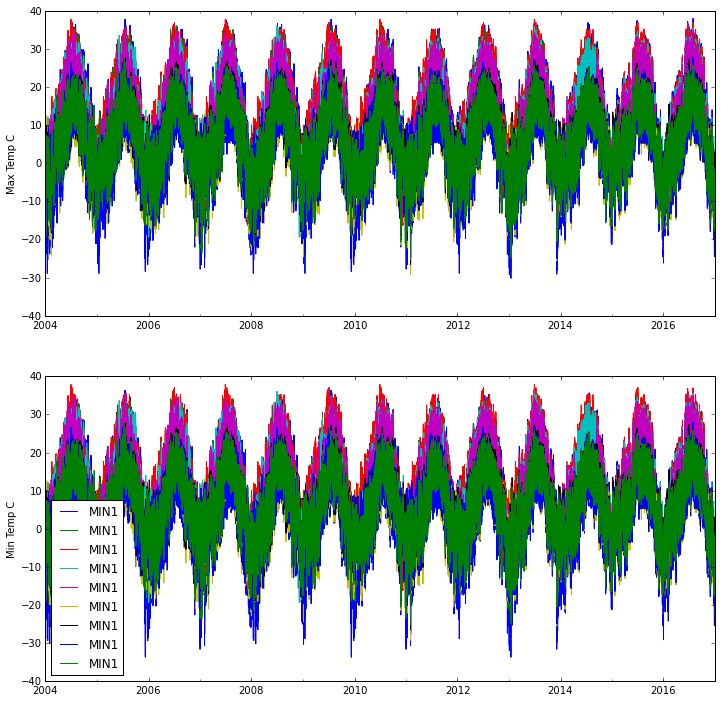

In [259]:
# Time series of TMP data for each resample discretization
fig, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
for i,var in enumerate(['MAX1','MIN1']):
    eph03[var].plot(ax=axes1[i])
    pri03[var].plot(ax=axes1[i])
    fer03[var].plot(ax=axes1[i])
    fre03[var].plot(ax=axes1[i])
    mud03[var].plot(ax=axes1[i])
    buc03[var].plot(ax=axes1[i])
    dil03[var].plot(ax=axes1[i])
    wri03[var].plot(ax=axes1[i])
    pik03[var].plot(ax=axes1[i])
#     mdl03[var].plot(ax=axes1[i])
#     msp03[var].plot(ax=axes1[i])
    for i,lab in enumerate(['Max Temp C','Min Temp C']):
        axes1[i].set_ylabel(lab)
        plt.legend(loc = 'lower left');
fig.savefig('12_Compare_TMP_between_sites.png', bbox_inches='tight')

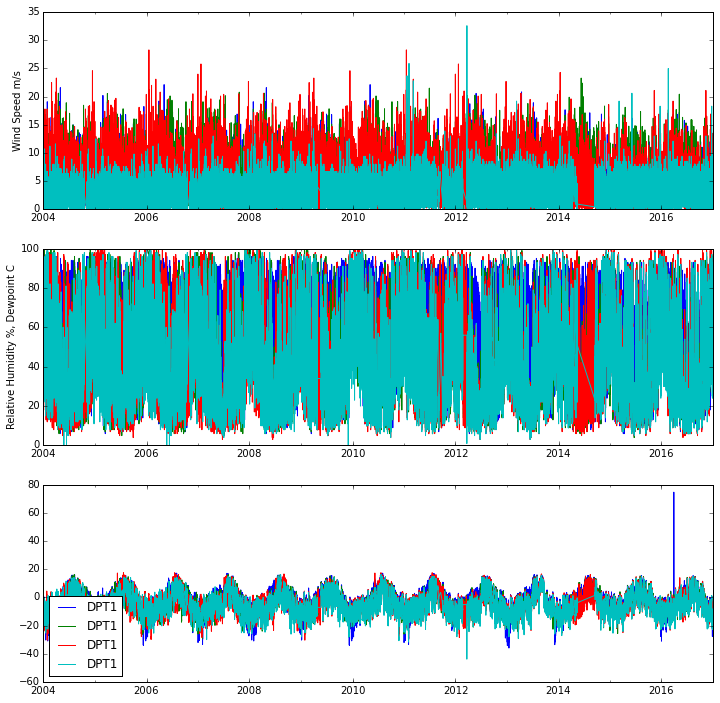

In [260]:
# Time series of WND, HMD, DPT data for each resample discretization
fig, axes1 = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
for i,var in enumerate(['WND1','HMD1','DPT1']):
    eph03[var].plot(ax=axes1[i])
    pri03[var].plot(ax=axes1[i])
#     fer03[var].plot(ax=axes1[i])
    fre03[var].plot(ax=axes1[i])
    mud03[var].plot(ax=axes1[i])
#     buc03[var].plot(ax=axes1[i])
#     dil03[var].plot(ax=axes1[i])
#     wri03[var].plot(ax=axes1[i])
#     pik03[var].plot(ax=axes1[i])
#     mdl03[var].plot(ax=axes1[i])
#     msp03[var].plot(ax=axes1[i])
    for i,lab in enumerate(['Wind Speed m/s','Relative Humidity %, Dewpoint C']):
        axes1[i].set_ylabel(lab)
        plt.legend(loc = 'lower left');
fig.savefig('12_Compare_WND-HMD-DPT_between_sites.png', bbox_inches='tight')

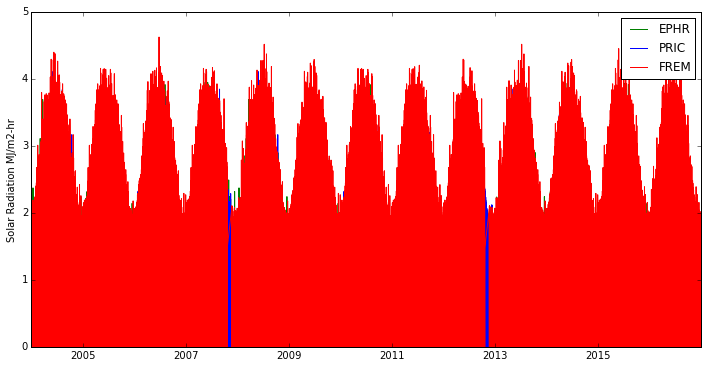

In [261]:
# Time series of SLR data for each resample discretization
fig = plt.figure(figsize=(12, 6))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Solar Radiation MJ/m2-hr')
plt.plot(eph03.index, eph03.SLR1, c='g',label="EPHR")# 
plt.plot(pri03.index, pri03.SLR1, c='b', label="PRIC")#
plt.plot(fre03.index, fre03.SLR1, c='r', label="FREM")
plt.legend(loc = 'upper right');
fig.savefig('12_Compare_SLR_between_sites.png', bbox_inches='tight')

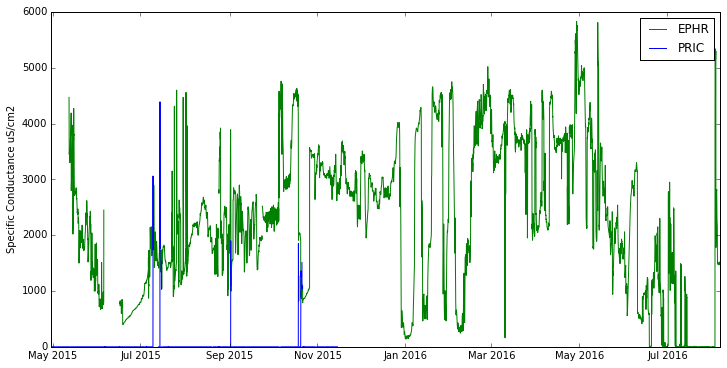

In [262]:
# Time series of SPC data for each resample discretization
fig = plt.figure(figsize=(12, 6))
# ax1.set_xlabel('Minumum Temperature C')
plt.ylabel('Specific Conductance uS/cm2')
plt.plot(mdl03.index, mdl03.SPC_uS, c='g',label="EPHR")
plt.plot(msp03.index, msp03.SPC_uS, c='b', label="PRIC")
plt.legend(loc = 'upper right');
fig.savefig('12_Compare_SPC_between_sites.png', bbox_inches='tight')

**Plot comparisons of values for each site**

In [263]:
# # EPHRAIM
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(15, 4))
# ax1 = fig.add_subplot(131)
# ax1.set_xlabel('Minumum Temperature C')
# ax1.set_ylabel('Dewpoint C')
# plt.scatter(eph03.MIN1, eph03.DPT1, c='b', label="Hourly")
# plt.scatter(eph04.MIN1, eph04.DPT1, c='r', label="Daily")
# plt.scatter(eph05.MIN1, eph05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'upper left');
# ax2 = fig.add_subplot(132)
# ax2.set_xlabel('Windspeed m/s')
# ax2.set_ylabel('Dewpoint C')
# plt.scatter(eph03.WND1, eph03.DPT1, c='b', label="Hourly")
# plt.scatter(eph04.WND1, eph04.DPT1, c='r', label="Daily")
# plt.scatter(eph05.WND1, eph05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# ax3 = fig.add_subplot(133)
# ax3.set_xlabel('Windspeed m/s')
# ax3.set_ylabel('Minumum Temperature C')
# plt.scatter(eph03.WND1, eph03.MIN1, c='b', label="Hourly")
# plt.scatter(eph04.WND1, eph04.MIN1, c='r', label="Daily")
# plt.scatter(eph05.WND1, eph05.MIN1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# plt.tight_layout()
# fig.savefig('01_Ephraim_Temp_Wind_Dwpt_compare.png', bbox_inches='tight')

In [264]:
# # PRICE
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(15, 4))
# ax1 = fig.add_subplot(131)
# ax1.set_xlabel('Minumum Temperature C')
# ax1.set_ylabel('Dewpoint C')
# plt.scatter(pri03.MIN1, pri03.DPT1, c='b', label="Hourly")
# plt.scatter(pri04.MIN1, pri04.DPT1, c='r', label="Daily")
# plt.scatter(pri05.MIN1, pri05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'upper left');
# ax2 = fig.add_subplot(132)
# ax2.set_xlabel('Windspeed m/s')
# ax2.set_ylabel('Dewpoint C')
# plt.scatter(pri03.WND1, pri03.DPT1, c='b', label="Hourly")
# plt.scatter(pri04.WND1, pri04.DPT1, c='r', label="Daily")
# plt.scatter(pri05.WND1, pri05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# ax3 = fig.add_subplot(133)
# ax3.set_xlabel('Windspeed m/s')
# ax3.set_ylabel('Minumum Temperature C')
# plt.scatter(pri03.WND1, pri03.MIN1, c='b', label="Hourly")
# plt.scatter(pri04.WND1, pri04.MIN1, c='r', label="Daily")
# plt.scatter(pri05.WND1, pri05.MIN1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# plt.tight_layout()
# fig.savefig('02_Price_Temp_Wind_Dwpt_compare.png', bbox_inches='tight')

In [265]:
# # FERRON
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(15, 4))
# ax1 = fig.add_subplot(131)
# ax1.set_xlabel('Minumum Temperature C')
# ax1.set_ylabel('Maximum Temperature C')
# plt.scatter(fer03.MIN1, fer03.MAX1, c='b', label="Hourly")
# plt.scatter(fer04.MIN1, fer04.MAX1, c='r', label="Daily")
# plt.scatter(fer05.MIN1, fer05.MAX1, c='y', label="Monthly")
# plt.legend(loc = 'upper left');
# ax2 = fig.add_subplot(132)
# ax2.set_xlabel('Minumum Temperature C')
# ax2.set_ylabel('Average Temperature C')
# plt.scatter(fer03.MIN1, fer03.TMP1, c='b', label="Hourly")
# plt.scatter(fer04.MIN1, fer04.TMP1, c='r', label="Daily")
# plt.scatter(fer05.MIN1, fer05.TMP1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# ax3 = fig.add_subplot(133)
# ax3.set_xlabel('Maximum Temperature C')
# ax3.set_ylabel('Average Temperature C')
# plt.scatter(fer03.MAX1, fer03.TMP1, c='b', label="Hourly")
# plt.scatter(fer04.MAX1, fer04.TMP1, c='r', label="Daily")
# plt.scatter(fer05.MAX1, fer05.TMP1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# plt.tight_layout()
# fig.savefig('03_Ferron_Temp_compare.png', bbox_inches='tight')

In [266]:
# # FREMONT
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(15, 4))
# ax1 = fig.add_subplot(131)
# ax1.set_xlabel('Minumum Temperature C')
# ax1.set_ylabel('Dewpoint C')
# plt.scatter(fre03.MIN1, fre03.DPT1, c='b', label="Hourly")
# plt.scatter(fre04.MIN1, fre04.DPT1, c='r', label="Daily")
# plt.scatter(fre05.MIN1, fre05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'upper left');
# ax2 = fig.add_subplot(132)
# ax2.set_xlabel('Windspeed m/s')
# ax2.set_ylabel('Dewpoint C')
# plt.scatter(fre03.WND1, fre03.DPT1, c='b', label="Hourly")
# plt.scatter(fre04.WND1, fre04.DPT1, c='r', label="Daily")
# plt.scatter(fre05.WND1, fre05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# ax3 = fig.add_subplot(133)
# ax3.set_xlabel('Windspeed m/s')
# ax3.set_ylabel('Minumum Temperature C')
# plt.scatter(fre03.WND1, fre03.MIN1, c='b', label="Hourly")
# plt.scatter(fre04.WND1, fre04.MIN1, c='r', label="Daily")
# plt.scatter(fre05.WND1, fre05.MIN1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# plt.tight_layout()
# fig.savefig('04_Fremont_Temp_Wind_Dwpt_compare.png', bbox_inches='tight')

In [267]:
# # MUDDY
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(15, 4))
# ax1 = fig.add_subplot(131)
# ax1.set_xlabel('Minumum Temperature C')
# ax1.set_ylabel('Dewpoint C')
# plt.scatter(mud03.MIN1, mud03.DPT1, c='b', label="Hourly")
# plt.scatter(mud04.MIN1, mud04.DPT1, c='r', label="Daily")
# plt.scatter(mud05.MIN1, mud05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'upper left');
# ax2 = fig.add_subplot(132)
# ax2.set_xlabel('Windspeed m/s')
# ax2.set_ylabel('Dewpoint C')
# plt.scatter(mud03.WND1, mud03.DPT1, c='b', label="Hourly")
# plt.scatter(mud04.WND1, mud04.DPT1, c='r', label="Daily")
# plt.scatter(mud05.WND1, mud05.DPT1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# ax3 = fig.add_subplot(133)
# ax3.set_xlabel('Windspeed m/s')
# ax3.set_ylabel('Minumum Temperature C')
# plt.scatter(mud03.WND1, mud03.MIN1, c='b', label="Hourly")
# plt.scatter(mud04.WND1, mud04.MIN1, c='r', label="Daily")
# plt.scatter(mud05.WND1, mud05.MIN1, c='y', label="Monthly")
# plt.legend(loc = 'lower right');
# plt.tight_layout()
# fig.savefig('05_Muddy_Temp_Wind_Dwpt_compare.png', bbox_inches='tight')

In [268]:
# # LOWER MUDDY
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(15, 4))
# ax1 = fig.add_subplot(131)
# ax1.set_xlabel('Precipitation mm')
# ax1.set_ylabel('Discharge ft3/s')
# plt.scatter(mdl03.PCP1, mdl03.Q_CFS, c='b', label="Hourly")
# plt.scatter(mdl04.PCP1, mdl04.Q_CFS, c='r', label="Daily")
# plt.scatter(mdl05.PCP1, mdl05.Q_CFS, c='y', label="Monthly")
# plt.legend(loc = 'upper right');
# ax2 = fig.add_subplot(132)
# ax2.set_xlabel('Precipitation mm')
# ax2.set_ylabel('Specific Conductance uS/cm2')
# plt.scatter(mdl03.PCP1, mdl03.SPC_uS, c='b', label="Hourly")
# plt.scatter(mdl04.PCP1, mdl04.SPC_uS, c='r', label="Daily")
# plt.scatter(mdl05.PCP1, mdl05.SPC_uS, c='y', label="Monthly")
# plt.legend(loc = 'upper right');
# ax3 = fig.add_subplot(133)
# ax3.set_xlabel('Discharge ft3/s')
# ax3.set_ylabel('Specific Conductance uS/cm2')
# plt.scatter(mdl03.Q_CFS, mdl03.SPC_uS, c='b', label="Hourly")
# plt.scatter(mdl04.Q_CFS, mdl04.SPC_uS, c='r', label="Daily")
# plt.scatter(mdl05.Q_CFS, mdl05.SPC_uS, c='y', label="Monthly")
# plt.legend(loc = 'upper right');
# plt.tight_layout()
# fig.savefig('10_LowerMuddy_PCP_Q_SPC_compare.png', bbox_inches='tight')

In [269]:
# # MOLEN SEEP
# # Plot some comparisons in weather
# fig = plt.figure(figsize=(6, 4))
# ax2 = fig.add_subplot(111)
# ax2.set_xlabel('Precipitation mm')
# ax2.set_ylabel('Specific Conductance uS/cm2')
# plt.scatter(msp03.PCP1, msp03.SPC_uS, c='b', label="Hourly")
# plt.scatter(msp04.PCP1, msp04.SPC_uS, c='r', label="Daily")
# plt.scatter(msp05.PCP1, msp05.SPC_uS, c='y', label="Monthly")
# plt.legend(loc = 'upper right');
# plt.tight_layout()
# fig.savefig('11_MolenSeep_PCP_SPC_compare.png', bbox_inches='tight')

**Plot scatter matrix for each site of all variables**

In [270]:
# # EPHRAIM
# # Scatter matrix of all weather data
# scat1 = pd.scatter_matrix(eph03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'01_Ephraim_scatterplot.png', bbox_inches='tight')

In [271]:
# # PRICE
# # Scatter matrix of all weather data
# scat2 = pd.scatter_matrix(pri03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'02_Price_scatterplot.png', bbox_inches='tight')

In [272]:
# # FERRON
# # Scatter matrix of all weather data
# scat3 = pd.scatter_matrix(fer03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'03_Ferron_scatterplot.png', bbox_inches='tight')

In [273]:
# # FREMONT
# # Scatter matrix of all weather data
# scat4 = pd.scatter_matrix(fre03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'04_Fremont_scatterplot.png', bbox_inches='tight')

In [274]:
# # MUDDY
# # Scatter matrix of all weather data
# scat5 = pd.scatter_matrix(mud03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'05_Muddy_scatterplot.png', bbox_inches='tight')

In [275]:
# # BUCK
# # Scatter matrix of all weather data
# scat6 = pd.scatter_matrix(buc03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'06_BuckFlat_scatterplot.png', bbox_inches='tight')

In [276]:
# # DILL
# # Scatter matrix of all weather data
# scat7 = pd.scatter_matrix(dil03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'07_DillsCamp_scatterplot.png', bbox_inches='tight')

In [277]:
# # WRIG
# # Scatter matrix of all weather data
# scat8 = pd.scatter_matrix(wri03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'08_WrigleyCr_scatterplot.png', bbox_inches='tight')

In [278]:
# # PIKL
# # Scatter matrix of all weather data
# scat9 = pd.scatter_matrix(pik03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'09_PickleKeg_scatterplot.png', bbox_inches='tight')

In [279]:
# # MUDL
# # Scatter matrix of all weather data
# scat10 = pd.scatter_matrix(mdl03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'10_MuddyCrLow_scatterplot.png', bbox_inches='tight')

In [280]:
# # MOSP
# # Scatter matrix of all weather data
# scat11 = pd.scatter_matrix(msp03.loc[:], figsize=(12,8), diagonal='kde')
# plt.savefig(r'11_MolenSeep_scatterplot.png', bbox_inches='tight')

**OUTPUT DAILY APEX/SWAT WGN ANALYSIS FILES FOR WEATHER STATS WGNMaker**

In [281]:
# print [eph04.dtypes,pri04.dtypes,fer04.dtypes,fre04.dtypes,mud04.dtypes,
#        buc04.dtypes,dil04.dtypes,wri04.dtypes,pik04.dtypes,mdl04.dtypes,
#        msp04.dtypes]

In [282]:
# Get daily date column after XXX04 columns with correct header for output
eph04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = eph04.index.min(),end = eph04.index.max(),freq='D')]
pri04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = pri04.index.min(),end = pri04.index.max(),freq='D')]
fer04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = fer04.index.min(),end = fer04.index.max(),freq='D')]
fre04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = fre04.index.min(),end = fre04.index.max(),freq='D')]
mud04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = mud04.index.min(),end = mud04.index.max(),freq='D')]
buc04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = buc04.index.min(),end = buc04.index.max(),freq='D')]
dil04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = dil04.index.min(),end = dil04.index.max(),freq='D')]
wri04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = wri04.index.min(),end = wri04.index.max(),freq='D')]
pik04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = pik04.index.min(),end = pik04.index.max(),freq='D')]
mdl04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = mdl04.index.min(),end = mdl04.index.max(),freq='D')]
msp04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = msp04.index.min(),end = msp04.index.max(),freq='D')]

In [283]:
# Add new parameter columns after the date column in XXX04 with correct header for output
eph04['PCP'] = eph04['PCP1'].map(lambda x: '%2.2f' % x)
eph04['MAX'] = eph04['MAX1'].map(lambda x: '%2.2f' % x)
eph04['MIN'] = eph04['MIN1'].map(lambda x: '%2.2f' % x)
eph04['WND'] = eph04['WND1'].map(lambda x: '%2.2f' % x)
eph04['HMD'] = eph04['HMD1'].map(lambda x: '%2.2f' % x)
eph04['SLR'] = eph04['SLR1'].map(lambda x: '%2.2f' % x)
eph04['DPT'] = eph04['DPT1'].map(lambda x: '%2.2f' % x)
eph04['RNMX'] = eph04['RNMX1'].map(lambda x: '%2.2f' % x)

pri04['PCP'] = pri04['PCP1'].map(lambda x: '%2.2f' % x)
pri04['MAX'] = pri04['MAX1'].map(lambda x: '%2.2f' % x)
pri04['MIN'] = pri04['MIN1'].map(lambda x: '%2.2f' % x)
pri04['WND'] = pri04['WND1'].map(lambda x: '%2.2f' % x)
pri04['HMD'] = pri04['HMD1'].map(lambda x: '%2.2f' % x)
pri04['SLR'] = pri04['SLR1'].map(lambda x: '%2.2f' % x)
pri04['DPT'] = pri04['DPT1'].map(lambda x: '%2.2f' % x)
pri04['RNMX'] = pri04['RNMX1'].map(lambda x: '%2.2f' % x)

fer04['PCP'] = fer04['PCP1'].map(lambda x: '%2.2f' % x)
fer04['MAX'] = fer04['MAX1'].map(lambda x: '%2.2f' % x)
fer04['MIN'] = fer04['MIN1'].map(lambda x: '%2.2f' % x)
fer04['WND'] = fer04['WND1'].map(lambda x: '%2.2f' % x)
fer04['HMD'] = fer04['HMD1'].map(lambda x: '%2.2f' % x)
fer04['SLR'] = fer04['SLR1'].map(lambda x: '%2.2f' % x)
fer04['DPT'] = fer04['DPT1'].map(lambda x: '%2.2f' % x)
fer04['RNMX'] = fer04['RNMX1'].map(lambda x: '%2.2f' % x)

fre04['PCP'] = fre04['PCP1'].map(lambda x: '%2.2f' % x)
fre04['MAX'] = fre04['MAX1'].map(lambda x: '%2.2f' % x)
fre04['MIN'] = fre04['MIN1'].map(lambda x: '%2.2f' % x)
fre04['WND'] = fre04['WND1'].map(lambda x: '%2.2f' % x)
fre04['HMD'] = fre04['HMD1'].map(lambda x: '%2.2f' % x)
fre04['SLR'] = fre04['SLR1'].map(lambda x: '%2.2f' % x)
fre04['DPT'] = fre04['DPT1'].map(lambda x: '%2.2f' % x)
fre04['RNMX'] = fre04['RNMX1'].map(lambda x: '%2.2f' % x)

mud04['PCP'] = mud04['PCP1'].map(lambda x: '%2.2f' % x)
mud04['MAX'] = mud04['MAX1'].map(lambda x: '%2.2f' % x)
mud04['MIN'] = mud04['MIN1'].map(lambda x: '%2.2f' % x)
mud04['WND'] = mud04['WND1'].map(lambda x: '%2.2f' % x)
mud04['HMD'] = mud04['HMD1'].map(lambda x: '%2.2f' % x)
mud04['SLR'] = mud04['SLR1'].map(lambda x: '%2.2f' % x)
mud04['DPT'] = mud04['DPT1'].map(lambda x: '%2.2f' % x)
mud04['RNMX'] = mud04['RNMX1'].map(lambda x: '%2.2f' % x)

buc04['PCP'] = buc04['PCP1'].map(lambda x: '%6.2f' % x)
buc04['MAX'] = buc04['MAX1'].map(lambda x: '%6.2f' % x)
buc04['MIN'] = buc04['MIN1'].map(lambda x: '%6.2f' % x)
buc04['WND'] = buc04['WND1'].map(lambda x: '%6.2f' % x)
buc04['HMD'] = buc04['HMD1'].map(lambda x: '%6.2f' % x)
buc04['SLR'] = buc04['SLR1'].map(lambda x: '%6.2f' % x)
buc04['DPT'] = buc04['DPT1'].map(lambda x: '%6.2f' % x)
buc04['RNMX'] = buc04['RNMX1'].map(lambda x: '%6.2f' % x)

dil04['PCP'] = dil04['PCP1'].map(lambda x: '%2.2f' % x)
dil04['MAX'] = dil04['MAX1'].map(lambda x: '%2.2f' % x)
dil04['MIN'] = dil04['MIN1'].map(lambda x: '%2.2f' % x)
dil04['WND'] = dil04['WND1'].map(lambda x: '%2.2f' % x)
dil04['HMD'] = dil04['HMD1'].map(lambda x: '%2.2f' % x)
dil04['SLR'] = dil04['SLR1'].map(lambda x: '%2.2f' % x)
dil04['DPT'] = dil04['DPT1'].map(lambda x: '%2.2f' % x)
dil04['RNMX'] = dil04['RNMX1'].map(lambda x: '%2.2f' % x)

wri04['PCP'] = wri04['PCP1'].map(lambda x: '%2.2f' % x)
wri04['MAX'] = wri04['MAX1'].map(lambda x: '%2.2f' % x)
wri04['MIN'] = wri04['MIN1'].map(lambda x: '%2.2f' % x)
wri04['WND'] = wri04['WND1'].map(lambda x: '%2.2f' % x)
wri04['HMD'] = wri04['HMD1'].map(lambda x: '%2.2f' % x)
wri04['SLR'] = wri04['SLR1'].map(lambda x: '%2.2f' % x)
wri04['DPT'] = wri04['DPT1'].map(lambda x: '%2.2f' % x)
wri04['RNMX'] = wri04['RNMX1'].map(lambda x: '%2.2f' % x)

pik04['PCP'] = pik04['PCP1'].map(lambda x: '%2.2f' % x)
pik04['MAX'] = pik04['MAX1'].map(lambda x: '%2.2f' % x)
pik04['MIN'] = pik04['MIN1'].map(lambda x: '%2.2f' % x)
pik04['WND'] = pik04['WND1'].map(lambda x: '%2.2f' % x)
pik04['HMD'] = pik04['HMD1'].map(lambda x: '%2.2f' % x)
pik04['SLR'] = pik04['SLR1'].map(lambda x: '%2.2f' % x)
pik04['DPT'] = pik04['DPT1'].map(lambda x: '%2.2f' % x)
pik04['RNMX'] = pik04['RNMX1'].map(lambda x: '%2.2f' % x)

mdl04['PCP'] = mdl04['PCP1'].map(lambda x: '%2.2f' % x)
mdl04['MAX'] = mdl04['MAX1'].map(lambda x: '%2.2f' % x)
mdl04['MIN'] = mdl04['MIN1'].map(lambda x: '%2.2f' % x)
mdl04['WND'] = mdl04['WND1'].map(lambda x: '%2.2f' % x)
mdl04['HMD'] = mdl04['HMD1'].map(lambda x: '%2.2f' % x)
mdl04['SLR'] = mdl04['SLR1'].map(lambda x: '%2.2f' % x)
mdl04['DPT'] = mdl04['DPT1'].map(lambda x: '%2.2f' % x)
mdl04['RNMX'] = mdl04['RNMX1'].map(lambda x: '%2.2f' % x)

msp04['PCP'] = msp04['PCP1'].map(lambda x: '%2.2f' % x)
msp04['MAX'] = msp04['MAX1'].map(lambda x: '%2.2f' % x)
msp04['MIN'] = msp04['MIN1'].map(lambda x: '%2.2f' % x)
msp04['WND'] = msp04['WND1'].map(lambda x: '%2.2f' % x)
msp04['HMD'] = msp04['HMD1'].map(lambda x: '%2.2f' % x)
msp04['SLR'] = msp04['SLR1'].map(lambda x: '%2.2f' % x)
msp04['DPT'] = msp04['DPT1'].map(lambda x: '%2.2f' % x)
msp04['RNMX'] = msp04['RNMX1'].map(lambda x: '%2.2f' % x)

eph04['DATE'] = pd.to_datetime(eph04['DATE'])
pri04['DATE'] = pd.to_datetime(pri04['DATE'])
fer04['DATE'] = pd.to_datetime(fer04['DATE'])
fre04['DATE'] = pd.to_datetime(fre04['DATE'])
mud04['DATE'] = pd.to_datetime(mud04['DATE'])
buc04['DATE'] = pd.to_datetime(buc04['DATE'])
dil04['DATE'] = pd.to_datetime(dil04['DATE'])
wri04['DATE'] = pd.to_datetime(wri04['DATE'])
pik04['DATE'] = pd.to_datetime(pik04['DATE'])
mdl04['DATE'] = pd.to_datetime(mdl04['DATE'])
msp04['DATE'] = pd.to_datetime(msp04['DATE'])
eph04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = eph04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
pri04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = pri04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
fer04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = fer04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
fre04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = fre04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
mud04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = mud04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
buc04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = buc04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
dil04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = dil04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
wri04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = wri04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
pik04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = pik04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
mdl04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = mdl04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)
msp04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']] = msp04[['PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX']].astype(float)

In [284]:
# print [eph04.dtypes,pri04.dtypes,fer04.dtypes,fre04.dtypes,mud04.dtypes,
#        buc04.dtypes,dil04.dtypes,wri04.dtypes,pik04.dtypes,mdl04.dtypes,
#        msp04.dtypes]

In [285]:
# Get rid of the original data so DATE and PARAMETER(S)
# ephpcp = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
ephpcp = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
ephtmp = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
ephwnd = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
ephhmd = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
ephslr = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
ephdpt = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
ephrnmx = eph04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# pripcp = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
pripcp = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
pritmp = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
priwnd = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
prihmd = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
prislr = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
pridpt = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
prirnmx = pri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# ferpcp = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
ferpcp = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
fertmp = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
ferwnd = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
ferhmd = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
ferslr = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
ferdpt = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
ferrnmx = fer04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# frepcp = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
frepcp = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
fretmp = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
frewnd = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
frehmd = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
freslr = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
fredpt = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
frernmx = fre04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# mudpcp = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
mudpcp = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
mudtmp = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
mudwnd = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
mudhmd = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
mudslr = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
muddpt = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
mudrnmx = mud04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# bucpcp = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
bucpcp = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
buctmp = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
bucwnd = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
buchmd = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
bucslr = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
bucdpt = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
bucrnmx = buc04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# dilpcp = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
dilpcp = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
diltmp = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
dilwnd = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
dilhmd = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
dilslr = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
dildpt = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
dilrnmx = dil04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# wripcp = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
wripcp = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
writmp = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
wriwnd = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
wrihmd = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
wrislr = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
wridpt = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
wrirnmx = wri04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# pikpcp = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
pikpcp = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
piktmp = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
pikwnd = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
pikhmd = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
pikslr = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
pikdpt = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
pikrnmx = pik04.drop(['DATE','PCPcum','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# mdlpcp = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
mdlpcp = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
mdltmp = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
mdlwnd = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
mdlhmd = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
mdlslr = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
mdldpt = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
mdlrnmx = mdl04.drop(['DATE','PCPcum','SPC_uS','Q_CFS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# msppcp = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','DATE','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
msppcp = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
msptmp = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','WND','HMD','SLR','DPT','RNMX'], axis=1)
mspwnd = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
msphmd = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
mspslr = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
mspdpt = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
msprnmx = msp04.drop(['DATE','PCPcum','SPC_uS','TMP1','PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT',], axis=1)

# Check if correct
print ephdpt
print prihmd
print fertmp
print freslr
print mudwnd
print bucpcp
print diltmp
print wrirnmx
print pikslr
print mdlwnd
print mspslr

              DPT
2004-01-01 -21.33
2004-01-02 -17.12
2004-01-03 -11.37
2004-01-04  -3.22
2004-01-05  -1.56
2004-01-06  -4.79
2004-01-07 -14.69
2004-01-08 -12.92
2004-01-09  -5.69
2004-01-10 -14.03
2004-01-11 -10.37
2004-01-12 -13.47
2004-01-13  -6.98
2004-01-14 -15.27
2004-01-15 -14.85
2004-01-16 -21.80
2004-01-17 -22.38
2004-01-18 -14.13
2004-01-19 -12.64
2004-01-20 -13.51
2004-01-21  -6.32
2004-01-22 -11.07
2004-01-23 -11.26
2004-01-24 -12.90
2004-01-25 -10.33
2004-01-26 -13.70
2004-01-27  -8.16
2004-01-28  -5.88
2004-01-29 -14.72
2004-01-30 -10.95
...           ...
2016-12-02 -11.03
2016-12-03  -8.29
2016-12-04  -5.97
2016-12-05  -6.61
2016-12-06  -7.82
2016-12-07  -7.03
2016-12-08  -3.95
2016-12-09  -2.34
2016-12-10  -4.30
2016-12-11  -2.77
2016-12-12  -6.03
2016-12-13  -9.84
2016-12-14  -5.22
2016-12-15  -7.50
2016-12-16  -9.26
2016-12-17 -10.55
2016-12-18  -9.41
2016-12-19  -9.35
2016-12-20  -4.94
2016-12-21  -3.48
2016-12-22  -0.65
2016-12-23  -7.75
2016-12-24 -13.20
2016-12-25

In [286]:
# Print all APEX daily outputs (PCP,TMP,WND,HMD,SLR,DPT,RNMX) to xlsx files in WGN directory for WGNmaker
#EPHR
ephpcp.to_excel((os.path.join(WGNdy,'EPHR_PCP.xlsx')), index=False)
ephtmp.to_excel((os.path.join(WGNdy,'EPHR_TMP.xlsx')), index=False)
ephslr.to_excel((os.path.join(WGNdy,'EPHR_SLR.xlsx')), index=False)
ephwnd.to_excel((os.path.join(WGNdy,'EPHR_WND.xlsx')), index=False)
ephhmd.to_excel((os.path.join(WGNdy,'EPHR_HMD.xlsx')), index=False)
ephrnmx.to_excel((os.path.join(WGNdy,'EPHR_RNMX.xlsx')), index=False)
ephdpt.to_excel((os.path.join(WGNdy,'EPHR_DPT.xlsx')), index=False)

#PRIC
pripcp.to_excel((os.path.join(WGNdy,'PRIC_PCP.xlsx')), index=False)
pritmp.to_excel((os.path.join(WGNdy,'PRIC_TMP.xlsx')), index=False)
prislr.to_excel((os.path.join(WGNdy,'PRIC_SLR.xlsx')), index=False)
priwnd.to_excel((os.path.join(WGNdy,'PRIC_WND.xlsx')), index=False)
prihmd.to_excel((os.path.join(WGNdy,'PRIC_HMD.xlsx')), index=False)
prirnmx.to_excel((os.path.join(WGNdy,'PRIC_RNMX.xlsx')), index=False)
pridpt.to_excel((os.path.join(WGNdy,'PRIC_DPT.xlsx')), index=False)

#FERR
ferpcp.to_excel((os.path.join(WGNdy,'FERR_PCP.xlsx')), index=False)
fertmp.to_excel((os.path.join(WGNdy,'FERR_TMP.xlsx')), index=False)
ferslr.to_excel((os.path.join(WGNdy,'FERR_SLR.xlsx')), index=False)
ferwnd.to_excel((os.path.join(WGNdy,'FERR_WND.xlsx')), index=False)
ferhmd.to_excel((os.path.join(WGNdy,'FERR_HMD.xlsx')), index=False)
ferrnmx.to_excel((os.path.join(WGNdy,'FERR_RNMX.xlsx')), index=False)
ferdpt.to_excel((os.path.join(WGNdy,'FERR_DPT.xlsx')), index=False)

#FREM
frepcp.to_excel((os.path.join(WGNdy,'FREM_PCP.xlsx')), index=False)
fretmp.to_excel((os.path.join(WGNdy,'FREM_TMP.xlsx')), index=False)
freslr.to_excel((os.path.join(WGNdy,'FREM_SLR.xlsx')), index=False)
frewnd.to_excel((os.path.join(WGNdy,'FREM_WND.xlsx')), index=False)
frehmd.to_excel((os.path.join(WGNdy,'FREM_HMD.xlsx')), index=False)
frernmx.to_excel((os.path.join(WGNdy,'FREM_RNMX.xlsx')), index=False)
fredpt.to_excel((os.path.join(WGNdy,'FREM_DPT.xlsx')), index=False)

# MUDY
mudpcp.to_excel((os.path.join(WGNdy,'MUDY_PCP.xlsx')), index=False)
mudtmp.to_excel((os.path.join(WGNdy,'MUDY_TMP.xlsx')), index=False)
mudslr.to_excel((os.path.join(WGNdy,'MUDY_SLR.xlsx')), index=False)
mudwnd.to_excel((os.path.join(WGNdy,'MUDY_WND.xlsx')), index=False)
mudhmd.to_excel((os.path.join(WGNdy,'MUDY_HMD.xlsx')), index=False)
mudrnmx.to_excel((os.path.join(WGNdy,'MUDY_RNMX.xlsx')), index=False)
muddpt.to_excel((os.path.join(WGNdy,'MUDY_DPT.xlsx')), index=False)

# BUCK
bucpcp.to_excel((os.path.join(WGNdy,'BUCK_PCP.xlsx')), index=False)
buctmp.to_excel((os.path.join(WGNdy,'BUCK_TMP.xlsx')), index=False)
bucslr.to_excel((os.path.join(WGNdy,'BUCK_SLR.xlsx')), index=False)
bucwnd.to_excel((os.path.join(WGNdy,'BUCK_WND.xlsx')), index=False)
buchmd.to_excel((os.path.join(WGNdy,'BUCK_HMD.xlsx')), index=False)
bucrnmx.to_excel((os.path.join(WGNdy,'BUCK_RNMX.xlsx')), index=False)
bucdpt.to_excel((os.path.join(WGNdy,'BUCK_DPT.xlsx')), index=False)

# DILL
dilpcp.to_excel((os.path.join(WGNdy,'DILL_PCP.xlsx')), index=False)
diltmp.to_excel((os.path.join(WGNdy,'DILL_TMP.xlsx')), index=False)
dilslr.to_excel((os.path.join(WGNdy,'DILL_SLR.xlsx')), index=False)
dilwnd.to_excel((os.path.join(WGNdy,'DILL_WND.xlsx')), index=False)
dilhmd.to_excel((os.path.join(WGNdy,'DILL_HMD.xlsx')), index=False)
dilrnmx.to_excel((os.path.join(WGNdy,'DILL_RNMX.xlsx')), index=False)
dildpt.to_excel((os.path.join(WGNdy,'DILL_DPT.xlsx')), index=False)

#WRIG
wripcp.to_excel((os.path.join(WGNdy,'WRIG_PCP.xlsx')), index=False)
writmp.to_excel((os.path.join(WGNdy,'WRIG_TMP.xlsx')), index=False)
wrislr.to_excel((os.path.join(WGNdy,'WRIG_SLR.xlsx')), index=False)
wriwnd.to_excel((os.path.join(WGNdy,'WRIG_WND.xlsx')), index=False)
wrihmd.to_excel((os.path.join(WGNdy,'WRIG_HMD.xlsx')), index=False)
wrirnmx.to_excel((os.path.join(WGNdy,'WRIG_RNMX.xlsx')), index=False)
wridpt.to_excel((os.path.join(WGNdy,'WRIG_DPT.xlsx')), index=False)

#PIKL
pikpcp.to_excel((os.path.join(WGNdy,'PIKL_PCP.xlsx')), index=False)
piktmp.to_excel((os.path.join(WGNdy,'PIKL_TMP.xlsx')), index=False)
pikslr.to_excel((os.path.join(WGNdy,'PIKL_SLR.xlsx')), index=False)
pikwnd.to_excel((os.path.join(WGNdy,'PIKL_WND.xlsx')), index=False)
pikhmd.to_excel((os.path.join(WGNdy,'PIKL_HMD.xlsx')), index=False)
pikrnmx.to_excel((os.path.join(WGNdy,'PIKL_RNMX.xlsx')), index=False)
pikdpt.to_excel((os.path.join(WGNdy,'PIKL_DPT.xlsx')), index=False)

# MUDL
mdlpcp.to_excel((os.path.join(WGNdy,'MUDL_PCP.xlsx')), index=False)
mdltmp.to_excel((os.path.join(WGNdy,'MUDL_TMP.xlsx')), index=False)
mdlslr.to_excel((os.path.join(WGNdy,'MUDL_SLR.xlsx')), index=False)
mdlwnd.to_excel((os.path.join(WGNdy,'MUDL_WND.xlsx')), index=False)
mdlhmd.to_excel((os.path.join(WGNdy,'MUDL_HMD.xlsx')), index=False)
mdlrnmx.to_excel((os.path.join(WGNdy,'MUDL_RNMX.xlsx')), index=False)
mdldpt.to_excel((os.path.join(WGNdy,'MUDL_DPT.xlsx')), index=False)

# MOSP
msppcp.to_excel((os.path.join(WGNdy,'MOSP_PCP.xlsx')), index=False)
msptmp.to_excel((os.path.join(WGNdy,'MOSP_TMP.xlsx')), index=False)
mspslr.to_excel((os.path.join(WGNdy,'MOSP_SLR.xlsx')), index=False)
mspwnd.to_excel((os.path.join(WGNdy,'MOSP_WND.xlsx')), index=False)
msphmd.to_excel((os.path.join(WGNdy,'MOSP_HMD.xlsx')), index=False)
msprnmx.to_excel((os.path.join(WGNdy,'MOSP_RNMX.xlsx')), index=False)
mspdpt.to_excel((os.path.join(WGNdy,'MOSP_DPT.xlsx')), index=False)

**OUTPUT DAILY APEX/SWAT .TXT WEATHER FILES**

In [287]:
# Make user identified .dly tables for APEX
# Separate the Date into Day, Month, Year
eph04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=eph04.index.min(),end=eph04.index.max(),freq='D')]
eph04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=eph04.index.min(),end=eph04.index.max(),freq='D')]
eph04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=eph04.index.min(),end=eph04.index.max(),freq='D')]

pri04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=pri04.index.min(),end=pri04.index.max(),freq='D')]
pri04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=pri04.index.min(),end=pri04.index.max(),freq='D')]
pri04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=pri04.index.min(),end=pri04.index.max(),freq='D')]

fer04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=fer04.index.min(),end=fer04.index.max(),freq='D')]
fer04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=fer04.index.min(),end=fer04.index.max(),freq='D')]
fer04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=fer04.index.min(),end=fer04.index.max(),freq='D')]

fre04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=fre04.index.min(),end=fre04.index.max(),freq='D')]
fre04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=fre04.index.min(),end=fre04.index.max(),freq='D')]
fre04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=fre04.index.min(),end=fre04.index.max(),freq='D')]

mud04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=mud04.index.min(),end=mud04.index.max(),freq='D')]
mud04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=mud04.index.min(),end=mud04.index.max(),freq='D')]
mud04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=mud04.index.min(),end=mud04.index.max(),freq='D')]

buc04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=buc04.index.min(),end=buc04.index.max(),freq='D')]
buc04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=buc04.index.min(),end=buc04.index.max(),freq='D')]
buc04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=buc04.index.min(),end=buc04.index.max(),freq='D')]

dil04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=dil04.index.min(),end=dil04.index.max(),freq='D')]
dil04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=dil04.index.min(),end=dil04.index.max(),freq='D')]
dil04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=dil04.index.min(),end=dil04.index.max(),freq='D')]

wri04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=wri04.index.min(),end=wri04.index.max(),freq='D')]
wri04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=wri04.index.min(),end=wri04.index.max(),freq='D')]
wri04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=wri04.index.min(),end=wri04.index.max(),freq='D')]

pik04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=pik04.index.min(),end=pik04.index.max(),freq='D')]
pik04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=pik04.index.min(),end=pik04.index.max(),freq='D')]
pik04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=pik04.index.min(),end=pik04.index.max(),freq='D')]

mdl04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=mdl04.index.min(),end=mdl04.index.max(),freq='D')]
mdl04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=mdl04.index.min(),end=mdl04.index.max(),freq='D')]
mdl04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=mdl04.index.min(),end=mdl04.index.max(),freq='D')]

msp04['DAY'] = [d.strftime('%d') for d in pandas.date_range
                (start=msp04.index.min(),end=msp04.index.max(),freq='D')]
msp04['MONTH'] = [d.strftime('%m') for d in pandas.date_range
                  (start=msp04.index.min(),end=msp04.index.max(),freq='D')]
msp04['YEAR'] = [d.strftime('%Y') for d in pandas.date_range
                 (start=msp04.index.min(),end=msp04.index.max(),freq='D')]

In [288]:
# print [eph04.dtypes,pri04.dtypes,fer04.dtypes,fre04.dtypes,mud04.dtypes,
#        buc04.dtypes,dil04.dtypes,wri04.dtypes,pik04.dtypes,mdl04.dtypes,
#        msp04.dtypes]

In [289]:
# Need to replace all NaN's with 9999.0 for WeatherImport .dly conversion
eph04.fillna(9999.0, inplace=True)
pri04.fillna(9999.0, inplace=True)
fer04.fillna(9999.0, inplace=True)
fre04.fillna(9999.0, inplace=True)
mud04.fillna(9999.0, inplace=True)
buc04.fillna(9999.0, inplace=True)
dil04.fillna(9999.0, inplace=True)
wri04.fillna(9999.0, inplace=True)
pik04.fillna(9999.0, inplace=True)
mdl04.fillna(9999.0, inplace=True)
msp04.fillna(9999.0, inplace=True)
# print fre04

In [290]:
# Create APEX weather file in .txt format to convert to .dly with WeatherImport/Excel CroPMan Weather
# ephr_apex = 'D:\USGS\Shope_FE_Salt_Mobil\Data\Weather\WeatherImport\FEdata'
eph04.to_csv((os.path.join(ephr_apex,'EPHR.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
pri04.to_csv((os.path.join(ephr_apex,'PRIC.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
fer04.to_csv((os.path.join(ephr_apex,'FERR.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
fre04.to_csv((os.path.join(ephr_apex,'FREM.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
mud04.to_csv((os.path.join(ephr_apex,'MUDY.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
buc04.to_csv((os.path.join(ephr_apex,'BUCK.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
dil04.to_csv((os.path.join(ephr_apex,'DILL.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
wri04.to_csv((os.path.join(ephr_apex,'WRIG.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
pik04.to_csv((os.path.join(ephr_apex,'PIKL.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
mdl04.to_csv((os.path.join(ephr_apex,'MUDL.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])
msp04.to_csv((os.path.join(ephr_apex,'MOSP.txt')),index=False, sep='\t',header=True, float_format='%6.2f',
             columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND'])

print eph04
# remember to open these in Excel and save as tab delimited, this is now coded in
# then use WeatherImport to convert to .dly files for APEX
# manually add info from next or previous year to get full year (ie: 1/1/XXXX - 12/31/XXXX)

# To make .dly's, remove the header labels and add a final column at end of all 0's (CO2)
# manually add info from next or previous year to get full year (ie: 1/1/XXXX - 12/31/XXXX)
# eph04['CO2'] = '0.00'
# pri04['CO2'] = '0.00'
# fer04['CO2'] = '0.00'
# fre04['CO2'] = '0.00'
# mud04['CO2'] = '0.00'
# buc04['CO2'] = '0.00'
# dil04['CO2'] = '0.00'
# wri04['CO2'] = '0.00'
# pik04['CO2'] = '0.00'
# mdl04['CO2'] = '0.00'
# msp04['CO2'] = '0.00'

# print eph04
# pd.set_option('precision',2)
# eph04.to_csv((os.path.join(ephr_apex,'EPHR.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# pri04.to_csv((os.path.join(ephr_apex,'PRIC.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# fer04.to_csv((os.path.join(ephr_apex,'FERR.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# fre04.to_csv((os.path.join(ephr_apex,'FREM.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# mud04.to_csv((os.path.join(ephr_apex,'MUDY.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# buc04.to_csv((os.path.join(ephr_apex,'BUCK.dly')),index=False,header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# dil04.to_csv((os.path.join(ephr_apex,'DILL.dly')),index=False,header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# wri04.to_csv((os.path.join(ephr_apex,'WRIG.dly')),index=False,header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# pik04.to_csv((os.path.join(ephr_apex,'PIKL.dly')),index=False,header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# mdl04.to_csv((os.path.join(ephr_apex,'MUDL.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])
# msp04.to_csv((os.path.join(ephr_apex,'MOSP.dly')),index=False, sep='\t',header=False, float_format='%6.2f',
#              columns = ['YEAR','MONTH','DAY','SLR','MAX','MIN','PCP','HMD','WND','CO2'])

            RNMX1       SLR1       HMD1       DPT1  MIN1      WND1  MAX1  \
2004-01-01   0.00  10.101708  74.000000 -21.329167 -25.3  2.389801  -7.8   
2004-01-02   0.00   7.939872  71.583333 -17.120833 -20.5  1.929723  -1.7   
2004-01-03   0.00   8.014392  72.708333 -11.366667 -16.0  2.183045   0.6   
2004-01-04   0.00   7.807968  65.833333  -3.225000  -3.0  3.932089   8.0   
2004-01-05   0.01   2.279160  82.500000  -1.558333  -3.5  7.746831   6.6   
2004-01-06   0.05   2.457072  90.791667  -4.791667 -11.7  3.848269   0.9   
2004-01-07   0.02   6.353352  83.125000 -14.691667 -19.4  2.330196  -4.6   
2004-01-08   0.00   6.508008  86.500000 -12.925000 -21.3  2.421467  -4.4   
2004-01-09   0.01   6.292800  82.166667  -5.691667 -11.3  4.863423   0.8   
2004-01-10   0.00   8.296308  84.416667 -14.033333 -20.6  1.715516  -4.9   
2004-01-11   0.00   9.411516  82.333333 -10.370833 -16.7  3.149769   4.0   
2004-01-12   0.00  10.654776  85.125000 -13.470833 -19.7  1.955800  -4.0   
2004-01-13  

**OUTPUT DAILY APEX/SWAT dbf FILES IN DIRECTORIES (NOT NEEDED)**

In [291]:
# # Print all APEX daily outputs (PCP,TMP,WND,HMD,SLR,DPT,RNMX) to dbf files in appropriate directories
# # Get daily date column after columns with correct header for output
# eph04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = eph04.index.min(),end = eph04.index.max(),freq='D')]
# pri04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = pri04.index.min(),end = pri04.index.max(),freq='D')]
# fer04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = fer04.index.min(),end = fer04.index.max(),freq='D')]
# fre04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = fre04.index.min(),end = fre04.index.max(),freq='D')]
# mud04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = mud04.index.min(),end = mud04.index.max(),freq='D')]
# buc04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = buc04.index.min(),end = buc04.index.max(),freq='D')]
# dil04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = dil04.index.min(),end = dil04.index.max(),freq='D')]
# wri04['DATE'] = [d.strftime('%m/%d/%Y') for d in pandas.date_range(start = wri04.index.min(),end = wri04.index.max(),freq='D')]

# # Add new parameter columns after the date column with correct header for output
# eph04['PCP'] = eph04['PCP1']
# eph04['MAX'] = eph04['MAX1']
# eph04['MIN'] = eph04['MIN1']
# eph04['WND'] = eph04['WND1']
# eph04['HMD'] = eph04['HMD1']
# # eph04['SLR'] = eph04['SLR1']
# eph04['DPT'] = eph04['DPT1']
# eph04['RNMX'] = eph04['RNMX1']

# pri04['PCP'] = pri04['PCP1']
# pri04['MAX'] = pri04['MAX1']
# pri04['MIN'] = pri04['MIN1']
# pri04['WND'] = pri04['WND1']
# pri04['HMD'] = pri04['HMD1']
# # pri04['SLR'] = pri04['SLR1']
# pri04['DPT'] = pri04['DPT1']
# pri04['RNMX'] = pri04['RNMX1']

# # fer04['PCP'] = fer04['PCP1']
# fer04['MAX'] = fer04['MAX1']
# fer04['MIN'] = fer04['MIN1']
# # fer04['WND'] = fer04['WND1']
# # fer04['HMD'] = fer04['HMD1']
# # fer04['SLR'] = fer04['SLR1']
# # fer04['DPT'] = fer04['DPT1']
# # fer04['RNMX'] = fer04['RNMX1']

# # fre04['PCP'] = fre04['PCP1']
# fre04['MAX'] = fre04['MAX1']
# fre04['MIN'] = fre04['MIN1']
# fre04['WND'] = fre04['WND1']
# fre04['HMD'] = fre04['HMD1']
# fre04['SLR'] = fre04['SLR1']
# fre04['DPT'] = fre04['DPT1']
# # fre04['RNMX'] = fre04['RNMX1']

# mud04['PCP'] = mud04['PCP1']
# mud04['MAX'] = mud04['MAX1']
# mud04['MIN'] = mud04['MIN1']
# mud04['WND'] = mud04['WND1']
# mud04['HMD'] = mud04['HMD1']
# # mud04['SLR'] = mud04['SLR1']
# mud04['DPT'] = mud04['DPT1']
# mud04['RNMX'] = mud04['RNMX1']

# buc04['PCP'] = buc04['PCP1']
# buc04['MAX'] = buc04['MAX1']
# buc04['MIN'] = buc04['MIN1']
# # buc04['WND'] = buc04['WND1']
# # buc04['HMD'] = buc04['HMD1']
# # buc04['SLR'] = buc04['SLR1']
# # buc04['DPT'] = buc04['DPT1']
# buc04['RNMX'] = buc04['RNMX1']

# dil04['PCP'] = dil04['PCP1']
# dil04['MAX'] = dil04['MAX1']
# dil04['MIN'] = dil04['MIN1']
# # dil04['WND'] = dil04['WND1']
# # dil04['HMD'] = dil04['HMD1']
# # dil04['SLR'] = dil04['SLR1']
# # dil04['DPT'] = dil04['DPT1']
# dil04['RNMX'] = dil04['RNMX1']

# wri04['PCP'] = wri04['PCP1']
# wri04['MAX'] = wri04['MAX1']
# wri04['MIN'] = wri04['MIN1']
# # wri04['WND'] = wri04['WND1']
# # wri04['HMD'] = wri04['HMD1']
# # wri04['SLR'] = wri04['SLR1']
# # wri04['DPT'] = wri04['DPT1']
# wri04['RNMX'] = wri04['RNMX1']

# # Get rid of the original data so DATE and PARAMETER(S)
# # ephpcp = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
# ephpcp = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
# ephtmp = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','WND','HMD','DPT','RNMX'], axis=1)
# ephwnd = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','HMD','DPT','RNMX'], axis=1)
# ephhmd = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','DPT','RNMX'], axis=1)
# # ephslr = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
# ephdpt = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','RNMX'], axis=1)
# ephrnmx = eph04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT',], axis=1)

# pripcp = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
# pritmp = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','WND','HMD','DPT','RNMX'], axis=1)
# priwnd = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','HMD','DPT','RNMX'], axis=1)
# prihmd = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','DPT','RNMX'], axis=1)
# # prislr = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
# pridpt = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','RNMX'], axis=1)
# prirnmx = pri04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT'], axis=1)

# # ferpcp = fer04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
# fertmp = fer04.drop(['TMP1','MAX1','MIN1'], axis=1)
# # ferwnd = fer04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','HMD','SLR','DPT','RNMX'], axis=1)
# # ferhmd = fer04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','SLR','DPT','RNMX'], axis=1)
# # ferslr = fer04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
# # ferdpt = fer04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','RNMX'], axis=1)
# # ferrnmx = fer04.drop(['PCP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','SLR','DPT'], axis=1)

# # frepcp = fre04.drop(['MAX1','MIN1','WND1','HMD1','SLR1','DPT1','RNMX1','MAX','MIN','WND','HMD','SLR','DPT','RNMX'], axis=1)
# fretmp = fre04.drop(['TMP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','WND','HMD','SLR','DPT'], axis=1)
# frewnd = fre04.drop(['TMP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','MAX','MIN','HMD','SLR','DPT'], axis=1)
# frehmd = fre04.drop(['TMP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','MAX','MIN','WND','SLR','DPT'], axis=1)
# freslr = fre04.drop(['TMP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','MAX','MIN','WND','HMD','DPT'], axis=1)
# fredpt = fre04.drop(['TMP1','MAX1','MIN1','WND1','HMD1','SLR1','DPT1','MAX','MIN','WND','HMD','SLR'], axis=1)
# # frernmx = fre04.drop(['MAX1','MIN1','WND1','HMD1','SLR1','DPT1','MAX','MIN','WND','HMD','SLR','DPT'], axis=1)

# mudpcp = mud04.drop(['PCP1','TMP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','MAX','MIN','WND','HMD','DPT','RNMX'], axis=1)
# mudtmp = mud04.drop(['PCP1','TMP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','WND','HMD','DPT','RNMX'], axis=1)
# mudwnd = mud04.drop(['PCP1','TMP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','HMD','DPT','RNMX'], axis=1)
# mudhmd = mud04.drop(['PCP1','TMP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','DPT','RNMX'], axis=1)
# # mudslr = mud04.drop(['MAX1','MIN1','WND1','HMD1','DPT1','MAX','MIN','WND','HMD','DPT'], axis=1)
# muddpt = mud04.drop(['PCP1','TMP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','RNMX'], axis=1)
# mudrnmx = mud04.drop(['PCP1','TMP1','MAX1','MIN1','WND1','HMD1','DPT1','RNMX1','PCP','MAX','MIN','WND','HMD','DPT'], axis=1)

# bucpcp = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','MAX','MIN','RNMX'], axis=1)
# buctmp = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','RNMX'], axis=1)
# # bucwnd = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # buchmd = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # bucslr = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # bucdpt = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# bucrnmx = buc04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN'], axis=1)

# dilpcp = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','MAX','MIN','RNMX'], axis=1)
# diltmp = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','RNMX'], axis=1)
# # dilwnd = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # dilhmd = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # dilslr = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # dildpt = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# dilrnmx = dil04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN'], axis=1)

# wripcp = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','MAX','MIN','RNMX'], axis=1)
# writmp = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','RNMX'], axis=1)
# # wriwnd = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # wrihmd = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # wrislr = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# # wridpt = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN','RNMX'], axis=1)
# wrirnmx = wri04.drop(['PCP1','TMP1','MAX1','MIN1','RNMX1','PCP','MAX','MIN'], axis=1)

# # Check if correct
# # print ephdpt
# # print prihmd
# # print fertmp
# # print freslr
# # print mudwnd
# print bucpcp
# print diltmp
# print wrirnmx

# # Write dbf file in correct location
# df2dbf(ephpcp, (os.path.join(PCPdy,'EPHR.dbf')))
# df2dbf(ephtmp, (os.path.join(TMPdy,'EPHR.dbf')))
# df2dbf(ephwnd, (os.path.join(WNDdy,'EPHR.dbf')))
# df2dbf(ephhmd, (os.path.join(HMDdy,'EPHR.dbf')))
# # df2dbf(ephslr, (os.path.join(SLRdy,'EPHR.dbf')))
# df2dbf(ephdpt, (os.path.join(DPTdy,'EPHR.dbf')))
# df2dbf(ephrnmx, (os.path.join(HalfPCPdy,'EPHR.dbf')))

# df2dbf(pripcp, (os.path.join(PCPdy,'PRIC.dbf')))
# df2dbf(pritmp, (os.path.join(TMPdy,'PRIC.dbf')))
# df2dbf(priwnd, (os.path.join(WNDdy,'PRIC.dbf')))
# df2dbf(prihmd, (os.path.join(HMDdy,'PRIC.dbf')))
# # df2dbf(prislr, (os.path.join(SLRdy,'PRIC.dbf')))
# df2dbf(pridpt, (os.path.join(DPTdy,'PRIC.dbf')))
# df2dbf(prirnmx, (os.path.join(HalfPCPdy,'PRIC.dbf')))

# # df2dbf(ferpcp, (os.path.join(PCPdy,'FERR.dbf')))
# df2dbf(fertmp, (os.path.join(TMPdy,'FERR.dbf')))
# # df2dbf(ferwnd, (os.path.join(WNDdy,'FERR.dbf')))
# # df2dbf(ferhmd, (os.path.join(HMDdy,'FERR.dbf')))
# # df2dbf(ferslr, (os.path.join(SLRdy,'FERR.dbf')))
# # df2dbf(ferdpt, (os.path.join(DPTdy,'FERR.dbf')))
# # df2dbf(ferrnmx, (os.path.join(HalfPCPdy,'FERR.dbf')))

# # df2dbf(frepcp, (os.path.join(PCPdy,'FREM.dbf')))
# df2dbf(fretmp, (os.path.join(TMPdy,'FREM.dbf')))
# df2dbf(frewnd, (os.path.join(WNDdy,'FREM.dbf')))
# df2dbf(frehmd, (os.path.join(HMDdy,'FREM.dbf')))
# df2dbf(freslr, (os.path.join(SLRdy,'FREM.dbf')))
# df2dbf(fredpt, (os.path.join(DPTdy,'FREM.dbf')))
# # df2dbf(frernmx, (os.path.join(HalfPCPdy,'FREM.dbf')))

# df2dbf(mudpcp, (os.path.join(PCPdy,'MUDY.dbf')))
# df2dbf(mudtmp, (os.path.join(TMPdy,'MUDY.dbf')))
# df2dbf(mudwnd, (os.path.join(WNDdy,'MUDY.dbf')))
# df2dbf(mudhmd, (os.path.join(HMDdy,'MUDY.dbf')))
# # df2dbf(mudslr, (os.path.join(SLRdy,'MUDY.dbf')))
# df2dbf(muddpt, (os.path.join(DPTdy,'MUDY.dbf')))
# df2dbf(mudrnmx, (os.path.join(HalfPCPdy,'MUDY.dbf')))

# df2dbf(bucpcp, (os.path.join(PCPdy,'BUCK.dbf')))
# df2dbf(buctmp, (os.path.join(TMPdy,'BUCK.dbf')))
# # df2dbf(bucwnd, (os.path.join(WNDdy,'BUCK.dbf')))
# # df2dbf(buchmd, (os.path.join(HMDdy,'BUCK.dbf')))
# # df2dbf(bucslr, (os.path.join(SLRdy,'BUCK.dbf')))
# # df2dbf(bucdpt, (os.path.join(DPTdy,'BUCK.dbf')))
# df2dbf(bucrnmx, (os.path.join(HalfPCPdy,'BUCK.dbf')))

# df2dbf(dilpcp, (os.path.join(PCPdy,'DILL.dbf')))
# df2dbf(diltmp, (os.path.join(TMPdy,'DILL.dbf')))
# # df2dbf(dilwnd, (os.path.join(WNDdy,'DILL.dbf')))
# # df2dbf(dilhmd, (os.path.join(HMDdy,'DILL.dbf')))
# # df2dbf(dilslr, (os.path.join(SLRdy,'DILL.dbf')))
# # df2dbf(dildpt, (os.path.join(DPTdy,'DILL.dbf')))
# df2dbf(dilrnmx, (os.path.join(HalfPCPdy,'DILL.dbf')))

# df2dbf(wripcp, (os.path.join(PCPdy,'WRIG.dbf')))
# # df2dbf(writmp, (os.path.join(TMPdy,'WRIG.dbf')))
# # df2dbf(wriwnd, (os.path.join(WNDdy,'WRIG.dbf')))
# # df2dbf(wrihmd, (os.path.join(HMDdy,'WRIG.dbf')))
# # df2dbf(wrislr, (os.path.join(SLRdy,'WRIG.dbf')))
# # df2dbf(wridpt, (os.path.join(DPTdy,'WRIG.dbf')))
# df2dbf(wrirnmx, (os.path.join(HalfPCPdy,'WRIG.dbf')))

# # EPHRAIM-PCP,TMP,WND,HMD,DPT (No SLR)
# # PRICE-PCP,TMP,WND,HMD,DPT (No SLR)
# # FERRON-TMP Only (No PCP,WND,HMD,DPT,SLR)
# # FREMONT-TMP,WND,HMD,DPT,SLR (No PCP)
# # MUDDY-PCP,TMP,WND,HMD,DPT (No SLR)
# # BUCK-PCP,TMP (No SLR,WND,HMD,DPT)
# # DILL-PCP,TMP (No SLR,WND,HMD,DPT)
# # WRIG-PCP,TMP (No SLR,WND,HMD,DPT)

In [292]:
# # Print all APEX daily outputs (PCP,TMP,WND,HMD,SLR,DPT,RNMX) to csv files in appropriate directories-NO NEED WITH DBFs
# # EPHRAIM
# print eph04.dtypes
# eph04.to_csv((os.path.join(PCPdy,'EPHR.csv')), columns = ['PCP1'])
# eph04.to_csv((os.path.join(TMPdy,'EPHR.csv')), columns = ['MAX1','MIN1'])
# eph04.to_csv((os.path.join(SLRdy,'EPHR.csv')), columns = ['SLR1'])
# eph04.to_csv((os.path.join(WNDdy,'EPHR.csv')), columns = ['WND1'])
# eph04.to_csv((os.path.join(HMDdy,'EPHR.csv')), columns = ['HMD1'])
# eph04.to_csv((os.path.join(HalfPCPdy,'EPHR.csv')), columns = ['RNMX1'])
# eph04.to_csv((os.path.join(DPTdy,'EPHR.csv')), columns = ['DPT1'])

# # eph03.to_csv((os.path.join(PCPdy,'EPHRhr.csv')), columns = ['PCP1'])
# # eph03.to_csv((os.path.join(TMPdy,'EPHRhr.csv')), columns = ['MAX1','MIN1'])
# # eph03.to_csv((os.path.join(SLRdy,'EPHRhr.csv')), columns = ['SLR1'])
# # eph03.to_csv((os.path.join(WNDdy,'EPHRhr.csv')), columns = ['WND1'])
# # eph03.to_csv((os.path.join(HMDdy,'EPHRhr.csv')), columns = ['HMD1'])
# # eph03.to_csv((os.path.join(HalfPCPdy,'EPHRhr.csv')), columns = ['RNMX1'])
# # eph03.to_csv((os.path.join(DPTdy,'EPHRhr.csv')), columns = ['DPT1'])

In [293]:
# # Read a file of weather data for wgn analysis
# dfwgn = pd.read_csv(eph01, skiprows=2, header=0, parse_dates=[[1, 2]], keep_date_col=True, infer_datetime_format=True, 
#                     index_col=['Date_Time'], na_values='-99.9')
# dfwgn.replace(-99.9, np.NaN, inplace=True)
# print dfwgn.dtypes
# print dfwgn.index

# # Get The number of years of maximum monthly 0.5 h rainfall data.
# wgnstart = dfwgn.index[0]
# wgnend = dfwgn.index[-1] 
# pcp_yrs = (wgnend-wgnstart)
# print pcp_yrs

# # Get average max and min temp for each of 12 months
# # dfwgn.rename(columns={'Date_Time': 'DATE', 'WSPDX.H-1 (mph) ': 'WND', 'RHUM.I-1 (pct) ': 'HMD', 'PRCP.H-1 (in) ': 'PCP',
# #                     'TMIN.H-1 (degC) ': 'MIN', 'TMAX.H-1 (degC) ': 'MAX'}, inplace=True)
# dfwgn_mo = dfwgn.resample('M', how={'TMAX.H-1 (degC) ':np.max,'TMIN.H-1 (degC) ':np.min})
# print dfwgn_mo

# # Get average max and min temp std dev for each of 12 months
# dfwgn_mo = dfwgn.resample('M', how={'TMAX.H-1 (degC) ':np.std,'TMIN.H-1 (degC) ':np.std})
# print dfwgn_mo

# # Get average pcp for each of 12 months
# dfwgn_mo = dfwgn.resample('M', how={'PRCP.H-1 (in) ':np.sum})
# print dfwgn_mo

# # Get average pcp std dev for each of 12 months
# dfwgn_mo = dfwgn.resample('M', how={'PRCP.H-1 (in) ':np.std})
# print dfwgn_mo

# # Get average pcp for each of 12 months
# dfwgn_mo = dfwgn.resample('M', how={'PRCP.H-1 (in) ':np.skew})
# print dfwgn_mo